In [1]:
#Import packages
import time
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets
import numpy as np
from torchvision import transforms
from torch.autograd import Variable
from PIL import Image
import torchvision.transforms.functional as TF
from torchvision.models.vgg import vgg19
import torch.nn as nn
import torch.nn.functional as F
import torch
from skimage import img_as_ubyte
import torch.nn as nn
import torch.utils.data as Data
import torchvision      # dataset
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy
import numpy as np
import argparse
import glob
import imageio
from skimage import color
import numpy
import natsort
import scipy
import functools
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
import pprint
from scipy.ndimage import correlate
from scipy.ndimage.filters import gaussian_gradient_magnitude
import torchvision.datasets as dset
import torch.utils.data as data
import os
import os.path
from tkinter import *
import tkinter as tk
import tkinter.font as tkFont
from PIL import ImageTk, Image, ImageDraw
import pylab
import cv2
import h5py
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.figure import Figure

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
print(torch.__version__)

1.1.0


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(torch.cuda.get_device_properties(0).total_memory)

11811160064


In [4]:
import multiprocessing

multiprocessing.cpu_count()

12

In [5]:
#define the hyperparameters
image_length = 256
image_width  = 256
mr_channels  = 1
gray_channels = 1
pet_channels = 4    
rgb_channels = 3     
batch_size   = 1
EPOCH = 50
learning_rate = 0.002 

In [6]:
#load the test input MRI dataset
filenames = os.listdir('C:/Users/horan/Desktop/FuseVis_backup/MRI/')
dataset = os.path.join(os.getcwd(), 'C:/Users/horan/Desktop/FuseVis_backup/MRI/')
data = glob.glob(os.path.join(dataset, "1_*.gif"))
data = natsort.natsorted(data,reverse=False)
test_mri = np.zeros((len(data), image_width,image_length))
for i in range(len(data)):
    test_mri[i,:,:] =(imageio.imread(data[i]))
    test_mri[i,:,:] =(test_mri[i,:,:] - np.min(test_mri[i,:,:])) / (np.max(test_mri[i,:,:]) - np.min(test_mri[i,:,:]))
    test_mri[i,:,:] = np.float32(test_mri[i,:,:])

In [7]:
#expand dimension to add the channel
test_mri = np.expand_dims(test_mri,axis=1)
#verify the shape matches the pytorch standard
test_mri.shape

(1, 1, 256, 256)

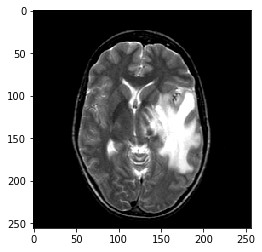

In [8]:
#verify the test mri image
#test_mri = test_mri[0,:,:,:]
#test_mri = np.expand_dims(test_mri,axis=0)
plt.imshow(test_mri[0,0,:,:],'gray')
#plt.savefig('MRI.png', bbox_inches = 'tight',pad_inches = 0,dpi=200)

In [9]:
#convert the MRI Testing data to pytorch tensor
test_mri_tensor = torch.from_numpy(test_mri).float()
test_mri_tensor = test_mri_tensor.to(device)
print(test_mri_tensor.shape)
test_mri_tensor.requires_grad =True

torch.Size([1, 1, 256, 256])


In [10]:
#load the test input PET dataset
filenames = os.listdir('C:/Users/horan/Desktop/FuseVis_backup/PET/')
dataset = os.path.join(os.getcwd(), 'C:/Users/horan/Desktop/FuseVis_backup/PET/')
data = glob.glob(os.path.join(dataset, "1.png"))
data = natsort.natsorted(data,reverse=False)
test_pet = np.zeros((len(data), image_width,image_length))
for i in range(len(data)):
    test_pet[i,:,:] =(imageio.imread(data[i]))
    test_pet[i,:,:] =(test_pet[i,:,:] - np.min(test_pet[i,:,:])) / (np.max(test_pet[i,:,:]) - np.min(test_pet[i,:,:]))
    test_pet[i,:,:] = np.float32(test_pet[i,:,:])

In [11]:
#expand dimension to add the channel
test_pet = np.expand_dims(test_pet,axis=1)
#verify the shape matches the pytorch standard
test_pet.shape 

(1, 1, 256, 256)

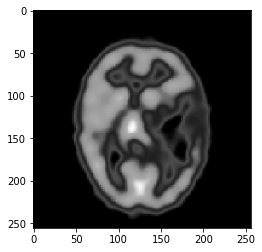

In [12]:
#verify the test pet image
#test_pet = test_pet[2,:,:,:]
#test_pet = np.expand_dims(test_pet,axis=0)
plt.imshow(test_pet[0,0,:,:],'gray')

In [13]:
#convert the MRI Testing data to pytorch tensor
test_pet_tensor = torch.from_numpy(test_pet).float()
test_pet_tensor = test_pet_tensor.to(device)
print(test_pet_tensor.shape)
test_pet_tensor.requires_grad =True

torch.Size([1, 1, 256, 256])


# define the weighted averaging model

In [14]:
w1 = np.zeros((image_width,image_length),dtype = float)
w2 = np.zeros((image_width,image_length),dtype = float)
#fused = np.zeros((1,1,image_width,image_length),dtype = float)
#fused_tensor = torch.from_numpy(test_pet).float().to(device)

for i in range(0,image_width):
    for j in range(0,image_length):
        if test_mri[0,0,i,j] == test_pet[0,0,i,j]:
            w1[i,j] = 0.5
            w2[i,j] = 0.5
        else:
            w1[i,j] = test_mri[0,0,i,j] / (test_mri[0,0,i,j] +test_pet[0,0,i,j])
            w2[i,j] = test_pet[0,0,i,j] / (test_mri[0,0,i,j] +test_pet[0,0,i,j])
                    
#convert the MRI Testing data to pytorch tensor
w1_tensor = torch.from_numpy(w1).float().to(device)
w2_tensor = torch.from_numpy(w2).float().to(device)

In [15]:
#define the network
class Weighted_Averaging(nn.Module):
    def  __init__(self):
        super(Weighted_Averaging, self).__init__()

    def forward(self, x, y, wt1, wt2):
        #define the fusion operator using wegithed averaging
        fused = wt1*x + wt2*y
        return fused

model0 = Weighted_Averaging().to(device)
model0 = model0.float()
print(model0)

Weighted_Averaging()


# define the FunFuseAn model

In [16]:
#define the network
class FunFuseAn(nn.Module):
    def  __init__(self):
        super(FunFuseAn, self).__init__()
        #####mri lf layer 1#####
        self.mri_lf = nn.Sequential( #input shape (,1,256,256)
                         nn.Conv2d(in_channels=1, out_channels=16, kernel_size=9, stride=1, padding=4),
                         nn.BatchNorm2d(16),
                         nn.LeakyReLU(0.2,inplace=True)) #output shape (,16,256,256)   
        #####mri hf layers#####
        self.mri_hf = nn.Sequential(  #input shape (,1,256,256)
                         nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size  = 3, stride= 1, padding = 1),
                         nn.BatchNorm2d(16),
                         nn.LeakyReLU(0.2,inplace=True),
                         nn.Conv2d(in_channels  = 16, out_channels = 32, kernel_size = 3, stride = 1, padding = 1),
                         nn.BatchNorm2d(32),
                         nn.LeakyReLU(0.2,inplace=True),
                         nn.Conv2d(in_channels  = 32, out_channels = 64, kernel_size  = 3, stride = 1, padding = 1),
                         nn.BatchNorm2d(64),
                         nn.LeakyReLU(0.2,inplace=True)) #output shape (,64,256,256)
        #####pet lf layer 1#####
        self.pet_lf = nn.Sequential( #input shape (,1,256,256)
                         nn.Conv2d(in_channels=1, out_channels=16, kernel_size=7, stride=1, padding=3),
                         nn.BatchNorm2d(16),
                         nn.LeakyReLU(0.2,inplace=True)) #output shape (,16,256,256)   
        #####pet hf layers#####
        self.pet_hf = nn.Sequential(  #input shape (,1,256,256)
                         nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size  = 5, stride= 1, padding = 2),
                         nn.BatchNorm2d(16),
                         nn.LeakyReLU(0.2,inplace=True),
                         nn.Conv2d(in_channels  = 16, out_channels = 32, kernel_size = 5, stride = 1, padding = 2),
                         nn.BatchNorm2d(32),
                         nn.LeakyReLU(0.2,inplace=True),
                         nn.Conv2d(in_channels  = 32, out_channels = 64, kernel_size  = 3, stride = 1, padding = 1),
                         nn.BatchNorm2d(64),
                         nn.LeakyReLU(0.2,inplace=True)) #output shape (,64,256,256)
        #####reconstruction layer 1#####
        self.recon1 = nn.Sequential(  #input shape (, 64, 256, 256)
                          nn.Conv2d(in_channels  = 64,  out_channels = 32, kernel_size  = 5, stride = 1, padding = 2),
                          nn.BatchNorm2d(32),
                          nn.LeakyReLU(0.2,inplace=True),
                          nn.Conv2d(in_channels  = 32, out_channels = 16, kernel_size  = 5, stride = 1, padding = 2),
                          nn.BatchNorm2d(16),
                          nn.LeakyReLU(0.2,inplace=True)) #output shape (,16, 256, 256)
        
        #####reconstruction layer 2#####
        self.recon2 = nn.Sequential(      #input shape (,16, 256, 256)
                            nn.Conv2d(in_channels  = 16, out_channels = 1, kernel_size  = 5, stride = 1, padding = 2))   #output shape (,1,256,256)

    def forward(self, x, y):
        #mri lf layer 1
        x1 = self.mri_lf(x)
        #mri hf layers
        x2 = self.mri_hf(x)
        #pet lf layer 1
        y1 = self.pet_lf(y)
        #pet hf layers
        y2 = self.pet_hf(y)
        #high frequency fusion layer
        fuse_hf = x2 + y2
        #reconstruction layer1
        recon_hf = self.recon1(fuse_hf)
        #low frequency fusion layer
        fuse_lf = (x1 + y1 + recon_hf)/3
        #reconstruction layer2
        recon3 = self.recon2(fuse_lf)
        #tanh layer
        fused = torch.tanh(recon3)      
        return fused
        #execute the network

model1 = FunFuseAn().to(device)
model1 = model1.float()
print(model1)

FunFuseAn(
  (mri_lf): Sequential(
    (0): Conv2d(1, 16, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace)
  )
  (mri_hf): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace)
  )
  (pet_lf): Sequential(
    (0): Conv2d(1, 16, kernel_size=(7, 7), stride=(1, 1), paddi

# define the MaskNet Model

In [17]:
#define the Mask-Net network
class MaskNet(nn.Module):
    def  __init__(self):
        super(MaskNet, self).__init__()
        #####encoder layer 1#####
        self.layer1 = nn.Sequential(  #input shape (,2,256,256)
                         nn.Conv2d(in_channels=2, out_channels=48, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm2d(48),
                         nn.LeakyReLU(0.2,inplace=True)) #output shape (,48,256,256)   
        #####encoder layer 2#####
        self.layer2 = nn.Sequential(  #input shape (,48,256,256)
                         nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size  = 3, stride= 1, padding = 1),
                         nn.BatchNorm2d(48),
                         nn.LeakyReLU(0.2,inplace=True))  #output shape (,48,256,256)
        #####encoder layer 3#####
        self.layer3 = nn.Sequential(  #input shape (,96,256,256)
                         nn.Conv2d(in_channels = 96, out_channels = 48, kernel_size  = 3, stride= 1, padding = 1),
                         nn.BatchNorm2d(48),
                         nn.LeakyReLU(0.2,inplace=True))  #output shape (,48,256,256)     
        #####encoder layer 4#####
        self.layer4 = nn.Sequential(  #input shape (,144,256,256)
                         nn.Conv2d(in_channels = 144, out_channels = 48, kernel_size  = 3, stride= 1, padding = 1),
                         nn.BatchNorm2d(48),
                         nn.LeakyReLU(0.2,inplace=True))  #output shape (,48,256,256) 
        #####decoder layer 1#####
        self.layer5 = nn.Sequential(  #input shape (,192,256,256)
                         nn.Conv2d(in_channels = 192, out_channels = 192, kernel_size  = 3, stride= 1, padding = 1),
                         nn.BatchNorm2d(192),
                         nn.LeakyReLU(0.2,inplace=True))  #output shape (,192,256,256)    
        #####decoder layer 2#####
        self.layer6 = nn.Sequential(  #input shape (,192,256,256)
                         nn.Conv2d(in_channels = 192, out_channels = 128, kernel_size  = 3, stride= 1, padding = 1),
                         nn.BatchNorm2d(128),
                         nn.LeakyReLU(0.2,inplace=True))  #output shape (,128,256,256)    
        #####decoder layer 3#####
        self.layer7 = nn.Sequential(  #input shape (,128,256,256)
                         nn.Conv2d(in_channels = 128, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
                         nn.BatchNorm2d(64),
                         nn.LeakyReLU(0.2,inplace=True))  #output shape (,64,256,256)  
        #####decoder layer 4#####
        self.layer8 = nn.Sequential(#input shape (,64,256,256)
                         nn.Conv2d(in_channels = 64, out_channels = 1, kernel_size = 3, stride = 1, padding = 1),
                         nn.BatchNorm2d(1),
                         nn.LeakyReLU(0.2,inplace=True))  #output shape (,1,256,256)          
 
    def forward(self, x, y):
        #encoder layer 1
        en1 = self.layer1(torch.cat((x,y),dim=1))
        #encoder layer 2
        en2 = self.layer2(en1)
        #concat layer 1
        concat1 = torch.cat((en1,en2),dim=1)
        #encoder layer 3
        en3 = self.layer3(concat1)
        #concat layer 2
        concat2 = torch.cat((concat1,en3),dim=1)
        #encoder layer 4
        en4 = self.layer4(concat2)
        #concat layer 3
        concat3 = torch.cat((concat2,en4),dim=1)
        #decoder layer 1
        dec1 = self.layer5(concat3)
        #decoder layer 2
        dec2 = self.layer6(dec1)
        #decoder layer 3
        dec3 = self.layer7(dec2)
        #decoder layer 4
        dec4 = self.layer8(dec3)
        #tanh layer
        fused = torch.tanh(dec4)      
        return fused
        #execute the network

model4 = MaskNet().to(device)
model4 = model4.float()
print(model4)

MaskNet(
  (layer1): Sequential(
    (0): Conv2d(2, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace)
  )
  (layer2): Sequential(
    (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace)
  )
  (layer3): Sequential(
    (0): Conv2d(96, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace)
  )
  (layer4): Sequential(
    (0): Conv2d(144, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace)
  )
  (layer5): Sequential(
    (0)

# define the DeepFuse Model

In [18]:
#define the network
class ConvLayer_DeepFuse(nn.Module):
    def __init__(self, in_channels = 1, out_channels = 16, kernel_size = 5, last = nn.ReLU):
        super().__init__()
        if kernel_size == 5:
            padding = 2
        elif kernel_size == 7:
            padding = 3
        self.main = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size = kernel_size, stride = 1, padding = padding),
            nn.BatchNorm2d(out_channels),
            last()
        )

    def forward(self, x):
        out = self.main(x)
        return out

class FusionLayer(nn.Module):
    def forward(self, x, y):
        return x + y

# -------------------------------------------------------------------------------------------------------
#   Define model
# -------------------------------------------------------------------------------------------------------
class DeepFuse(nn.Module):
    def __init__(self):
        super(DeepFuse, self).__init__()
        self.layer1 = ConvLayer_DeepFuse(1, 16, 5, last = nn.LeakyReLU)
        self.layer2 = ConvLayer_DeepFuse(16, 32, 7)
        self.layer3 = FusionLayer()
        self.layer4 = ConvLayer_DeepFuse(32, 32, 7, last = nn.LeakyReLU)
        self.layer5 = ConvLayer_DeepFuse(32, 16, 5, last = nn.LeakyReLU)
        self.layer6 = ConvLayer_DeepFuse(16, 1, 5, last = nn.Tanh)

    def setInput(self, y_1, y_2):
        self.y_1 = y_1
        self.y_2 = y_2

    def forward(self):
        c11 = self.layer1(self.y_1)
        c12 = self.layer1(self.y_2)
        c21 = self.layer2(c11)
        c22 = self.layer2(c12)
        f_m = self.layer3(c21, c22)
        c3  = self.layer4(f_m)
        c4  = self.layer5(c3)
        c5  = self.layer6(c4)
        return c5

model5 = DeepFuse().to(device)
model5 = model5.float()
print(model5)

DeepFuse(
  (layer1): ConvLayer_DeepFuse(
    (main): Sequential(
      (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
  )
  (layer2): ConvLayer_DeepFuse(
    (main): Sequential(
      (0): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (layer3): FusionLayer()
  (layer4): ConvLayer_DeepFuse(
    (main): Sequential(
      (0): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
  )
  (layer5): ConvLayer_DeepFuse(
    (main): Sequential(
      (0): Conv2d(32, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(16, e

# define the DeepPedestrian Model

In [19]:
#define the fusion network
#define the network
class DeepPedestrian(nn.Module):
    def  __init__(self):
        super(DeepPedestrian, self).__init__()
        #####layer 1#####
        self.conv1 = nn.Sequential(                             #input shape  (,2,256,256)
                         nn.Conv2d(in_channels=2, out_channels=48, kernel_size=3, stride=1, padding=1),
                         nn.ReLU(),
                         nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size  = 3, stride= 1, padding = 1),
                         nn.ReLU(),
                         nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size  = 3, stride= 1, padding = 1),
                         nn.ReLU(),
                         nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size  = 3, stride= 1, padding = 1)
                         )                                     #output shape (,48,256,256)   
        #####layer 2#####
        self.conv2 = nn.Sequential(                            #input shape  (,48,256,256)
                         nn.ReLU(),
                         nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1),
                         nn.ReLU(),
                         nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size  = 3, stride= 1, padding = 1),
                         nn.ReLU(),
                         nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size  = 3, stride= 1, padding = 1),
                         nn.ReLU(),
                         nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size  = 3, stride= 1, padding = 1)
                         )                                     #output shape (,48,256,256)   
        #####layer 3#####
        self.conv3 = nn.Sequential(                            #input shape  (,48,256,256)
                         nn.ReLU(), 
                         nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size=3, stride=1, padding=1),
                         nn.ReLU(),
                         nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size  = 3, stride= 1, padding = 1),
                         nn.ReLU(),
                         nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size  = 3, stride= 1, padding = 1),
                         nn.ReLU(),
                         nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size  = 3, stride= 1, padding = 1)
                         )                                     #output shape (,48,256,256)     
        #####layer 4#####
        self.conv4 = nn.Sequential(                            #input shape  (,48,256,256)
                         nn.ReLU(), 
                         nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size=3, stride=1, padding=1),
                         nn.ReLU(),
                         nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size  = 3, stride= 1, padding = 1),
                         nn.ReLU(),
                         nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size  = 3, stride= 1, padding = 1),
                         nn.ReLU(),
                         nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size  = 3, stride= 1, padding = 1)
                         )                                      #output shape (,48,256,256)  
        #####layer 5#####
        self.conv5 = nn.Sequential(                             #input shape (, 48, 256, 256)
                          nn.ReLU(),
                          nn.Conv2d(in_channels  = 48,  out_channels = 1, kernel_size  = 3, stride = 1, padding = 1)) 
                                                                #output shape (,1, 256, 256)
        
    def forward(self, x, y):
        #layer 1
        x1 = self.conv1(torch.cat((x,y),dim=1))
        #layer 2
        x2 = self.conv2(x1)
        #residual layer
        x3 = x1+x2
        #layer 3
        x4 = self.conv3(x3)
        #layer 4
        x5 = self.conv4(x4)
        #residual layer
        x6 = x4 + x5
        #layer 5
        fused = self.conv5(x6)
        return fused
        #execute the network

model6 = DeepPedestrian().float()
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    cnn = nn.DataParallel(model6)

model6.to(device)

DeepPedestrian(
  (conv1): Sequential(
    (0): Conv2d(2, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv2): Sequential(
    (0): ReLU()
    (1): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU()
    (3): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv3): Sequential(
    (0): ReLU()
    (1): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU()
    (3): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(

In [ ]:
#define the window
#helv36 = tkFont.Font(family='Helvetica', size=36, weight=tkFont.BOLD)
root = Tk()  
root.title('FuseVis')
root.configure(background='white')
default_font = tkFont.nametofont("TkDefaultFont")
default_font.configure(size=12)

#Label the images
#fontStyle = tkFont.Font(family="Lucida Grande", size=15)
#w1 = tk.Label(root, bg='white', font=fontStyle, text="Fused Image")
#w1.grid(row=0, column=1)
#w1.pack()

#define the frame
canvasframe = Frame(root)  # define Input and output frame
buttonframe = Frame(root)  # define button frame

canvasframe.pack()  # pack the Input and Output frame
buttonframe.pack()  # pack the button frame

#define the canvas
canvas = Canvas(canvasframe, width=1805, height=940, bg = 'white')
canvas.grid(row=0, column=0)



def start_mouseover(fused_tensor, model, min_, max_, guide_fused_mri, guide_fused_pet,fused_tensor_, fused_RGB_, id_,gamma,fused_numpy_norm,gamma1): 
    # function called when user clicks the button 
    # link the function to the left-mouse-click event
    obj = ButtonObject(fused_tensor, model, min_, max_, guide_fused_mri, guide_fused_pet,fused_tensor_, fused_RGB_, id_,gamma,fused_numpy_norm,gamma1)
    canvas.bind("<B1-Motion>", obj.mouseover_Callback)
    var1 = DoubleVar(root)
    var1.set(1)
    var = DoubleVar(root)
    var.set(1)
    slide1 = Scale(buttonframe, variable = var1, from_=0.1, to=2,resolution=0.1,length=200,repeatdelay=50,orient=HORIZONTAL, command = obj.slider_Callback1, label = '                     Gamma1')
    slide1.grid(row=1, column=0, pady=0)
    slide = Scale(buttonframe, variable = var, from_=0.1, to=2,resolution=0.1,length=200,repeatdelay=50,orient=HORIZONTAL, command = obj.slider_Callback, label = '                     Gamma2')
    slide.grid(row=1, column=1, pady=0)


   
class ButtonObject:
    def __init__(self, arg1, arg2, arg3, arg4, arg5, arg6, arg7, arg8, arg9,arg10,arg13,arg14):
        self.arg1 =  arg1
        self.arg2 =  arg2
        self.arg3 =  arg3
        self.arg4 =  arg4
        self.arg5 =  arg5
        self.arg6 =  arg6
        self.arg7 =  arg7
        self.arg8 =  arg8
        self.arg9 =  arg9
        self.arg10 = arg10
        self.arg11 = 0
        self.arg12 = 0
        self.arg13 = arg13
        self.arg14 = arg14
    def slider_Callback1(self,slider_event):
        self.arg14 = float(slider_event)
        print(self.arg14)
        if self.arg11 >= 0 and self.arg11 <= 255 and self.arg12 >= 0 and self.arg12 <= 255:

            #time1 = time.time()
            #print('mouse position is at' + '(' + str(self.arg12) + ',' + str(self.arg11) + ')', end='\r')
            #display the output MRI Jacobian image
            jacobian_fuse_mri = torch.autograd.grad(self.arg1[0,0,self.arg12,self.arg11], test_mri_tensor, retain_graph=True, create_graph=True)[0]
            jacobian_fuse_pet = torch.autograd.grad(self.arg1[0,0,self.arg12,self.arg11], test_pet_tensor, retain_graph=True, create_graph=True)[0]

            jacob_ = torch.autograd.grad(self.arg7[0,0,self.arg12,self.arg11], test_mri_tensor, retain_graph=True, create_graph=True)[0]

            jacob_val_mri = np.squeeze(jacobian_fuse_mri.data.cpu().numpy())    
            jacob_val_pet = np.squeeze(jacobian_fuse_pet.data.cpu().numpy())
            jacob_val_numpy = np.squeeze(jacob_.data.cpu().numpy())
            
            #print(np.min(jacob_val_mri))
            #print(np.min(jacob_val_pet))
            
            #if np.min(jacob_val_mri) < self.arg3:
                #if np.min(jacob_val_pet) < np.min(jacob_val_mri):
                    #self.arg3 = np.min(jacob_val_pet)
                    #print(self.arg3)
                #else:
                    #self.arg3 = np.min(jacob_val_mri)
                    #print(self.arg3)

            x_mri = np.asarray(np.where(np.any(jacob_val_numpy, axis = 0)))
            y_mri = np.asarray(np.where(np.any(jacob_val_numpy, axis = 1)))
            minx_mri, maxx_mri, miny_mri, maxy_mri = np.min(x_mri), np.max(x_mri), np.min(y_mri), np.max(y_mri)  #return min and max coordinates
               
            radius = 7
            i = canvas.create_rectangle(self.arg11-radius, self.arg12-radius, self.arg11+radius, self.arg12+radius, outline = 'red')
           
            j = canvas.create_rectangle(self.arg11-radius, self.arg12+650-radius, self.arg11+radius, self.arg12+650+radius, outline = 'red')
        
            m = canvas.create_rectangle(self.arg11+600-radius, self.arg12+320-radius, self.arg11+600+radius, self.arg12+320+radius, outline = 'red') 
        
            n = canvas.create_rectangle(self.arg11-radius, self.arg12+320-radius, self.arg11+radius, self.arg12+320+radius, outline = 'red')
            
            if i > self.arg9+1:
                canvas.delete(i-24)
                canvas.delete(j-24)
                canvas.delete(m-24)
                canvas.delete(n-24)

            #color map details for the zoom images
            cmap = plt.get_cmap('viridis')
            #cNorm = mpl.colors.Normalize(vmin=self.arg3, vmax=self.arg4) #re-wrapping normalization
            cNorm_jacob = mpl.colors.PowerNorm(gamma=self.arg14, vmin=self.arg3, vmax=self.arg4)
            cNorm_guide = mpl.colors.PowerNorm(gamma=self.arg10, vmin=self.arg3, vmax=self.arg4)
            scalarMap_guide = mpl.cm.ScalarMappable(norm=cNorm_guide, cmap=cmap)
            scalarMap_jacob = mpl.cm.ScalarMappable(norm=cNorm_jacob, cmap=cmap)
        
            path = 'C:/Users/horan/Desktop/FuseVis_backup/Guidance images/'

            im_fused = Image.fromarray(np.uint8(self.arg13[miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256))
            im_fused = im_fused.convert("RGB")
            draw = ImageDraw.Draw(im_fused)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")        
            im_out7 = ImageTk.PhotoImage(image=im_fused)
            canvas.create_image(300,320,image=im_out7,anchor=NW)
            canvas.image7 = im_out7
            #plt.tight_layout()
    
            im_mri = Image.fromarray(np.uint8(test_mri[0,0,miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256))
            im_mri = im_mri.convert("RGB")
            draw = ImageDraw.Draw(im_mri)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out8 = ImageTk.PhotoImage(image=im_mri)
            canvas.create_image(300,0,image=im_out8,anchor=NW)
            canvas.image8 = im_out8
    
            im_pet = Image.fromarray(np.uint8(test_pet[0,0,miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256)) 
            im_pet = im_pet.convert("RGB")
            draw = ImageDraw.Draw(im_pet)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out9 = ImageTk.PhotoImage(image=im_pet)
            canvas.create_image(300,650,image=im_out9,anchor=NW)
            canvas.image9 = im_out9  

            im_out10 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*(scalarMap_jacob.to_rgba(jacob_val_mri)))).resize((256,256)))
            canvas.create_image(1200,0,image=im_out10,anchor=NW)
            canvas.image10 = im_out10
        
            o = canvas.create_rectangle(self.arg11+1200-radius, self.arg12-radius, self.arg11+1200+radius, self.arg12+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(o-24)

            im_out11 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*(scalarMap_jacob.to_rgba(jacob_val_mri[miny_mri:maxy_mri,minx_mri:maxx_mri])))).resize((256,256)))
            canvas.create_image(1500,0,image=im_out11,anchor=NW)
            canvas.image11 = im_out11
        
            im_out13 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_jacob.to_rgba(jacob_val_pet))).resize((256,256)))
            canvas.create_image(1200,650,image=im_out13,anchor=NW)       
            canvas.image13 = im_out13
        
                
            p = canvas.create_rectangle(self.arg11+1200-radius, self.arg12+650-radius, self.arg11+1200+radius, self.arg12+650+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(p-24)
               
    
            im_out14 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_jacob.to_rgba(jacob_val_pet[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256)))
            canvas.create_image(1500,650,image=im_out14,anchor=NW)
            canvas.image14 = im_out14
    
            
            #display the zoom guidance MRI images 
            im_guide_mri = Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg5[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256))
            draw = ImageDraw.Draw(im_guide_mri)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out15 = ImageTk.PhotoImage(image=im_guide_mri)
            canvas.create_image(900,0,image=im_out15,anchor=NW)
            canvas.image15 = im_out15
        
        
            #display the zoom guidance PET images 
            im_guide_pet = Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg6[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256))
            draw = ImageDraw.Draw(im_guide_pet)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out16 = ImageTk.PhotoImage(image=im_guide_pet)
            canvas.create_image(900,650,image=im_out16,anchor=NW)
            canvas.image16 = im_out16
        
        
            #display the zoom fused RGB images
            im_fused_RGB = Image.fromarray(np.uint8(self.arg8[miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256))
            #im_guide_pet = im_guide_pet.convert("RGB")
            draw = ImageDraw.Draw(im_fused_RGB)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out17 = ImageTk.PhotoImage(image=im_fused_RGB)
            canvas.create_image(900,320,image=im_out17,anchor=NW)
            canvas.image17 = im_out17 
            
            im_out2 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg5))).resize((256,256)))
            canvas.create_image(600,0,image=im_out2,anchor=NW)
            canvas.image2 = im_out2
            
            k = canvas.create_rectangle(self.arg11+600-radius, self.arg12-radius, self.arg11+600+radius, self.arg12+radius, outline = 'red')
            if i>self.arg9+1:
                canvas.delete(k-24)        
        
            im_out3 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg6))).resize((256,256)))
            canvas.create_image(600,650,image=im_out3,anchor=NW)
            canvas.image3 = im_out3   
            
            l = canvas.create_rectangle(self.arg11+600-radius, self.arg12+650-radius, self.arg11+600+radius, self.arg12+650+radius, outline = 'red')
            if i>self.arg9+1:
                canvas.delete(l-24)
          
            fig = plt.figure(figsize=(0.2, 23))
            ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
            cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,norm=cNorm_jacob,orientation='vertical')
            plt.plot()
            plt.savefig('C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png', bbox_inches = 'tight',pad_inches = 0)
            plt.close()
            im_out50 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png')
            
            fig2 = plt.figure(figsize=(0.2, 23))
            ax2 = fig2.add_axes([0.05, 0.80, 0.9, 0.15])
            cb2 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,norm=cNorm_guide,orientation='vertical')
            plt.plot()
            plt.savefig('C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png', bbox_inches = 'tight',pad_inches = 0)
            plt.close()
            im_out51 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png')
            
            canvas.create_image(1152,650,image=im_out51,anchor=NW)
            canvas.image50 = im_out51
            
            canvas.create_image(1752,650,image=im_out50,anchor=NW)
            canvas.image51 = im_out50
        
            canvas.create_image(1752,4,image=im_out50,anchor=NW)
            canvas.image52 = im_out50  
        
            canvas.create_image(1152,4,image=im_out51,anchor=NW)
            canvas.image53 = im_out51  
            
            #time2=time.time()
            #print(time2-time1)
            
        elif self.arg11 >= 0 and self.arg11 <= 255 and self.arg12 >= 320 and self.arg12 <= 575:
            #time1 = time.time()
            print('mouse position is at' + '(' + str(self.arg12-320) + ',' + str(self.arg11) + ')', end='\r')
            #display the output MRI Jacobian image
            jacobian_fuse_mri = torch.autograd.grad(self.arg1[0,0,self.arg12-320,self.arg11], test_mri_tensor, retain_graph=True, create_graph=True)[0]
            jacobian_fuse_pet = torch.autograd.grad(self.arg1[0,0,self.arg12-320,self.arg11], test_pet_tensor, retain_graph=True, create_graph=True)[0]

            jacob_ = torch.autograd.grad(self.arg7[0,0,self.arg12-320,self.arg11], test_mri_tensor, retain_graph=True, create_graph=True)[0]

            jacob_val_mri = np.squeeze(jacobian_fuse_mri.data.cpu().numpy())    
            jacob_val_pet = np.squeeze(jacobian_fuse_pet.data.cpu().numpy())
            jacob_val_numpy = np.squeeze(jacob_.data.cpu().numpy())

            x_mri = np.asarray(np.where(np.any(jacob_val_numpy, axis = 0)))
            y_mri = np.asarray(np.where(np.any(jacob_val_numpy, axis = 1)))
            minx_mri, maxx_mri, miny_mri, maxy_mri = np.min(x_mri), np.max(x_mri), np.min(y_mri), np.max(y_mri)  #return min and max coordinates
       
        
            radius = 7
            i = canvas.create_rectangle(self.arg11-radius, self.arg12-320-radius, self.arg11+radius, self.arg12-320+radius, outline = 'red')
            
            j = canvas.create_rectangle(self.arg11-radius, self.arg12-320+650-radius, self.arg11+radius, self.arg12-320+650+radius, outline = 'red')
        
            m = canvas.create_rectangle(self.arg11+600-radius, self.arg12-320+320-radius, self.arg11+600+radius, self.arg12-320+320+radius, outline = 'red') 
        
            n = canvas.create_rectangle(self.arg11-radius, self.arg12-320+320-radius, self.arg11+radius, self.arg12-320+320+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(i-24)
                canvas.delete(j-24)
                canvas.delete(m-24)
                canvas.delete(n-24)
                
            #color map details for the zoom images
            cmap = plt.get_cmap('viridis')
            #cNorm = mpl.colors.Normalize(vmin=self.arg3, vmax=self.arg4) #re-wrapping normalization
            cNorm_jacob = mpl.colors.PowerNorm(gamma=self.arg14, vmin=self.arg3, vmax=self.arg4)
            scalarMap_jacob = mpl.cm.ScalarMappable(norm=cNorm_jacob, cmap=cmap)
            cNorm_guide = mpl.colors.PowerNorm(gamma=self.arg10, vmin=self.arg3, vmax=self.arg4)
            scalarMap_guide = mpl.cm.ScalarMappable(norm=cNorm_guide, cmap=cmap)
        
            path = 'C:/Users/horan/Desktop/FuseVis_backup/Guidance images/'

            im_fused = Image.fromarray(np.uint8(self.arg13[miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256))
            im_fused = im_fused.convert("RGB")
            draw = ImageDraw.Draw(im_fused)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")        
            im_out7 = ImageTk.PhotoImage(image=im_fused)
            canvas.create_image(300,320,image=im_out7,anchor=NW)
            canvas.image7 = im_out7
            #plt.tight_layout()
    
            im_mri = Image.fromarray(np.uint8(test_mri[0,0,miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256))
            im_mri = im_mri.convert("RGB")
            draw = ImageDraw.Draw(im_mri)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out8 = ImageTk.PhotoImage(image=im_mri)
            canvas.create_image(300,0,image=im_out8,anchor=NW)
            canvas.image8 = im_out8
    
            im_pet = Image.fromarray(np.uint8(test_pet[0,0,miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256)) 
            im_pet = im_pet.convert("RGB")
            draw = ImageDraw.Draw(im_pet)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out9 = ImageTk.PhotoImage(image=im_pet)
            canvas.create_image(300,650,image=im_out9,anchor=NW)
            canvas.image9 = im_out9  

            im_out10 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_jacob.to_rgba(jacob_val_mri))).resize((256,256)))
            canvas.create_image(1200,0,image=im_out10,anchor=NW)
            canvas.image10 = im_out10
        
            o = canvas.create_rectangle(self.arg11+1200-radius, self.arg12-320-radius, self.arg11+1200+radius, self.arg12-320+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(o-24)

            im_out11 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_jacob.to_rgba(jacob_val_mri[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256)))
            canvas.create_image(1500,0,image=im_out11,anchor=NW)
            canvas.image11 = im_out11
        
            im_out13 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_jacob.to_rgba(jacob_val_pet))).resize((256,256)))
            canvas.create_image(1200,650,image=im_out13,anchor=NW)       
            canvas.image13 = im_out13
                
            p = canvas.create_rectangle(self.arg11+1200-radius, self.arg12-320+650-radius, self.arg11+1200+radius, self.arg12-320+650+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(p-24)               
    
            im_out14 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_jacob.to_rgba(jacob_val_pet[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256)))
            canvas.create_image(1500,650,image=im_out14,anchor=NW)
            canvas.i4age14 = im_out14
        
            #display the zoom guidance MRI images 
            im_guide_mri = Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg5[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256))
            im_guide_mri = im_guide_mri.convert("RGB")
            draw = ImageDraw.Draw(im_guide_mri)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out15 = ImageTk.PhotoImage(image=im_guide_mri)
            canvas.create_image(900,0,image=im_out15,anchor=NW)
            canvas.image15 = im_out15
        
            #display the zoom guidance PET images 
            im_guide_pet = Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg6[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256))
            im_guide_pet = im_guide_pet.convert("RGB")
            draw = ImageDraw.Draw(im_guide_pet)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out16 = ImageTk.PhotoImage(image=im_guide_pet)
            canvas.create_image(900,650,image=im_out16,anchor=NW)
            canvas.image16 = im_out16
        
        
            #display the zoom fused RGB images
            im_fused_RGB = Image.fromarray(np.uint8(self.arg8[miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256))
            #im_guide_pet = im_guide_pet.convert("RGB")
            draw = ImageDraw.Draw(im_fused_RGB)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out17 = ImageTk.PhotoImage(image=im_fused_RGB)
            canvas.create_image(900,320,image=im_out17,anchor=NW)
            canvas.image17 = im_out17  
            
            im_out2 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg5))).resize((256,256)))
            canvas.create_image(600,0,image=im_out2,anchor=NW)
            canvas.image2 = im_out2
          
            k = canvas.create_rectangle(self.arg11+600-radius, self.arg12-320-radius, self.arg11+600+radius, self.arg12-320+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(k-24)

            im_out3 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg6))).resize((256,256)))
            canvas.create_image(600,650,image=im_out3,anchor=NW)
            canvas.image3 = im_out3
            
            l = canvas.create_rectangle(self.arg11+600-radius, self.arg12-320+650-radius, self.arg11+600+radius, self.arg12-320+650+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(l-24) 
                
            fig = plt.figure(figsize=(0.2, 23))
            ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
            cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,norm=cNorm_jacob,orientation='vertical')
            plt.plot()
            plt.savefig('C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png', bbox_inches = 'tight',pad_inches = 0)
            plt.close()
            im_out50 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png')
            
            fig1 = plt.figure(figsize=(0.2, 23))
            ax2 = fig1.add_axes([0.05, 0.80, 0.9, 0.15])
            cb2 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,norm=cNorm_guide,orientation='vertical')
            plt.plot()
            plt.savefig('C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png', bbox_inches = 'tight',pad_inches = 0)
            plt.close()
            im_out51 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png')
            
            canvas.create_image(1152,650,image=im_out51,anchor=NW)
            canvas.image50 = im_out51
            
            canvas.create_image(1752,650,image=im_out50,anchor=NW)
            canvas.image51 = im_out50
        
            canvas.create_image(1752,4,image=im_out50,anchor=NW)
            canvas.image52 = im_out50  
        
            canvas.create_image(1152,4,image=im_out51,anchor=NW)
            canvas.image53 = im_out51    
                
            #time2=time.time()
            #print(time2-time1) 
            
        elif self.arg11 >= 0 and self.arg11 <= 255 and self.arg12 >= 650 and self.arg12 <= 905:
            #time1 = time.time()
            print('mouse position is at' + '(' + str(self.arg12-320) + ',' + str(self.arg11) + ')', end='\r')
            #display the output MRI Jacobian image
            jacobian_fuse_mri = torch.autograd.grad(self.arg1[0,0,self.arg12-650,self.arg11], test_mri_tensor, retain_graph=True, create_graph=True)[0]
            jacobian_fuse_pet = torch.autograd.grad(self.arg1[0,0,self.arg12-650,self.arg11], test_pet_tensor, retain_graph=True, create_graph=True)[0]

            jacob_ = torch.autograd.grad(self.arg7[0,0,self.arg12-650,self.arg11], test_mri_tensor, retain_graph=True, create_graph=True)[0]

            jacob_val_mri = np.squeeze(jacobian_fuse_mri.data.cpu().numpy())    
            jacob_val_pet = np.squeeze(jacobian_fuse_pet.data.cpu().numpy())
            jacob_val_numpy = np.squeeze(jacob_.data.cpu().numpy())

            x_mri = np.asarray(np.where(np.any(jacob_val_numpy, axis = 0)))
            y_mri = np.asarray(np.where(np.any(jacob_val_numpy, axis = 1)))
            minx_mri, maxx_mri, miny_mri, maxy_mri = np.min(x_mri), np.max(x_mri), np.min(y_mri), np.max(y_mri)  #return min and max coordinates
       
        
            radius = 7
            i = canvas.create_rectangle(self.arg11-radius, self.arg12-650-radius, self.arg11+radius, self.arg12-650+radius, outline = 'red')
           
            j = canvas.create_rectangle(self.arg11-radius, self.arg12-650+650-radius, self.arg11+radius, self.arg12-650+650+radius, outline = 'red')
        
            m = canvas.create_rectangle(self.arg11+600-radius, self.arg12-650+320-radius, self.arg11+600+radius, self.arg12-650+320+radius, outline = 'red') 
        
            n = canvas.create_rectangle(self.arg11-radius, self.arg12-650+320-radius, self.arg11+radius, self.arg12-650+320+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(i-24)
                canvas.delete(j-24)
                canvas.delete(m-24)
                canvas.delete(n-24)

            #color map details for the zoom images
            cmap = plt.get_cmap('viridis')
            #cNorm = mpl.colors.Normalize(vmin=self.arg3, vmax=self.arg4) #re-wrapping normalization
            cNorm_jacob = mpl.colors.PowerNorm(gamma=self.arg14, vmin=self.arg3, vmax=self.arg4)
            scalarMap_jacob = mpl.cm.ScalarMappable(norm=cNorm_jacob, cmap=cmap)
            cNorm_guide = mpl.colors.PowerNorm(gamma=self.arg10, vmin=self.arg3, vmax=self.arg4)
            scalarMap_guide = mpl.cm.ScalarMappable(norm=cNorm_guide, cmap=cmap)
        
            path = 'C:/Users/horan/Desktop/FuseVis_backup/Guidance images/'

            im_fused = Image.fromarray(np.uint8(self.arg13[miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256))
            im_fused = im_fused.convert("RGB")
            draw = ImageDraw.Draw(im_fused)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")        
            im_out7 = ImageTk.PhotoImage(image=im_fused)
            canvas.create_image(300,320,image=im_out7,anchor=NW)
            canvas.image7 = im_out7
            #plt.tight_layout()
    
            im_mri = Image.fromarray(np.uint8(test_mri[0,0,miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256))
            im_mri = im_mri.convert("RGB")
            draw = ImageDraw.Draw(im_mri)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out8 = ImageTk.PhotoImage(image=im_mri)
            canvas.create_image(300,0,image=im_out8,anchor=NW)
            canvas.image8 = im_out8
    
            im_pet = Image.fromarray(np.uint8(test_pet[0,0,miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256)) 
            im_pet = im_pet.convert("RGB")
            draw = ImageDraw.Draw(im_pet)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out9 = ImageTk.PhotoImage(image=im_pet)
            canvas.create_image(300,650,image=im_out9,anchor=NW)
            canvas.image9 = im_out9  

            im_out10 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_jacob.to_rgba(jacob_val_mri))).resize((256,256)))
            canvas.create_image(1200,0,image=im_out10,anchor=NW)
            canvas.image10 = im_out10
        
            o = canvas.create_rectangle(self.arg11+1200-radius, self.arg12-650-radius, self.arg11+1200+radius, self.arg12-650+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(o-24)

            im_out11 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_jacob.to_rgba(jacob_val_mri[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256)))
            canvas.create_image(1500,0,image=im_out11,anchor=NW)
            canvas.image11 = im_out11
        
            im_out13 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_jacob.to_rgba(jacob_val_pet))).resize((256,256)))
            canvas.create_image(1200,650,image=im_out13,anchor=NW)       
            canvas.image13 = im_out13
        
                
            p = canvas.create_rectangle(self.arg11+1200-radius, self.arg12-650+650-radius, self.arg11+1200+radius, self.arg12-650+650+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(p-24)
               
    
            im_out14 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_jacob.to_rgba(jacob_val_pet[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256)))
            canvas.create_image(1500,650,image=im_out14,anchor=NW)
            canvas.i4age14 = im_out14
        
                
            #display the zoom guidance MRI images 
            im_guide_mri = Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg5[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256))
            im_guide_mri = im_guide_mri.convert("RGB")
            draw = ImageDraw.Draw(im_guide_mri)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out15 = ImageTk.PhotoImage(image=im_guide_mri)
            canvas.create_image(900,0,image=im_out15,anchor=NW)
            canvas.image15 = im_out15
        
        
            #display the zoom guidance PET images 
            im_guide_pet = Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg6[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256))
            im_guide_pet = im_guide_pet.convert("RGB")
            draw = ImageDraw.Draw(im_guide_pet)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out16 = ImageTk.PhotoImage(image=im_guide_pet)
            canvas.create_image(900,650,image=im_out16,anchor=NW)
            canvas.image16 = im_out16
        
        
            #display the zoom fused RGB images
            im_fused_RGB = Image.fromarray(np.uint8(self.arg8[miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256))
            #im_guide_pet = im_guide_pet.convert("RGB")
            draw = ImageDraw.Draw(im_fused_RGB)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out17 = ImageTk.PhotoImage(image=im_fused_RGB)
            canvas.create_image(900,320,image=im_out17,anchor=NW)
            canvas.image17 = im_out17  
            
            im_out2 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg5))).resize((256,256)))
            canvas.create_image(600,0,image=im_out2,anchor=NW)
            canvas.image2 = im_out2
            
            k = canvas.create_rectangle(self.arg11+600-radius, self.arg12-650-radius, self.arg11+600+radius, self.arg12-650+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(k-24)
                
            im_out3 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg6))).resize((256,256)))
            canvas.create_image(600,650,image=im_out3,anchor=NW)
            canvas.image3 = im_out3
            
            l = canvas.create_rectangle(self.arg11+600-radius, self.arg12-650+650-radius, self.arg11+600+radius, self.arg12-650+650+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(l-24)   
                
            fig = plt.figure(figsize=(0.2, 23))
            ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
            cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,norm=cNorm_jacob,orientation='vertical')
            plt.plot()
            plt.savefig('C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png', bbox_inches = 'tight',pad_inches = 0)
            plt.close()
            im_out50 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png')
            
            fig = plt.figure(figsize=(0.2, 23))
            ax2 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
            cb2 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,norm=cNorm_guide,orientation='vertical')
            plt.plot()
            plt.savefig('C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png', bbox_inches = 'tight',pad_inches = 0)
            plt.close()
            im_out51 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png')
            
            canvas.create_image(1152,650,image=im_out51,anchor=NW)
            canvas.image50 = im_out51
            
            canvas.create_image(1752,650,image=im_out50,anchor=NW)
            canvas.image51 = im_out50
        
            canvas.create_image(1752,4,image=im_out50,anchor=NW)
            canvas.image52 = im_out50  
        
            canvas.create_image(1152,4,image=im_out51,anchor=NW)
            canvas.image53 = im_out51   
            
            #time2=time.time()
            #print(time2-time1) 
            
        elif self.arg11 >= 600 and self.arg11 <= 855 and self.arg12 >= 0 and self.arg12 <= 255:
            #time1 = time.time()
            print('mouse position is at' + '(' + str(self.arg12) + ',' + str(self.arg11) + ')', end='\r')
            #display the output MRI Jacobian image
            jacobian_fuse_mri = torch.autograd.grad(self.arg1[0,0,self.arg12,self.arg11-600], test_mri_tensor, retain_graph=True, create_graph=True)[0]
            jacobian_fuse_pet = torch.autograd.grad(self.arg1[0,0,self.arg12,self.arg11-600], test_pet_tensor, retain_graph=True, create_graph=True)[0]

            jacob_ = torch.autograd.grad(self.arg7[0,0,self.arg12,self.arg11-600], test_mri_tensor, retain_graph=True, create_graph=True)[0]

            jacob_val_mri = np.squeeze(jacobian_fuse_mri.data.cpu().numpy())    
            jacob_val_pet = np.squeeze(jacobian_fuse_pet.data.cpu().numpy())
            jacob_val_numpy = np.squeeze(jacob_.data.cpu().numpy())

            x_mri = np.asarray(np.where(np.any(jacob_val_numpy, axis = 0)))
            y_mri = np.asarray(np.where(np.any(jacob_val_numpy, axis = 1)))
            minx_mri, maxx_mri, miny_mri, maxy_mri = np.min(x_mri), np.max(x_mri), np.min(y_mri), np.max(y_mri)  #return min and max coordinates
       
        
            radius = 7
            i = canvas.create_rectangle(self.arg11-600-radius, self.arg12-radius, self.arg11-600+radius, self.arg12+radius, outline = 'red')
     
            j = canvas.create_rectangle(self.arg11-600-radius, self.arg12+650-radius, self.arg11-600+radius, self.arg12+650+radius, outline = 'red')
        
            m = canvas.create_rectangle(self.arg11-600+600-radius, self.arg12+320-radius, self.arg11-600+600+radius, self.arg12+320+radius, outline = 'red') 
        
            n = canvas.create_rectangle(self.arg11-600-radius, self.arg12+320-radius, self.arg11-600+radius, self.arg12+320+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(i-24)
                canvas.delete(j-24)
                canvas.delete(m-24)
                canvas.delete(n-24)
                
     
            #color map detprintails for the zoom images
            cmap = plt.get_cmap('viridis')
            #cNorm = mpl.colors.Normalize(vmin=self.arg3, vmax=self.arg4) #re-wrapping normalization
            cNorm_jacob = mpl.colors.PowerNorm(gamma=self.arg14, vmin=self.arg3, vmax=self.arg4)
            scalarMap_jacob = mpl.cm.ScalarMappable(norm=cNorm_jacob, cmap=cmap)
            cNorm_guide = mpl.colors.PowerNorm(gamma=self.arg10, vmin=self.arg3, vmax=self.arg4)
            scalarMap_guide = mpl.cm.ScalarMappable(norm=cNorm_guide, cmap=cmap)
        
            path = 'C:/Users/horan/Desktop/FuseVis_backup/Guidance images/'

            im_fused = Image.fromarray(np.uint8(self.arg13[miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256))
            im_fused = im_fused.convert("RGB")
            draw = ImageDraw.Draw(im_fused)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")        
            im_out7 = ImageTk.PhotoImage(image=im_fused)
            canvas.create_image(300,320,image=im_out7,anchor=NW)
            canvas.image7 = im_out7
            #plt.tight_layout()
    
            im_mri = Image.fromarray(np.uint8(test_mri[0,0,miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256))
            im_mri = im_mri.convert("RGB")
            draw = ImageDraw.Draw(im_mri)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out8 = ImageTk.PhotoImage(image=im_mri)
            canvas.create_image(300,0,image=im_out8,anchor=NW)
            canvas.image8 = im_out8
    
            im_pet = Image.fromarray(np.uint8(test_pet[0,0,miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256)) 
            im_pet = im_pet.convert("RGB")
            draw = ImageDraw.Draw(im_pet)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out9 = ImageTk.PhotoImage(image=im_pet)
            canvas.create_image(300,650,image=im_out9,anchor=NW)
            canvas.image9 = im_out9  

            im_out10 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_jacob.to_rgba(jacob_val_mri))).resize((256,256)))
            canvas.create_image(1200,0,image=im_out10,anchor=NW)
            canvas.image10 = im_out10
        
            o = canvas.create_rectangle(self.arg11-600+1200-radius, self.arg12-radius, self.arg11-600+1200+radius, self.arg12+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(o-24)

            im_out11 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_jacob.to_rgba(jacob_val_mri[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256)))
            canvas.create_image(1500,0,image=im_out11,anchor=NW)
            canvas.image11 = im_out11
        
            im_out13 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_jacob.to_rgba(jacob_val_pet))).resize((256,256)))
            canvas.create_image(1200,650,image=im_out13,anchor=NW)       
            canvas.image13 = im_out13
        
                
            p = canvas.create_rectangle(self.arg11-600+1200-radius, self.arg12+650-radius, self.arg11-600+1200+radius, self.arg12+650+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(p-24)
               
    
            im_out14 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_jacob.to_rgba(jacob_val_pet[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256)))
            canvas.create_image(1500,650,image=im_out14,anchor=NW)
            canvas.i4age14 = im_out14
        
                
            #display the zoom guidance MRI images 
            im_guide_mri = Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg5[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256))
            im_guide_mri = im_guide_mri.convert("RGB")
            draw = ImageDraw.Draw(im_guide_mri)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out15 = ImageTk.PhotoImage(image=im_guide_mri)
            canvas.create_image(900,0,image=im_out15,anchor=NW)
            canvas.image15 = im_out15
        
        
            #display the zoom guidance PET images 
            im_guide_pet = Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg6[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256))
            im_guide_pet = im_guide_pet.convert("RGB")
            draw = ImageDraw.Draw(im_guide_pet)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out16 = ImageTk.PhotoImage(image=im_guide_pet)
            canvas.create_image(900,650,image=im_out16,anchor=NW)
            canvas.image16 = im_out16
        
        
            #display the zoom fused RGB images
            im_fused_RGB = Image.fromarray(np.uint8(self.arg8[miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256))
            #im_guide_pet = im_guide_pet.convert("RGB")
            draw = ImageDraw.Draw(im_fused_RGB)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out17 = ImageTk.PhotoImage(image=im_fused_RGB)
            canvas.create_image(900,320,image=im_out17,anchor=NW)
            canvas.image17 = im_out17     
            
            im_out2 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg5))).resize((256,256)))
            canvas.create_image(600,0,image=im_out2,anchor=NW)
            canvas.image2 = im_out2
            
            k = canvas.create_rectangle(self.arg11-600+600-radius, self.arg12-radius, self.arg11-600+600+radius, self.arg12+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(k-24)
          
            im_out3 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg6))).resize((256,256)))
            canvas.create_image(600,650,image=im_out3,anchor=NW)
            canvas.image3 = im_out3
            
            l = canvas.create_rectangle(self.arg11-600+600-radius, self.arg12+650-radius, self.arg11-600+600+radius, self.arg12+650+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(l-24)
                
            fig = plt.figure(figsize=(0.2, 23))
            ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
            cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,norm=cNorm_jacob,orientation='vertical')
            plt.plot()
            plt.savefig('C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png', bbox_inches = 'tight',pad_inches = 0)
            plt.close()
            im_out50 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png')
            
            fig1 = plt.figure(figsize=(0.2, 23))
            ax2 = fig1.add_axes([0.05, 0.80, 0.9, 0.15])
            cb2 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,norm=cNorm_guide,orientation='vertical')
            plt.plot()
            plt.savefig('C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png', bbox_inches = 'tight',pad_inches = 0)
            plt.close()
            im_out51 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png')
            
            canvas.create_image(1152,650,image=im_out51,anchor=NW)
            canvas.image50 = im_out51
            
            canvas.create_image(1752,650,image=im_out50,anchor=NW)
            canvas.image51 = im_out50
        
            canvas.create_image(1752,4,image=im_out50,anchor=NW)
            canvas.image52 = im_out50  
        
            canvas.create_image(1152,4,image=im_out51,anchor=NW)
            canvas.image53 = im_out51   
            
            #time2=time.time()
            #print(time2-time1)
            
        elif self.arg11 >= 600 and self.arg11 <= 855 and self.arg12 >= 320 and self.arg12 <= 575:
            #time1 = time.time()
            print('mouse position is at' + '(' + str(self.arg12) + ',' + str(self.arg11) + ')', end='\r')
            #display the output MRI Jacobian image
            jacobian_fuse_mri = torch.autograd.grad(self.arg1[0,0,self.arg12-320,self.arg11-600], test_mri_tensor, retain_graph=True, create_graph=True)[0]
            jacobian_fuse_pet = torch.autograd.grad(self.arg1[0,0,self.arg12-320,self.arg11-600], test_pet_tensor, retain_graph=True, create_graph=True)[0]

            jacob_ = torch.autograd.grad(self.arg7[0,0,self.arg12-320,self.arg11-600], test_mri_tensor, retain_graph=True, create_graph=True)[0]

            jacob_val_mri = np.squeeze(jacobian_fuse_mri.data.cpu().numpy())    
            jacob_val_pet = np.squeeze(jacobian_fuse_pet.data.cpu().numpy())
            jacob_val_numpy = np.squeeze(jacob_.data.cpu().numpy())

            x_mri = np.asarray(np.where(np.any(jacob_val_numpy, axis = 0)))
            y_mri = np.asarray(np.where(np.any(jacob_val_numpy, axis = 1)))
            minx_mri, maxx_mri, miny_mri, maxy_mri = np.min(x_mri), np.max(x_mri), np.min(y_mri), np.max(y_mri)  #return min and max coordinates
       
        
            radius = 7
            i = canvas.create_rectangle(self.arg11-600-radius, self.arg12-320-radius, self.arg11-600+radius, self.arg12-320+radius, outline = 'red')
          
            j = canvas.create_rectangle(self.arg11-600-radius, self.arg12-320+650-radius, self.arg11-600+radius, self.arg12-320+650+radius, outline = 'red')
        
            m = canvas.create_rectangle(self.arg11-600+600-radius, self.arg12-320+320-radius, self.arg11-600+600+radius, self.arg12-320+320+radius, outline = 'red') 
        
            n = canvas.create_rectangle(self.arg11-600-radius, self.arg12-320+320-radius, self.arg11-600+radius, self.arg12-320+320+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(i-24)
                canvas.delete(j-24)
                canvas.delete(m-24)
                canvas.delete(n-24)
                
           
            #color map details for the zoom images
            cmap = plt.get_cmap('viridis')
            #cNorm = mpl.colors.Normalize(vmin=self.arg3, vmax=self.arg4) #re-wrapping normalization
            cNorm_jacob = mpl.colors.PowerNorm(gamma=self.arg14, vmin=self.arg3, vmax=self.arg4)
            scalarMap_jacob = mpl.cm.ScalarMappable(norm=cNorm_jacob, cmap=cmap)
            cNorm_guide = mpl.colors.PowerNorm(gamma=self.arg10, vmin=self.arg3, vmax=self.arg4)
            scalarMap_guide = mpl.cm.ScalarMappable(norm=cNorm_guide, cmap=cmap)
        
            path = 'C:/Users/horan/Desktop/FuseVis_backup/Guidance images/'

            im_fused = Image.fromarray(np.uint8(self.arg13[miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256))
            im_fused = im_fused.convert("RGB")
            draw = ImageDraw.Draw(im_fused)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")        
            im_out7 = ImageTk.PhotoImage(image=im_fused)
            canvas.create_image(300,320,image=im_out7,anchor=NW)
            canvas.image7 = im_out7
            #plt.tight_layout()
    
            im_mri = Image.fromarray(np.uint8(test_mri[0,0,miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256))
            im_mri = im_mri.convert("RGB")
            draw = ImageDraw.Draw(im_mri)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out8 = ImageTk.PhotoImage(image=im_mri)
            canvas.create_image(300,0,image=im_out8,anchor=NW)
            canvas.image8 = im_out8
    
            im_pet = Image.fromarray(np.uint8(test_pet[0,0,miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256)) 
            im_pet = im_pet.convert("RGB")
            draw = ImageDraw.Draw(im_pet)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out9 = ImageTk.PhotoImage(image=im_pet)
            canvas.create_image(300,650,image=im_out9,anchor=NW)
            canvas.image9 = im_out9  

            im_out10 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_jacob.to_rgba(jacob_val_mri))).resize((256,256)))
            canvas.create_image(1200,0,image=im_out10,anchor=NW)
            canvas.image10 = im_out10
        
            o = canvas.create_rectangle(self.arg11-600+1200-radius, self.arg12-320-radius, self.arg11-600+1200+radius, self.arg12-320+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(o-24)

            im_out11 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_jacob.to_rgba(jacob_val_mri[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256)))
            canvas.create_image(1500,0,image=im_out11,anchor=NW)
            canvas.image11 = im_out11
        
            im_out13 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_jacob.to_rgba(jacob_val_pet))).resize((256,256)))
            canvas.create_image(1200,650,image=im_out13,anchor=NW)       
            canvas.image13 = im_out13
        
                
            p = canvas.create_rectangle(self.arg11-600+1200-radius, self.arg12-320+650-radius, self.arg11-600+1200+radius, self.arg12-320+650+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(p-24)
               
    
            im_out14 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_jacob.to_rgba(jacob_val_pet[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256)))
            canvas.create_image(1500,650,image=im_out14,anchor=NW)
            canvas.i4age14 = im_out14
        
                
            #display the zoom guidance MRI images 
            im_guide_mri = Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg5[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256))
            im_guide_mri = im_guide_mri.convert("RGB")
            draw = ImageDraw.Draw(im_guide_mri)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out15 = ImageTk.PhotoImage(image=im_guide_mri)
            canvas.create_image(900,0,image=im_out15,anchor=NW)
            canvas.image15 = im_out15
        
        
            #display the zoom guidance PET images 
            im_guide_pet = Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg6[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256))
            im_guide_pet = im_guide_pet.convert("RGB")
            draw = ImageDraw.Draw(im_guide_pet)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out16 = ImageTk.PhotoImage(image=im_guide_pet)
            canvas.create_image(900,650,image=im_out16,anchor=NW)
            canvas.image16 = im_out16
        
        
            #display the zoom fused RGB images
            im_fused_RGB = Image.fromarray(np.uint8(self.arg8[miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256))
            #im_guide_pet = im_guide_pet.convert("RGB")
            draw = ImageDraw.Draw(im_fused_RGB)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out17 = ImageTk.PhotoImage(image=im_fused_RGB)
            canvas.create_image(900,320,image=im_out17,anchor=NW)
            canvas.image17 = im_out17   
            
            im_out2 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg5))).resize((256,256)))
            canvas.create_image(600,0,image=im_out2,anchor=NW)
            canvas.image2 = im_out2
            
            k = canvas.create_rectangle(self.arg11-600+600-radius, self.arg12-320-radius, self.arg11-600+600+radius, self.arg12-320+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(k-24)
                
            im_out3 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg6))).resize((256,256)))
            canvas.create_image(600,650,image=im_out3,anchor=NW)
            canvas.image3 = im_out3
            
            l = canvas.create_rectangle(self.arg11-600+600-radius, self.arg12-320+650-radius, self.arg11-600+600+radius, self.arg12-320+650+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(l-24)   
                
            fig = plt.figure(figsize=(0.2, 23))
            ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
            cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,norm=cNorm_jacob,orientation='vertical')
            plt.plot()
            plt.savefig('C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png', bbox_inches = 'tight',pad_inches = 0)
            plt.close()
            im_out50 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png')
            
            fig1 = plt.figure(figsize=(0.2, 23))
            ax2 = fig1.add_axes([0.05, 0.80, 0.9, 0.15])
            cb2 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,norm=cNorm_guide,orientation='vertical')
            plt.plot()
            plt.savefig('C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png', bbox_inches = 'tight',pad_inches = 0)
            plt.close()
            im_out51 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png')
            
            canvas.create_image(1152,650,image=im_out51,anchor=NW)
            canvas.image50 = im_out51
            
            canvas.create_image(1752,650,image=im_out50,anchor=NW)
            canvas.image51 = im_out50
        
            canvas.create_image(1752,4,image=im_out50,anchor=NW)
            canvas.image52 = im_out50  
        
            canvas.create_image(1152,4,image=im_out51,anchor=NW)
            canvas.image53 = im_out51  
            
            #time2=time.time()
            #print(time2-time1)
            
        elif self.arg11 >= 600 and self.arg11 <= 855 and self.arg12 >= 650 and self.arg12 <= 905:
            #time1 = time.time()
            print('mouse position is at' + '(' + str(self.arg12) + ',' + str(self.arg11) + ')', end='\r')
            #display the output MRI Jacobian image
            jacobian_fuse_mri = torch.autograd.grad(self.arg1[0,0,self.arg12-650,self.arg11-600], test_mri_tensor, retain_graph=True, create_graph=True)[0]
            jacobian_fuse_pet = torch.autograd.grad(self.arg1[0,0,self.arg12-650,self.arg11-600], test_pet_tensor, retain_graph=True, create_graph=True)[0]

            jacob_ = torch.autograd.grad(self.arg7[0,0,self.arg12-650,self.arg11-600], test_mri_tensor, retain_graph=True, create_graph=True)[0]

            jacob_val_mri = np.squeeze(jacobian_fuse_mri.data.cpu().numpy())    
            jacob_val_pet = np.squeeze(jacobian_fuse_pet.data.cpu().numpy())
            jacob_val_numpy = np.squeeze(jacob_.data.cpu().numpy())

            x_mri = np.asarray(np.where(np.any(jacob_val_numpy, axis = 0)))
            y_mri = np.asarray(np.where(np.any(jacob_val_numpy, axis = 1)))
            minx_mri, maxx_mri, miny_mri, maxy_mri = np.min(x_mri), np.max(x_mri), np.min(y_mri), np.max(y_mri)  #return min and max coordinates
       
        
            radius = 7
            i = canvas.create_rectangle(self.arg11-600-radius, self.arg12-650-radius, self.arg11-600+radius, self.arg12-650+radius, outline = 'red')
           
            j = canvas.create_rectangle(self.arg11-600-radius, self.arg12-650+650-radius, self.arg11-600+radius, self.arg12-650+650+radius, outline = 'red')
        
            m = canvas.create_rectangle(self.arg11-600+600-radius, self.arg12-650+320-radius, self.arg11-600+600+radius, self.arg12-650+320+radius, outline = 'red') 
        
            n = canvas.create_rectangle(self.arg11-600-radius, self.arg12-650+320-radius, self.arg11-600+radius, self.arg12-650+320+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(i-24)
                canvas.delete(j-24)
                canvas.delete(m-24)
                canvas.delete(n-24)
                
        
            #color map details for the zoom images
            cmap = plt.get_cmap('viridis')
            #cNorm = mpl.colors.Normalize(vmin=self.arg3, vmax=self.arg4) #re-wrapping normalization
            cNorm_jacob = mpl.colors.PowerNorm(gamma=self.arg14, vmin=self.arg3, vmax=self.arg4)
            scalarMap_jacob = mpl.cm.ScalarMappable(norm=cNorm_jacob, cmap=cmap)
            cNorm_guide = mpl.colors.PowerNorm(gamma=self.arg10, vmin=self.arg3, vmax=self.arg4)
            scalarMap_guide = mpl.cm.ScalarMappable(norm=cNorm_guide, cmap=cmap)
        
            path = 'C:/Users/horan/Desktop/FuseVis_backup/Guidance images/'

            im_fused = Image.fromarray(np.uint8(self.arg13[miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256))
            im_fused = im_fused.convert("RGB")
            draw = ImageDraw.Draw(im_fused)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")        
            im_out7 = ImageTk.PhotoImage(image=im_fused)
            canvas.create_image(300,320,image=im_out7,anchor=NW)
            canvas.image7 = im_out7
            #plt.tight_layout()
    
            im_mri = Image.fromarray(np.uint8(test_mri[0,0,miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256))
            im_mri = im_mri.convert("RGB")
            draw = ImageDraw.Draw(im_mri)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out8 = ImageTk.PhotoImage(image=im_mri)
            canvas.create_image(300,0,image=im_out8,anchor=NW)
            canvas.image8 = im_out8
    
            im_pet = Image.fromarray(np.uint8(test_pet[0,0,miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256)) 
            im_pet = im_pet.convert("RGB")
            draw = ImageDraw.Draw(im_pet)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out9 = ImageTk.PhotoImage(image=im_pet)
            canvas.create_image(300,650,image=im_out9,anchor=NW)
            canvas.image9 = im_out9  

            im_out10 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_jacob.to_rgba(jacob_val_mri))).resize((256,256)))
            canvas.create_image(1200,0,image=im_out10,anchor=NW)
            canvas.image10 = im_out10
        
            o = canvas.create_rectangle(self.arg11-600+1200-radius, self.arg12-650-radius, self.arg11-600+1200+radius, self.arg12-650+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(o-24)

            im_out11 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_jacob.to_rgba(jacob_val_mri[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256)))
            canvas.create_image(1500,0,image=im_out11,anchor=NW)
            canvas.image11 = im_out11
        
            im_out13 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_jacob.to_rgba(jacob_val_pet))).resize((256,256)))
            canvas.create_image(1200,650,image=im_out13,anchor=NW)       
            canvas.image13 = im_out13
        
                
            p = canvas.create_rectangle(self.arg11-600+1200-radius, self.arg12-650+650-radius, self.arg11-600+1200+radius, self.arg12-650+650+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(p-24)
               
    
            im_out14 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_jacob.to_rgba(jacob_val_pet[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256)))
            canvas.create_image(1500,650,image=im_out14,anchor=NW)
            canvas.image14 = im_out14
        
                
            #display the zoom guidance MRI images 
            im_guide_mri = Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg5[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256))
            im_guide_mri = im_guide_mri.convert("RGB")
            draw = ImageDraw.Draw(im_guide_mri)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out15 = ImageTk.PhotoImage(image=im_guide_mri)
            canvas.create_image(900,0,image=im_out15,anchor=NW)
            canvas.image15 = im_out15
        
        
            #display the zoom guidance PET images 
            im_guide_pet = Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg6[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256))
            im_guide_pet = im_guide_pet.convert("RGB")
            draw = ImageDraw.Draw(im_guide_pet)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out16 = ImageTk.PhotoImage(image=im_guide_pet)
            canvas.create_image(900,650,image=im_out16,anchor=NW)
            canvas.image16 = im_out16
        
        
            #display the zoom fused RGB images
            im_fused_RGB = Image.fromarray(np.uint8(self.arg8[miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256))
            #im_guide_pet = im_guide_pet.convert("RGB")
            draw = ImageDraw.Draw(im_fused_RGB)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out17 = ImageTk.PhotoImage(image=im_fused_RGB)
            canvas.create_image(900,320,image=im_out17,anchor=NW)
            canvas.image17 = im_out17        
            
            im_out2 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg5))).resize((256,256)))
            canvas.create_image(600,0,image=im_out2,anchor=NW)
            canvas.image2 = im_out2
            
            k = canvas.create_rectangle(self.arg11-600+600-radius, self.arg12-650-radius, self.arg11-600+600+radius, self.arg12-650+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(k-24)
                
            im_out3 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg6))).resize((256,256)))
            canvas.create_image(600,650,image=im_out3,anchor=NW)
            canvas.image3 = im_out3
            
            l = canvas.create_rectangle(self.arg11-600+600-radius, self.arg12-650+650-radius, self.arg11-600+600+radius, self.arg12-650+650+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(l-24)
                
            fig = plt.figure(figsize=(0.2, 23))
            ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
            cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,norm=cNorm_jacob,orientation='vertical')
            plt.plot()
            plt.savefig('C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png', bbox_inches = 'tight',pad_inches = 0)
            plt.close()
            im_out50 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png')
            
            fig1 = plt.figure(figsize=(0.2, 23))
            ax2 = fig1.add_axes([0.05, 0.80, 0.9, 0.15])
            cb2 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,norm=cNorm_guide,orientation='vertical')
            plt.plot()
            plt.savefig('C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png', bbox_inches = 'tight',pad_inches = 0)
            plt.close()
            im_out51 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png')
            
            canvas.create_image(1152,650,image=im_out51,anchor=NW)
            canvas.image50 = im_out51
            
            canvas.create_image(1752,650,image=im_out50,anchor=NW)
            canvas.image51 = im_out50
        
            canvas.create_image(1752,4,image=im_out50,anchor=NW)
            canvas.image52 = im_out50  
        
            canvas.create_image(1152,4,image=im_out51,anchor=NW)
            canvas.image53 = im_out51   
            
            #time2=time.time()
        return self.arg14
        #cmap = plt.get_cmap('viridis')
        #cNorm = mpl.colors.PowerNorm(gamma=self.arg10, vmin=self.arg3, vmax=self.arg4)
        #scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=cmap)
        #im_out2 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap.to_rgba(self.arg5))).resize((256,256)))
        #canvas.create_image(600,0,image=im_out2,anchor=NW)
        #canvas.image2 = im_out2
        
    def slider_Callback(self,slider_event):
        self.arg10 = float(slider_event)
        if self.arg11 >= 0 and self.arg11 <= 255 and self.arg12 >= 0 and self.arg12 <= 255:

            #time1 = time.time()
            #print('mouse position is at' + '(' + str(self.arg12) + ',' + str(self.arg11) + ')', end='\r')
            #display the output MRI Jacobian image
            jacobian_fuse_mri = torch.autograd.grad(self.arg1[0,0,self.arg12,self.arg11], test_mri_tensor, retain_graph=True, create_graph=True)[0]
            jacobian_fuse_pet = torch.autograd.grad(self.arg1[0,0,self.arg12,self.arg11], test_pet_tensor, retain_graph=True, create_graph=True)[0]

            jacob_ = torch.autograd.grad(self.arg7[0,0,self.arg12,self.arg11], test_mri_tensor, retain_graph=True, create_graph=True)[0]

            jacob_val_mri = np.squeeze(jacobian_fuse_mri.data.cpu().numpy())    
            jacob_val_pet = np.squeeze(jacobian_fuse_pet.data.cpu().numpy())
            jacob_val_numpy = np.squeeze(jacob_.data.cpu().numpy())
            
            #print(np.min(jacob_val_mri))
            #print(np.min(jacob_val_pet))
            
            #if np.min(jacob_val_mri) < self.arg3:
                #if np.min(jacob_val_pet) < np.min(jacob_val_mri):
                    #self.arg3 = np.min(jacob_val_pet)
                    #print(self.arg3)
                #else:
                    #self.arg3 = np.min(jacob_val_mri)
                    #print(self.arg3)

            x_mri = np.asarray(np.where(np.any(jacob_val_numpy, axis = 0)))
            y_mri = np.asarray(np.where(np.any(jacob_val_numpy, axis = 1)))
            minx_mri, maxx_mri, miny_mri, maxy_mri = np.min(x_mri), np.max(x_mri), np.min(y_mri), np.max(y_mri)  #return min and max coordinates
               
            radius = 7
            i = canvas.create_rectangle(self.arg11-radius, self.arg12-radius, self.arg11+radius, self.arg12+radius, outline = 'red')
           
            j = canvas.create_rectangle(self.arg11-radius, self.arg12+650-radius, self.arg11+radius, self.arg12+650+radius, outline = 'red')
        
            m = canvas.create_rectangle(self.arg11+600-radius, self.arg12+320-radius, self.arg11+600+radius, self.arg12+320+radius, outline = 'red') 
        
            n = canvas.create_rectangle(self.arg11-radius, self.arg12+320-radius, self.arg11+radius, self.arg12+320+radius, outline = 'red')
            
            if i > self.arg9+1:
                canvas.delete(i-24)
                canvas.delete(j-24)
                canvas.delete(m-24)
                canvas.delete(n-24)

            #color map details for the zoom images
            cmap = plt.get_cmap('viridis')
            #cNorm = mpl.colors.Normalize(vmin=self.arg3, vmax=self.arg4) #re-wrapping normalization
            cNorm_guide = mpl.colors.PowerNorm(gamma=self.arg10, vmin=self.arg3, vmax=self.arg4)
            scalarMap_guide = mpl.cm.ScalarMappable(norm=cNorm_guide, cmap=cmap)
            cNorm_jacob = mpl.colors.PowerNorm(gamma=self.arg14, vmin=self.arg3, vmax=self.arg4)
            scalarMap_jacob = mpl.cm.ScalarMappable(norm=cNorm_jacob, cmap=cmap)
        
            path = 'C:/Users/horan/Desktop/FuseVis_backup/Guidance images/'

            im_fused = Image.fromarray(np.uint8(self.arg13[miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256))
            im_fused = im_fused.convert("RGB")
            draw = ImageDraw.Draw(im_fused)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")        
            im_out7 = ImageTk.PhotoImage(image=im_fused)
            canvas.create_image(300,320,image=im_out7,anchor=NW)
            canvas.image7 = im_out7
            #plt.tight_layout()
    
            im_mri = Image.fromarray(np.uint8(test_mri[0,0,miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256))
            im_mri = im_mri.convert("RGB")
            draw = ImageDraw.Draw(im_mri)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out8 = ImageTk.PhotoImage(image=im_mri)
            canvas.create_image(300,0,image=im_out8,anchor=NW)
            canvas.image8 = im_out8
    
            im_pet = Image.fromarray(np.uint8(test_pet[0,0,miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256)) 
            im_pet = im_pet.convert("RGB")
            draw = ImageDraw.Draw(im_pet)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out9 = ImageTk.PhotoImage(image=im_pet)
            canvas.create_image(300,650,image=im_out9,anchor=NW)
            canvas.image9 = im_out9  

            im_out10 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*(scalarMap_jacob.to_rgba(jacob_val_mri)))).resize((256,256)))
            canvas.create_image(1200,0,image=im_out10,anchor=NW)
            canvas.image10 = im_out10
        
            o = canvas.create_rectangle(self.arg11+1200-radius, self.arg12-radius, self.arg11+1200+radius, self.arg12+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(o-24)

            im_out11 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*(scalarMap_jacob.to_rgba(jacob_val_mri[miny_mri:maxy_mri,minx_mri:maxx_mri])))).resize((256,256)))
            canvas.create_image(1500,0,image=im_out11,anchor=NW)
            canvas.image11 = im_out11
        
            im_out13 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_jacob.to_rgba(jacob_val_pet))).resize((256,256)))
            canvas.create_image(1200,650,image=im_out13,anchor=NW)       
            canvas.image13 = im_out13
        
                
            p = canvas.create_rectangle(self.arg11+1200-radius, self.arg12+650-radius, self.arg11+1200+radius, self.arg12+650+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(p-24)
               
    
            im_out14 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_jacob.to_rgba(jacob_val_pet[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256)))
            canvas.create_image(1500,650,image=im_out14,anchor=NW)
            canvas.image14 = im_out14
    
            
            #display the zoom guidance MRI images 
            im_guide_mri = Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg5[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256))
            draw = ImageDraw.Draw(im_guide_mri)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out15 = ImageTk.PhotoImage(image=im_guide_mri)
            canvas.create_image(900,0,image=im_out15,anchor=NW)
            canvas.image15 = im_out15
        
        
            #display the zoom guidance PET images 
            im_guide_pet = Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg6[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256))
            draw = ImageDraw.Draw(im_guide_pet)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out16 = ImageTk.PhotoImage(image=im_guide_pet)
            canvas.create_image(900,650,image=im_out16,anchor=NW)
            canvas.image16 = im_out16
        
        
            #display the zoom fused RGB images
            im_fused_RGB = Image.fromarray(np.uint8(self.arg8[miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256))
            #im_guide_pet = im_guide_pet.convert("RGB")
            draw = ImageDraw.Draw(im_fused_RGB)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out17 = ImageTk.PhotoImage(image=im_fused_RGB)
            canvas.create_image(900,320,image=im_out17,anchor=NW)
            canvas.image17 = im_out17 
            
            im_out2 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg5))).resize((256,256)))
            canvas.create_image(600,0,image=im_out2,anchor=NW)
            canvas.image2 = im_out2
            
            k = canvas.create_rectangle(self.arg11+600-radius, self.arg12-radius, self.arg11+600+radius, self.arg12+radius, outline = 'red')
            if i>self.arg9+1:
                canvas.delete(k-24)        
        
            im_out3 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg6))).resize((256,256)))
            canvas.create_image(600,650,image=im_out3,anchor=NW)
            canvas.image3 = im_out3   
            
            l = canvas.create_rectangle(self.arg11+600-radius, self.arg12+650-radius, self.arg11+600+radius, self.arg12+650+radius, outline = 'red')
            if i>self.arg9+1:
                canvas.delete(l-24)
          
            fig = plt.figure(figsize=(0.2, 23))
            ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
            cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,norm=cNorm_jacob,orientation='vertical')
            plt.plot()
            plt.savefig('C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png', bbox_inches = 'tight',pad_inches = 0)
            plt.close()
            im_out50 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png')
            
            fig1 = plt.figure(figsize=(0.2, 23))
            ax2 = fig1.add_axes([0.05, 0.80, 0.9, 0.15])
            cb2 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,norm=cNorm_guide,orientation='vertical')
            plt.plot()
            plt.savefig('C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png', bbox_inches = 'tight',pad_inches = 0)
            plt.close()
            im_out51 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png')
            
            canvas.create_image(1152,650,image=im_out51,anchor=NW)
            canvas.image50 = im_out51
            
            canvas.create_image(1752,650,image=im_out50,anchor=NW)
            canvas.image51 = im_out50
        
            canvas.create_image(1752,4,image=im_out50,anchor=NW)
            canvas.image52 = im_out50  
        
            canvas.create_image(1152,4,image=im_out51,anchor=NW)
            canvas.image53 = im_out51    
            
            #time2=time.time()
            #print(time2-time1)
            
        elif self.arg11 >= 0 and self.arg11 <= 255 and self.arg12 >= 320 and self.arg12 <= 575:
            #time1 = time.time()
            print('mouse position is at' + '(' + str(self.arg12-320) + ',' + str(self.arg11) + ')', end='\r')
            #display the output MRI Jacobian image
            jacobian_fuse_mri = torch.autograd.grad(self.arg1[0,0,self.arg12-320,self.arg11], test_mri_tensor, retain_graph=True, create_graph=True)[0]
            jacobian_fuse_pet = torch.autograd.grad(self.arg1[0,0,self.arg12-320,self.arg11], test_pet_tensor, retain_graph=True, create_graph=True)[0]

            jacob_ = torch.autograd.grad(self.arg7[0,0,self.arg12-320,self.arg11], test_mri_tensor, retain_graph=True, create_graph=True)[0]

            jacob_val_mri = np.squeeze(jacobian_fuse_mri.data.cpu().numpy())    
            jacob_val_pet = np.squeeze(jacobian_fuse_pet.data.cpu().numpy())
            jacob_val_numpy = np.squeeze(jacob_.data.cpu().numpy())

            x_mri = np.asarray(np.where(np.any(jacob_val_numpy, axis = 0)))
            y_mri = np.asarray(np.where(np.any(jacob_val_numpy, axis = 1)))
            minx_mri, maxx_mri, miny_mri, maxy_mri = np.min(x_mri), np.max(x_mri), np.min(y_mri), np.max(y_mri)  #return min and max coordinates
       
        
            radius = 7
            i = canvas.create_rectangle(self.arg11-radius, self.arg12-320-radius, self.arg11+radius, self.arg12-320+radius, outline = 'red')
            
            j = canvas.create_rectangle(self.arg11-radius, self.arg12-320+650-radius, self.arg11+radius, self.arg12-320+650+radius, outline = 'red')
        
            m = canvas.create_rectangle(self.arg11+600-radius, self.arg12-320+320-radius, self.arg11+600+radius, self.arg12-320+320+radius, outline = 'red') 
        
            n = canvas.create_rectangle(self.arg11-radius, self.arg12-320+320-radius, self.arg11+radius, self.arg12-320+320+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(i-24)
                canvas.delete(j-24)
                canvas.delete(m-24)
                canvas.delete(n-24)
                
            #color map details for the zoom images
            cmap = plt.get_cmap('viridis')
            #cNorm = mpl.colors.Normalize(vmin=self.arg3, vmax=self.arg4) #re-wrapping normalization
            cNorm_guide = mpl.colors.PowerNorm(gamma=self.arg10, vmin=self.arg3, vmax=self.arg4)
            scalarMap_guide = mpl.cm.ScalarMappable(norm=cNorm_guide, cmap=cmap)
            cNorm_jacob = mpl.colors.PowerNorm(gamma=self.arg14, vmin=self.arg3, vmax=self.arg4)
            scalarMap_jacob = mpl.cm.ScalarMappable(norm=cNorm_jacob, cmap=cmap)
        
            path = 'C:/Users/horan/Desktop/FuseVis_backup/Guidance images/'

            im_fused = Image.fromarray(np.uint8(self.arg13[miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256))
            im_fused = im_fused.convert("RGB")
            draw = ImageDraw.Draw(im_fused)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")        
            im_out7 = ImageTk.PhotoImage(image=im_fused)
            canvas.create_image(300,320,image=im_out7,anchor=NW)
            canvas.image7 = im_out7
            #plt.tight_layout()
    
            im_mri = Image.fromarray(np.uint8(test_mri[0,0,miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256))
            im_mri = im_mri.convert("RGB")
            draw = ImageDraw.Draw(im_mri)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out8 = ImageTk.PhotoImage(image=im_mri)
            canvas.create_image(300,0,image=im_out8,anchor=NW)
            canvas.image8 = im_out8
    
            im_pet = Image.fromarray(np.uint8(test_pet[0,0,miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256)) 
            im_pet = im_pet.convert("RGB")
            draw = ImageDraw.Draw(im_pet)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out9 = ImageTk.PhotoImage(image=im_pet)
            canvas.create_image(300,650,image=im_out9,anchor=NW)
            canvas.image9 = im_out9  

            im_out10 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_jacob.to_rgba(jacob_val_mri))).resize((256,256)))
            canvas.create_image(1200,0,image=im_out10,anchor=NW)
            canvas.image10 = im_out10
        
            o = canvas.create_rectangle(self.arg11+1200-radius, self.arg12-320-radius, self.arg11+1200+radius, self.arg12-320+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(o-24)

            im_out11 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_jacob.to_rgba(jacob_val_mri[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256)))
            canvas.create_image(1500,0,image=im_out11,anchor=NW)
            canvas.image11 = im_out11
        
            im_out13 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_jacob.to_rgba(jacob_val_pet))).resize((256,256)))
            canvas.create_image(1200,650,image=im_out13,anchor=NW)       
            canvas.image13 = im_out13
                
            p = canvas.create_rectangle(self.arg11+1200-radius, self.arg12-320+650-radius, self.arg11+1200+radius, self.arg12-320+650+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(p-24)               
    
            im_out14 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_jacob.to_rgba(jacob_val_pet[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256)))
            canvas.create_image(1500,650,image=im_out14,anchor=NW)
            canvas.i4age14 = im_out14
        
            #display the zoom guidance MRI images 
            im_guide_mri = Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg5[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256))
            im_guide_mri = im_guide_mri.convert("RGB")
            draw = ImageDraw.Draw(im_guide_mri)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out15 = ImageTk.PhotoImage(image=im_guide_mri)
            canvas.create_image(900,0,image=im_out15,anchor=NW)
            canvas.image15 = im_out15
        
            #display the zoom guidance PET images 
            im_guide_pet = Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg6[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256))
            im_guide_pet = im_guide_pet.convert("RGB")
            draw = ImageDraw.Draw(im_guide_pet)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out16 = ImageTk.PhotoImage(image=im_guide_pet)
            canvas.create_image(900,650,image=im_out16,anchor=NW)
            canvas.image16 = im_out16
        
        
            #display the zoom fused RGB images
            im_fused_RGB = Image.fromarray(np.uint8(self.arg8[miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256))
            #im_guide_pet = im_guide_pet.convert("RGB")
            draw = ImageDraw.Draw(im_fused_RGB)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out17 = ImageTk.PhotoImage(image=im_fused_RGB)
            canvas.create_image(900,320,image=im_out17,anchor=NW)
            canvas.image17 = im_out17  
            
            im_out2 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg5))).resize((256,256)))
            canvas.create_image(600,0,image=im_out2,anchor=NW)
            canvas.image2 = im_out2
          
            k = canvas.create_rectangle(self.arg11+600-radius, self.arg12-320-radius, self.arg11+600+radius, self.arg12-320+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(k-24)

            im_out3 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg6))).resize((256,256)))
            canvas.create_image(600,650,image=im_out3,anchor=NW)
            canvas.image3 = im_out3
            
            l = canvas.create_rectangle(self.arg11+600-radius, self.arg12-320+650-radius, self.arg11+600+radius, self.arg12-320+650+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(l-24) 
                
            fig = plt.figure(figsize=(0.2, 23))
            ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
            cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,norm=cNorm_jacob,orientation='vertical')
            plt.plot()
            plt.savefig('C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png', bbox_inches = 'tight',pad_inches = 0)
            plt.close()
            im_out50 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png')
            
            fig1 = plt.figure(figsize=(0.2, 23))
            ax2 = fig1.add_axes([0.05, 0.80, 0.9, 0.15])
            cb2 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,norm=cNorm_guide,orientation='vertical')
            plt.plot()
            plt.savefig('C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png', bbox_inches = 'tight',pad_inches = 0)
            plt.close()
            im_out51 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png')
            
            canvas.create_image(1152,650,image=im_out51,anchor=NW)
            canvas.image50 = im_out51
            
            canvas.create_image(1752,650,image=im_out50,anchor=NW)
            canvas.image51 = im_out50
        
            canvas.create_image(1752,4,image=im_out50,anchor=NW)
            canvas.image52 = im_out50  
        
            canvas.create_image(1152,4,image=im_out51,anchor=NW)
            canvas.image53 = im_out51    
                
            #time2=time.time()
            #print(time2-time1) 
            
        elif self.arg11 >= 0 and self.arg11 <= 255 and self.arg12 >= 650 and self.arg12 <= 905:
            #time1 = time.time()
            print('mouse position is at' + '(' + str(self.arg12-320) + ',' + str(self.arg11) + ')', end='\r')
            #display the output MRI Jacobian image
            jacobian_fuse_mri = torch.autograd.grad(self.arg1[0,0,self.arg12-650,self.arg11], test_mri_tensor, retain_graph=True, create_graph=True)[0]
            jacobian_fuse_pet = torch.autograd.grad(self.arg1[0,0,self.arg12-650,self.arg11], test_pet_tensor, retain_graph=True, create_graph=True)[0]

            jacob_ = torch.autograd.grad(self.arg7[0,0,self.arg12-650,self.arg11], test_mri_tensor, retain_graph=True, create_graph=True)[0]

            jacob_val_mri = np.squeeze(jacobian_fuse_mri.data.cpu().numpy())    
            jacob_val_pet = np.squeeze(jacobian_fuse_pet.data.cpu().numpy())
            jacob_val_numpy = np.squeeze(jacob_.data.cpu().numpy())

            x_mri = np.asarray(np.where(np.any(jacob_val_numpy, axis = 0)))
            y_mri = np.asarray(np.where(np.any(jacob_val_numpy, axis = 1)))
            minx_mri, maxx_mri, miny_mri, maxy_mri = np.min(x_mri), np.max(x_mri), np.min(y_mri), np.max(y_mri)  #return min and max coordinates
       
        
            radius = 7
            i = canvas.create_rectangle(self.arg11-radius, self.arg12-650-radius, self.arg11+radius, self.arg12-650+radius, outline = 'red')
           
            j = canvas.create_rectangle(self.arg11-radius, self.arg12-650+650-radius, self.arg11+radius, self.arg12-650+650+radius, outline = 'red')
        
            m = canvas.create_rectangle(self.arg11+600-radius, self.arg12-650+320-radius, self.arg11+600+radius, self.arg12-650+320+radius, outline = 'red') 
        
            n = canvas.create_rectangle(self.arg11-radius, self.arg12-650+320-radius, self.arg11+radius, self.arg12-650+320+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(i-24)
                canvas.delete(j-24)
                canvas.delete(m-24)
                canvas.delete(n-24)

            #color map details for the zoom images
            cmap = plt.get_cmap('viridis')
            #cNorm = mpl.colors.Normalize(vmin=self.arg3, vmax=self.arg4) #re-wrapping normalization
            cNorm_guide = mpl.colors.PowerNorm(gamma=self.arg10, vmin=self.arg3, vmax=self.arg4)
            scalarMap_guide = mpl.cm.ScalarMappable(norm=cNorm_guide, cmap=cmap)
            cNorm_jacob = mpl.colors.PowerNorm(gamma=self.arg14, vmin=self.arg3, vmax=self.arg4)
            scalarMap_jacob = mpl.cm.ScalarMappable(norm=cNorm_jacob, cmap=cmap)
        
            path = 'C:/Users/horan/Desktop/FuseVis_backup/Guidance images/'

            im_fused = Image.fromarray(np.uint8(self.arg13[miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256))
            im_fused = im_fused.convert("RGB")
            draw = ImageDraw.Draw(im_fused)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")        
            im_out7 = ImageTk.PhotoImage(image=im_fused)
            canvas.create_image(300,320,image=im_out7,anchor=NW)
            canvas.image7 = im_out7
            #plt.tight_layout()
    
            im_mri = Image.fromarray(np.uint8(test_mri[0,0,miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256))
            im_mri = im_mri.convert("RGB")
            draw = ImageDraw.Draw(im_mri)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out8 = ImageTk.PhotoImage(image=im_mri)
            canvas.create_image(300,0,image=im_out8,anchor=NW)
            canvas.image8 = im_out8
    
            im_pet = Image.fromarray(np.uint8(test_pet[0,0,miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256)) 
            im_pet = im_pet.convert("RGB")
            draw = ImageDraw.Draw(im_pet)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out9 = ImageTk.PhotoImage(image=im_pet)
            canvas.create_image(300,650,image=im_out9,anchor=NW)
            canvas.image9 = im_out9  

            im_out10 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_jacob.to_rgba(jacob_val_mri))).resize((256,256)))
            canvas.create_image(1200,0,image=im_out10,anchor=NW)
            canvas.image10 = im_out10
        
            o = canvas.create_rectangle(self.arg11+1200-radius, self.arg12-650-radius, self.arg11+1200+radius, self.arg12-650+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(o-24)

            im_out11 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_jacob.to_rgba(jacob_val_mri[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256)))
            canvas.create_image(1500,0,image=im_out11,anchor=NW)
            canvas.image11 = im_out11
        
            im_out13 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_jacob.to_rgba(jacob_val_pet))).resize((256,256)))
            canvas.create_image(1200,650,image=im_out13,anchor=NW)       
            canvas.image13 = im_out13
        
                
            p = canvas.create_rectangle(self.arg11+1200-radius, self.arg12-650+650-radius, self.arg11+1200+radius, self.arg12-650+650+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(p-24)
               
    
            im_out14 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_jacob.to_rgba(jacob_val_pet[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256)))
            canvas.create_image(1500,650,image=im_out14,anchor=NW)
            canvas.i4age14 = im_out14
        
                
            #display the zoom guidance MRI images 
            im_guide_mri = Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg5[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256))
            im_guide_mri = im_guide_mri.convert("RGB")
            draw = ImageDraw.Draw(im_guide_mri)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out15 = ImageTk.PhotoImage(image=im_guide_mri)
            canvas.create_image(900,0,image=im_out15,anchor=NW)
            canvas.image15 = im_out15
        
        
            #display the zoom guidance PET images 
            im_guide_pet = Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg6[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256))
            im_guide_pet = im_guide_pet.convert("RGB")
            draw = ImageDraw.Draw(im_guide_pet)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out16 = ImageTk.PhotoImage(image=im_guide_pet)
            canvas.create_image(900,650,image=im_out16,anchor=NW)
            canvas.image16 = im_out16
        
        
            #display the zoom fused RGB images
            im_fused_RGB = Image.fromarray(np.uint8(self.arg8[miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256))
            #im_guide_pet = im_guide_pet.convert("RGB")
            draw = ImageDraw.Draw(im_fused_RGB)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out17 = ImageTk.PhotoImage(image=im_fused_RGB)
            canvas.create_image(900,320,image=im_out17,anchor=NW)
            canvas.image17 = im_out17  
            
            im_out2 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg5))).resize((256,256)))
            canvas.create_image(600,0,image=im_out2,anchor=NW)
            canvas.image2 = im_out2
            
            k = canvas.create_rectangle(self.arg11+600-radius, self.arg12-650-radius, self.arg11+600+radius, self.arg12-650+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(k-24)
                
            im_out3 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg6))).resize((256,256)))
            canvas.create_image(600,650,image=im_out3,anchor=NW)
            canvas.image3 = im_out3
            
            l = canvas.create_rectangle(self.arg11+600-radius, self.arg12-650+650-radius, self.arg11+600+radius, self.arg12-650+650+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(l-24)   
                
            fig = plt.figure(figsize=(0.2, 23))
            ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
            cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,norm=cNorm_jacob,orientation='vertical')
            plt.plot()
            plt.savefig('C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png', bbox_inches = 'tight',pad_inches = 0)
            plt.close()
            im_out50 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png')
            
            fig1 = plt.figure(figsize=(0.2, 23))
            ax2 = fig1.add_axes([0.05, 0.80, 0.9, 0.15])
            cb2 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,norm=cNorm_guide,orientation='vertical')
            plt.plot()
            plt.savefig('C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png', bbox_inches = 'tight',pad_inches = 0)
            plt.close()
            im_out51 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png')
            
            canvas.create_image(1152,650,image=im_out51,anchor=NW)
            canvas.image50 = im_out51
            
            canvas.create_image(1752,650,image=im_out50,anchor=NW)
            canvas.image51 = im_out50
        
            canvas.create_image(1752,4,image=im_out50,anchor=NW)
            canvas.image52 = im_out50  
        
            canvas.create_image(1152,4,image=im_out51,anchor=NW)
            canvas.image53 = im_out51      
            
            #time2=time.time()
            #print(time2-time1) 
            
        elif self.arg11 >= 600 and self.arg11 <= 855 and self.arg12 >= 0 and self.arg12 <= 255:
            #time1 = time.time()
            print('mouse position is at' + '(' + str(self.arg12) + ',' + str(self.arg11) + ')', end='\r')
            #display the output MRI Jacobian image
            jacobian_fuse_mri = torch.autograd.grad(self.arg1[0,0,self.arg12,self.arg11-600], test_mri_tensor, retain_graph=True, create_graph=True)[0]
            jacobian_fuse_pet = torch.autograd.grad(self.arg1[0,0,self.arg12,self.arg11-600], test_pet_tensor, retain_graph=True, create_graph=True)[0]

            jacob_ = torch.autograd.grad(self.arg7[0,0,self.arg12,self.arg11-600], test_mri_tensor, retain_graph=True, create_graph=True)[0]

            jacob_val_mri = np.squeeze(jacobian_fuse_mri.data.cpu().numpy())    
            jacob_val_pet = np.squeeze(jacobian_fuse_pet.data.cpu().numpy())
            jacob_val_numpy = np.squeeze(jacob_.data.cpu().numpy())

            x_mri = np.asarray(np.where(np.any(jacob_val_numpy, axis = 0)))
            y_mri = np.asarray(np.where(np.any(jacob_val_numpy, axis = 1)))
            minx_mri, maxx_mri, miny_mri, maxy_mri = np.min(x_mri), np.max(x_mri), np.min(y_mri), np.max(y_mri)  #return min and max coordinates
       
        
            radius = 7
            i = canvas.create_rectangle(self.arg11-600-radius, self.arg12-radius, self.arg11-600+radius, self.arg12+radius, outline = 'red')
     
            j = canvas.create_rectangle(self.arg11-600-radius, self.arg12+650-radius, self.arg11-600+radius, self.arg12+650+radius, outline = 'red')
        
            m = canvas.create_rectangle(self.arg11-600+600-radius, self.arg12+320-radius, self.arg11-600+600+radius, self.arg12+320+radius, outline = 'red') 
        
            n = canvas.create_rectangle(self.arg11-600-radius, self.arg12+320-radius, self.arg11-600+radius, self.arg12+320+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(i-24)
                canvas.delete(j-24)
                canvas.delete(m-24)
                canvas.delete(n-24)
                
     
            #color map detprintails for the zoom images
            cmap = plt.get_cmap('viridis')
            #cNorm = mpl.colors.Normalize(vmin=self.arg3, vmax=self.arg4) #re-wrapping normalization
            cNorm_guide = mpl.colors.PowerNorm(gamma=self.arg10, vmin=self.arg3, vmax=self.arg4)
            scalarMap_guide = mpl.cm.ScalarMappable(norm=cNorm_guide, cmap=cmap)
            cNorm_jacob = mpl.colors.PowerNorm(gamma=self.arg14, vmin=self.arg3, vmax=self.arg4)
            scalarMap_jacob = mpl.cm.ScalarMappable(norm=cNorm_jacob, cmap=cmap)
        
            path = 'C:/Users/horan/Desktop/FuseVis_backup/Guidance images/'

            im_fused = Image.fromarray(np.uint8(self.arg13[miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256))
            im_fused = im_fused.convert("RGB")
            draw = ImageDraw.Draw(im_fused)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")        
            im_out7 = ImageTk.PhotoImage(image=im_fused)
            canvas.create_image(300,320,image=im_out7,anchor=NW)
            canvas.image7 = im_out7
            #plt.tight_layout()
    
            im_mri = Image.fromarray(np.uint8(test_mri[0,0,miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256))
            im_mri = im_mri.convert("RGB")
            draw = ImageDraw.Draw(im_mri)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out8 = ImageTk.PhotoImage(image=im_mri)
            canvas.create_image(300,0,image=im_out8,anchor=NW)
            canvas.image8 = im_out8
    
            im_pet = Image.fromarray(np.uint8(test_pet[0,0,miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256)) 
            im_pet = im_pet.convert("RGB")
            draw = ImageDraw.Draw(im_pet)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out9 = ImageTk.PhotoImage(image=im_pet)
            canvas.create_image(300,650,image=im_out9,anchor=NW)
            canvas.image9 = im_out9  

            im_out10 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_jacob.to_rgba(jacob_val_mri))).resize((256,256)))
            canvas.create_image(1200,0,image=im_out10,anchor=NW)
            canvas.image10 = im_out10
        
            o = canvas.create_rectangle(self.arg11-600+1200-radius, self.arg12-radius, self.arg11-600+1200+radius, self.arg12+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(o-24)

            im_out11 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_jacob.to_rgba(jacob_val_mri[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256)))
            canvas.create_image(1500,0,image=im_out11,anchor=NW)
            canvas.image11 = im_out11
        
            im_out13 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_jacob.to_rgba(jacob_val_pet))).resize((256,256)))
            canvas.create_image(1200,650,image=im_out13,anchor=NW)       
            canvas.image13 = im_out13
        
                
            p = canvas.create_rectangle(self.arg11-600+1200-radius, self.arg12+650-radius, self.arg11-600+1200+radius, self.arg12+650+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(p-24)
               
    
            im_out14 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_jacob.to_rgba(jacob_val_pet[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256)))
            canvas.create_image(1500,650,image=im_out14,anchor=NW)
            canvas.i4age14 = im_out14
        
                
            #display the zoom guidance MRI images 
            im_guide_mri = Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg5[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256))
            im_guide_mri = im_guide_mri.convert("RGB")
            draw = ImageDraw.Draw(im_guide_mri)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out15 = ImageTk.PhotoImage(image=im_guide_mri)
            canvas.create_image(900,0,image=im_out15,anchor=NW)
            canvas.image15 = im_out15
        
        
            #display the zoom guidance PET images 
            im_guide_pet = Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg6[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256))
            im_guide_pet = im_guide_pet.convert("RGB")
            draw = ImageDraw.Draw(im_guide_pet)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out16 = ImageTk.PhotoImage(image=im_guide_pet)
            canvas.create_image(900,650,image=im_out16,anchor=NW)
            canvas.image16 = im_out16
        
        
            #display the zoom fused RGB images
            im_fused_RGB = Image.fromarray(np.uint8(self.arg8[miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256))
            #im_guide_pet = im_guide_pet.convert("RGB")
            draw = ImageDraw.Draw(im_fused_RGB)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out17 = ImageTk.PhotoImage(image=im_fused_RGB)
            canvas.create_image(900,320,image=im_out17,anchor=NW)
            canvas.image17 = im_out17     
            
            im_out2 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg5))).resize((256,256)))
            canvas.create_image(600,0,image=im_out2,anchor=NW)
            canvas.image2 = im_out2
            
            k = canvas.create_rectangle(self.arg11-600+600-radius, self.arg12-radius, self.arg11-600+600+radius, self.arg12+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(k-24)
          
            im_out3 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg6))).resize((256,256)))
            canvas.create_image(600,650,image=im_out3,anchor=NW)
            canvas.image3 = im_out3
            
            l = canvas.create_rectangle(self.arg11-600+600-radius, self.arg12+650-radius, self.arg11-600+600+radius, self.arg12+650+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(l-24)
                
            fig = plt.figure(figsize=(0.2, 23))
            ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
            cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,norm=cNorm_jacob,orientation='vertical')
            plt.plot()
            plt.savefig('C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png', bbox_inches = 'tight',pad_inches = 0)
            plt.close()
            im_out50 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png')
            
            fig1 = plt.figure(figsize=(0.2, 23))
            ax2 = fig1.add_axes([0.05, 0.80, 0.9, 0.15])
            cb2 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,norm=cNorm_guide,orientation='vertical')
            plt.plot()
            plt.savefig('C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png', bbox_inches = 'tight',pad_inches = 0)
            plt.close()
            im_out51 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png')
            
            canvas.create_image(1152,650,image=im_out51,anchor=NW)
            canvas.image50 = im_out51
            
            canvas.create_image(1752,650,image=im_out50,anchor=NW)
            canvas.image51 = im_out50
        
            canvas.create_image(1752,4,image=im_out50,anchor=NW)
            canvas.image52 = im_out50  
        
            canvas.create_image(1152,4,image=im_out51,anchor=NW)
            canvas.image53 = im_out51 
            
            #time2=time.time()
            #print(time2-time1)
            
        elif self.arg11 >= 600 and self.arg11 <= 855 and self.arg12 >= 320 and self.arg12 <= 575:
            #time1 = time.time()
            print('mouse position is at' + '(' + str(self.arg12) + ',' + str(self.arg11) + ')', end='\r')
            #display the output MRI Jacobian image
            jacobian_fuse_mri = torch.autograd.grad(self.arg1[0,0,self.arg12-320,self.arg11-600], test_mri_tensor, retain_graph=True, create_graph=True)[0]
            jacobian_fuse_pet = torch.autograd.grad(self.arg1[0,0,self.arg12-320,self.arg11-600], test_pet_tensor, retain_graph=True, create_graph=True)[0]

            jacob_ = torch.autograd.grad(self.arg7[0,0,self.arg12-320,self.arg11-600], test_mri_tensor, retain_graph=True, create_graph=True)[0]

            jacob_val_mri = np.squeeze(jacobian_fuse_mri.data.cpu().numpy())    
            jacob_val_pet = np.squeeze(jacobian_fuse_pet.data.cpu().numpy())
            jacob_val_numpy = np.squeeze(jacob_.data.cpu().numpy())

            x_mri = np.asarray(np.where(np.any(jacob_val_numpy, axis = 0)))
            y_mri = np.asarray(np.where(np.any(jacob_val_numpy, axis = 1)))
            minx_mri, maxx_mri, miny_mri, maxy_mri = np.min(x_mri), np.max(x_mri), np.min(y_mri), np.max(y_mri)  #return min and max coordinates
       
        
            radius = 7
            i = canvas.create_rectangle(self.arg11-600-radius, self.arg12-320-radius, self.arg11-600+radius, self.arg12-320+radius, outline = 'red')
          
            j = canvas.create_rectangle(self.arg11-600-radius, self.arg12-320+650-radius, self.arg11-600+radius, self.arg12-320+650+radius, outline = 'red')
        
            m = canvas.create_rectangle(self.arg11-600+600-radius, self.arg12-320+320-radius, self.arg11-600+600+radius, self.arg12-320+320+radius, outline = 'red') 
        
            n = canvas.create_rectangle(self.arg11-600-radius, self.arg12-320+320-radius, self.arg11-600+radius, self.arg12-320+320+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(i-24)
                canvas.delete(j-24)
                canvas.delete(m-24)
                canvas.delete(n-24)
                
           
            #color map details for the zoom images
            cmap = plt.get_cmap('viridis')
            #cNorm = mpl.colors.Normalize(vmin=self.arg3, vmax=self.arg4) #re-wrapping normalization
            cNorm_guide = mpl.colors.PowerNorm(gamma=self.arg10, vmin=self.arg3, vmax=self.arg4)
            scalarMap_guide = mpl.cm.ScalarMappable(norm=cNorm_guide, cmap=cmap)
            cNorm_jacob = mpl.colors.PowerNorm(gamma=self.arg14, vmin=self.arg3, vmax=self.arg4)
            scalarMap_jacob = mpl.cm.ScalarMappable(norm=cNorm_jacob, cmap=cmap)
        
            path = 'C:/Users/horan/Desktop/FuseVis_backup/Guidance images/'

            im_fused = Image.fromarray(np.uint8(self.arg13[miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256))
            im_fused = im_fused.convert("RGB")
            draw = ImageDraw.Draw(im_fused)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")        
            im_out7 = ImageTk.PhotoImage(image=im_fused)
            canvas.create_image(300,320,image=im_out7,anchor=NW)
            canvas.image7 = im_out7
            #plt.tight_layout()
    
            im_mri = Image.fromarray(np.uint8(test_mri[0,0,miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256))
            im_mri = im_mri.convert("RGB")
            draw = ImageDraw.Draw(im_mri)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out8 = ImageTk.PhotoImage(image=im_mri)
            canvas.create_image(300,0,image=im_out8,anchor=NW)
            canvas.image8 = im_out8
    
            im_pet = Image.fromarray(np.uint8(test_pet[0,0,miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256)) 
            im_pet = im_pet.convert("RGB")
            draw = ImageDraw.Draw(im_pet)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out9 = ImageTk.PhotoImage(image=im_pet)
            canvas.create_image(300,650,image=im_out9,anchor=NW)
            canvas.image9 = im_out9  

            im_out10 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_jacob.to_rgba(jacob_val_mri))).resize((256,256)))
            canvas.create_image(1200,0,image=im_out10,anchor=NW)
            canvas.image10 = im_out10
        
            o = canvas.create_rectangle(self.arg11-600+1200-radius, self.arg12-320-radius, self.arg11-600+1200+radius, self.arg12-320+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(o-24)

            im_out11 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_jacob.to_rgba(jacob_val_mri[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256)))
            canvas.create_image(1500,0,image=im_out11,anchor=NW)
            canvas.image11 = im_out11
        
            im_out13 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_jacob.to_rgba(jacob_val_pet))).resize((256,256)))
            canvas.create_image(1200,650,image=im_out13,anchor=NW)       
            canvas.image13 = im_out13
        
                
            p = canvas.create_rectangle(self.arg11-600+1200-radius, self.arg12-320+650-radius, self.arg11-600+1200+radius, self.arg12-320+650+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(p-24)
               
    
            im_out14 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_jacob.to_rgba(jacob_val_pet[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256)))
            canvas.create_image(1500,650,image=im_out14,anchor=NW)
            canvas.i4age14 = im_out14
        
                
            #display the zoom guidance MRI images 
            im_guide_mri = Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg5[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256))
            im_guide_mri = im_guide_mri.convert("RGB")
            draw = ImageDraw.Draw(im_guide_mri)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out15 = ImageTk.PhotoImage(image=im_guide_mri)
            canvas.create_image(900,0,image=im_out15,anchor=NW)
            canvas.image15 = im_out15
        
        
            #display the zoom guidance PET images 
            im_guide_pet = Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg6[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256))
            im_guide_pet = im_guide_pet.convert("RGB")
            draw = ImageDraw.Draw(im_guide_pet)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out16 = ImageTk.PhotoImage(image=im_guide_pet)
            canvas.create_image(900,650,image=im_out16,anchor=NW)
            canvas.image16 = im_out16
        
        
            #display the zoom fused RGB images
            im_fused_RGB = Image.fromarray(np.uint8(self.arg8[miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256))
            #im_guide_pet = im_guide_pet.convert("RGB")
            draw = ImageDraw.Draw(im_fused_RGB)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out17 = ImageTk.PhotoImage(image=im_fused_RGB)
            canvas.create_image(900,320,image=im_out17,anchor=NW)
            canvas.image17 = im_out17   
            
            im_out2 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg5))).resize((256,256)))
            canvas.create_image(600,0,image=im_out2,anchor=NW)
            canvas.image2 = im_out2
            
            k = canvas.create_rectangle(self.arg11-600+600-radius, self.arg12-320-radius, self.arg11-600+600+radius, self.arg12-320+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(k-24)
                
            im_out3 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg6))).resize((256,256)))
            canvas.create_image(600,650,image=im_out3,anchor=NW)
            canvas.image3 = im_out3
            
            l = canvas.create_rectangle(self.arg11-600+600-radius, self.arg12-320+650-radius, self.arg11-600+600+radius, self.arg12-320+650+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(l-24)   
                
            fig = plt.figure(figsize=(0.2, 23))
            ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
            cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,norm=cNorm_jacob,orientation='vertical')
            plt.plot()
            plt.savefig('C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png', bbox_inches = 'tight',pad_inches = 0)
            plt.close()
            im_out50 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png')
            
            fig1 = plt.figure(figsize=(0.2, 23))
            ax2 = fig1.add_axes([0.05, 0.80, 0.9, 0.15])
            cb2 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,norm=cNorm_guide,orientation='vertical')
            plt.plot()
            plt.savefig('C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png', bbox_inches = 'tight',pad_inches = 0)
            plt.close()
            im_out51 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png')
            
            canvas.create_image(1152,650,image=im_out51,anchor=NW)
            canvas.image50 = im_out51
            
            canvas.create_image(1752,650,image=im_out50,anchor=NW)
            canvas.image51 = im_out50
        
            canvas.create_image(1752,4,image=im_out50,anchor=NW)
            canvas.image52 = im_out50  
        
            canvas.create_image(1152,4,image=im_out51,anchor=NW)
            canvas.image53 = im_out51     
            
            #time2=time.time()
            #print(time2-time1)
            
        elif self.arg11 >= 600 and self.arg11 <= 855 and self.arg12 >= 650 and self.arg12 <= 905:
            #time1 = time.time()
            print('mouse position is at' + '(' + str(self.arg12) + ',' + str(self.arg11) + ')', end='\r')
            #display the output MRI Jacobian image
            jacobian_fuse_mri = torch.autograd.grad(self.arg1[0,0,self.arg12-650,self.arg11-600], test_mri_tensor, retain_graph=True, create_graph=True)[0]
            jacobian_fuse_pet = torch.autograd.grad(self.arg1[0,0,self.arg12-650,self.arg11-600], test_pet_tensor, retain_graph=True, create_graph=True)[0]

            jacob_ = torch.autograd.grad(self.arg7[0,0,self.arg12-650,self.arg11-600], test_mri_tensor, retain_graph=True, create_graph=True)[0]

            jacob_val_mri = np.squeeze(jacobian_fuse_mri.data.cpu().numpy())    
            jacob_val_pet = np.squeeze(jacobian_fuse_pet.data.cpu().numpy())
            jacob_val_numpy = np.squeeze(jacob_.data.cpu().numpy())

            x_mri = np.asarray(np.where(np.any(jacob_val_numpy, axis = 0)))
            y_mri = np.asarray(np.where(np.any(jacob_val_numpy, axis = 1)))
            minx_mri, maxx_mri, miny_mri, maxy_mri = np.min(x_mri), np.max(x_mri), np.min(y_mri), np.max(y_mri)  #return min and max coordinates
       
        
            radius = 7
            i = canvas.create_rectangle(self.arg11-600-radius, self.arg12-650-radius, self.arg11-600+radius, self.arg12-650+radius, outline = 'red')
           
            j = canvas.create_rectangle(self.arg11-600-radius, self.arg12-650+650-radius, self.arg11-600+radius, self.arg12-650+650+radius, outline = 'red')
        
            m = canvas.create_rectangle(self.arg11-600+600-radius, self.arg12-650+320-radius, self.arg11-600+600+radius, self.arg12-650+320+radius, outline = 'red') 
        
            n = canvas.create_rectangle(self.arg11-600-radius, self.arg12-650+320-radius, self.arg11-600+radius, self.arg12-650+320+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(i-24)
                canvas.delete(j-24)
                canvas.delete(m-24)
                canvas.delete(n-24)
                
        
            #color map details for the zoom images
            cmap = plt.get_cmap('viridis')
            #cNorm = mpl.colors.Normalize(vmin=self.arg3, vmax=self.arg4) #re-wrapping normalization
            cNorm_guide = mpl.colors.PowerNorm(gamma=self.arg10, vmin=self.arg3, vmax=self.arg4)
            scalarMap_guide = mpl.cm.ScalarMappable(norm=cNorm_guide, cmap=cmap)
            cNorm_jacob = mpl.colors.PowerNorm(gamma=self.arg14, vmin=self.arg3, vmax=self.arg4)
            scalarMap_jacob = mpl.cm.ScalarMappable(norm=cNorm_jacob, cmap=cmap)
        
            path = 'C:/Users/horan/Desktop/FuseVis_backup/Guidance images/'

            im_fused = Image.fromarray(np.uint8(self.arg13[miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256))
            im_fused = im_fused.convert("RGB")
            draw = ImageDraw.Draw(im_fused)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")        
            im_out7 = ImageTk.PhotoImage(image=im_fused)
            canvas.create_image(300,320,image=im_out7,anchor=NW)
            canvas.image7 = im_out7
            #plt.tight_layout()
    
            im_mri = Image.fromarray(np.uint8(test_mri[0,0,miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256))
            im_mri = im_mri.convert("RGB")
            draw = ImageDraw.Draw(im_mri)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out8 = ImageTk.PhotoImage(image=im_mri)
            canvas.create_image(300,0,image=im_out8,anchor=NW)
            canvas.image8 = im_out8
    
            im_pet = Image.fromarray(np.uint8(test_pet[0,0,miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256)) 
            im_pet = im_pet.convert("RGB")
            draw = ImageDraw.Draw(im_pet)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out9 = ImageTk.PhotoImage(image=im_pet)
            canvas.create_image(300,650,image=im_out9,anchor=NW)
            canvas.image9 = im_out9  

            im_out10 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_jacob.to_rgba(jacob_val_mri))).resize((256,256)))
            canvas.create_image(1200,0,image=im_out10,anchor=NW)
            canvas.image10 = im_out10
        
            o = canvas.create_rectangle(self.arg11-600+1200-radius, self.arg12-650-radius, self.arg11-600+1200+radius, self.arg12-650+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(o-24)

            im_out11 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_jacob.to_rgba(jacob_val_mri[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256)))
            canvas.create_image(1500,0,image=im_out11,anchor=NW)
            canvas.image11 = im_out11
        
            im_out13 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_jacob.to_rgba(jacob_val_pet))).resize((256,256)))
            canvas.create_image(1200,650,image=im_out13,anchor=NW)       
            canvas.image13 = im_out13
        
                
            p = canvas.create_rectangle(self.arg11-600+1200-radius, self.arg12-650+650-radius, self.arg11-600+1200+radius, self.arg12-650+650+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(p-24)
               
    
            im_out14 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_jacob.to_rgba(jacob_val_pet[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256)))
            canvas.create_image(1500,650,image=im_out14,anchor=NW)
            canvas.image14 = im_out14
        
                
            #display the zoom guidance MRI images 
            im_guide_mri = Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg5[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256))
            im_guide_mri = im_guide_mri.convert("RGB")
            draw = ImageDraw.Draw(im_guide_mri)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out15 = ImageTk.PhotoImage(image=im_guide_mri)
            canvas.create_image(900,0,image=im_out15,anchor=NW)
            canvas.image15 = im_out15
        
        
            #display the zoom guidance PET images 
            im_guide_pet = Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg6[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256))
            im_guide_pet = im_guide_pet.convert("RGB")
            draw = ImageDraw.Draw(im_guide_pet)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out16 = ImageTk.PhotoImage(image=im_guide_pet)
            canvas.create_image(900,650,image=im_out16,anchor=NW)
            canvas.image16 = im_out16
        
        
            #display the zoom fused RGB images
            im_fused_RGB = Image.fromarray(np.uint8(self.arg8[miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256))
            #im_guide_pet = im_guide_pet.convert("RGB")
            draw = ImageDraw.Draw(im_fused_RGB)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out17 = ImageTk.PhotoImage(image=im_fused_RGB)
            canvas.create_image(900,320,image=im_out17,anchor=NW)
            canvas.image17 = im_out17        
            
            im_out2 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg5))).resize((256,256)))
            canvas.create_image(600,0,image=im_out2,anchor=NW)
            canvas.image2 = im_out2
            
            k = canvas.create_rectangle(self.arg11-600+600-radius, self.arg12-650-radius, self.arg11-600+600+radius, self.arg12-650+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(k-24)
                
            im_out3 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg6))).resize((256,256)))
            canvas.create_image(600,650,image=im_out3,anchor=NW)
            canvas.image3 = im_out3
            
            l = canvas.create_rectangle(self.arg11-600+600-radius, self.arg12-650+650-radius, self.arg11-600+600+radius, self.arg12-650+650+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(l-24)
                
            fig = plt.figure(figsize=(0.2, 23))
            ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
            cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,norm=cNorm_jacob,orientation='vertical')
            plt.plot()
            plt.savefig('C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png', bbox_inches = 'tight',pad_inches = 0)
            plt.close()
            im_out50 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png')
            
            fig1 = plt.figure(figsize=(0.2, 23))
            ax2 = fig1.add_axes([0.05, 0.80, 0.9, 0.15])
            cb2 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,norm=cNorm_guide,orientation='vertical')
            plt.plot()
            plt.savefig('C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png', bbox_inches = 'tight',pad_inches = 0)
            plt.close()
            im_out51 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png')
            
            canvas.create_image(1152,650,image=im_out51,anchor=NW)
            canvas.image50 = im_out51
            
            canvas.create_image(1752,650,image=im_out50,anchor=NW)
            canvas.image51 = im_out50
        
            canvas.create_image(1752,4,image=im_out50,anchor=NW)
            canvas.image52 = im_out50  
        
            canvas.create_image(1152,4,image=im_out51,anchor=NW)
            canvas.image53 = im_out51    
            
            #time2=time.time()
        return self.arg10
        #cmap = plt.get_cmap('viridis')
        #cNorm = mpl.colors.PowerNorm(gamma=self.arg10, vmin=self.arg3, vmax=self.arg4)
        #scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=cmap)
        #im_out2 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap.to_rgba(self.arg5))).resize((256,256)))
        #canvas.create_image(600,0,image=im_out2,anchor=NW)
        #canvas.image2 = im_out2

    def mouseover_Callback(self, mouseover_event):
        self.arg11 = mouseover_event.x #74  
        self.arg12 = mouseover_event.y #141 

        if self.arg11 >= 0 and self.arg11 <= 255 and self.arg12 >= 0 and self.arg12 <= 255:

            #time1 = time.time()
            print('mouse position is at' + '(' + str(self.arg12) + ',' + str(self.arg11) + ')', end='\r')
            #display the output MRI Jacobian image
            time1 = time.time()
            jacobian_fuse_mri = torch.autograd.grad(self.arg1[0,0,self.arg12,self.arg11], test_mri_tensor, retain_graph=True, create_graph=True)[0]

            jacobian_fuse_pet = torch.autograd.grad(self.arg1[0,0,self.arg12,self.arg11], test_pet_tensor, retain_graph=True, create_graph=True)[0]

            jacob_ = torch.autograd.grad(self.arg7[0,0,self.arg12,self.arg11], test_mri_tensor, retain_graph=True, create_graph=True)[0]

            jacob_val_mri = np.squeeze(jacobian_fuse_mri.data.cpu().numpy())    
            jacob_val_pet = np.squeeze(jacobian_fuse_pet.data.cpu().numpy())
            jacob_val_numpy = np.squeeze(jacob_.data.cpu().numpy())

            x_mri = np.asarray(np.where(np.any(jacob_val_numpy, axis = 0)))
            y_mri = np.asarray(np.where(np.any(jacob_val_numpy, axis = 1)))
            minx_mri, maxx_mri, miny_mri, maxy_mri = np.min(x_mri), np.max(x_mri), np.min(y_mri), np.max(y_mri)  #return min and max coordinates
               
            radius = 7
            i = canvas.create_rectangle(self.arg11-radius, self.arg12-radius, self.arg11+radius, self.arg12+radius, outline = 'red')
           
            j = canvas.create_rectangle(self.arg11-radius, self.arg12+650-radius, self.arg11+radius, self.arg12+650+radius, outline = 'red')
        
            m = canvas.create_rectangle(self.arg11+600-radius, self.arg12+320-radius, self.arg11+600+radius, self.arg12+320+radius, outline = 'red') 
        
            n = canvas.create_rectangle(self.arg11-radius, self.arg12+320-radius, self.arg11+radius, self.arg12+320+radius, outline = 'red')
            
            if i > self.arg9+1:
                canvas.delete(i-24)
                canvas.delete(j-24)
                canvas.delete(m-24)
                canvas.delete(n-24)

            #color map details for the zoom images
            cmap = plt.get_cmap('viridis')
            #cNorm = mpl.colors.Normalize(vmin=self.arg3, vmax=self.arg4) #re-wrapping normalization
            cNorm_guide = mpl.colors.PowerNorm(gamma=self.arg10, vmin=self.arg3, vmax=self.arg4)
            scalarMap_guide = mpl.cm.ScalarMappable(norm=cNorm_guide, cmap=cmap)
            cNorm_jacob = mpl.colors.PowerNorm(gamma=self.arg14, vmin=self.arg3, vmax=self.arg4)
            scalarMap_jacob = mpl.cm.ScalarMappable(norm=cNorm_jacob, cmap=cmap)
        
            path = 'C:/Users/horan/Desktop/FuseVis_backup/Guidance images/'

            im_fused = Image.fromarray(np.uint8(self.arg13[miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256))
            im_fused = im_fused.convert("RGB")
            draw = ImageDraw.Draw(im_fused)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")        
            im_out7 = ImageTk.PhotoImage(image=im_fused)
            canvas.create_image(300,320,image=im_out7,anchor=NW)
            canvas.image7 = im_out7
            #plt.tight_layout()
    
            im_mri = Image.fromarray(np.uint8(test_mri[0,0,miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256))
            im_mri = im_mri.convert("RGB")
            draw = ImageDraw.Draw(im_mri)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out8 = ImageTk.PhotoImage(image=im_mri)
            canvas.create_image(300,0,image=im_out8,anchor=NW)
            canvas.image8 = im_out8
    
            im_pet = Image.fromarray(np.uint8(test_pet[0,0,miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256)) 
            im_pet = im_pet.convert("RGB")
            draw = ImageDraw.Draw(im_pet)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out9 = ImageTk.PhotoImage(image=im_pet)
            canvas.create_image(300,650,image=im_out9,anchor=NW)
            canvas.image9 = im_out9  

            im_out10 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*(scalarMap_jacob.to_rgba(jacob_val_mri)))).resize((256,256)))
            canvas.create_image(1200,0,image=im_out10,anchor=NW)
            canvas.image10 = im_out10
        
            o = canvas.create_rectangle(self.arg11+1200-radius, self.arg12-radius, self.arg11+1200+radius, self.arg12+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(o-24)

            im_out11 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*(scalarMap_jacob.to_rgba(jacob_val_mri[miny_mri:maxy_mri,minx_mri:maxx_mri])))).resize((256,256)))
            canvas.create_image(1500,0,image=im_out11,anchor=NW)
            canvas.image11 = im_out11
        
            im_out13 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_jacob.to_rgba(jacob_val_pet))).resize((256,256)))
            canvas.create_image(1200,650,image=im_out13,anchor=NW)       
            canvas.image13 = im_out13
        
                
            p = canvas.create_rectangle(self.arg11+1200-radius, self.arg12+650-radius, self.arg11+1200+radius, self.arg12+650+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(p-24)
               
    
            im_out14 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_jacob.to_rgba(jacob_val_pet[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256)))
            canvas.create_image(1500,650,image=im_out14,anchor=NW)
            canvas.image14 = im_out14
    
            
            #display the zoom guidance MRI images 
            im_guide_mri = Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg5[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256))
            draw = ImageDraw.Draw(im_guide_mri)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out15 = ImageTk.PhotoImage(image=im_guide_mri)
            canvas.create_image(900,0,image=im_out15,anchor=NW)
            canvas.image15 = im_out15
        
        
            #display the zoom guidance PET images 
            im_guide_pet = Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg6[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256))
            draw = ImageDraw.Draw(im_guide_pet)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out16 = ImageTk.PhotoImage(image=im_guide_pet)
            canvas.create_image(900,650,image=im_out16,anchor=NW)
            canvas.image16 = im_out16
        
        
            #display the zoom fused RGB images
            im_fused_RGB = Image.fromarray(np.uint8(self.arg8[miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256))
            #im_guide_pet = im_guide_pet.convert("RGB")
            draw = ImageDraw.Draw(im_fused_RGB)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out17 = ImageTk.PhotoImage(image=im_fused_RGB)
            canvas.create_image(900,320,image=im_out17,anchor=NW)
            canvas.image17 = im_out17 
            
            im_out2 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg5))).resize((256,256)))
            canvas.create_image(600,0,image=im_out2,anchor=NW)
            canvas.image2 = im_out2
            
            k = canvas.create_rectangle(self.arg11+600-radius, self.arg12-radius, self.arg11+600+radius, self.arg12+radius, outline = 'red')
            if i>self.arg9+1:
                canvas.delete(k-24)        
        
            im_out3 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg6))).resize((256,256)))
            canvas.create_image(600,650,image=im_out3,anchor=NW)
            canvas.image3 = im_out3   
            
            l = canvas.create_rectangle(self.arg11+600-radius, self.arg12+650-radius, self.arg11+600+radius, self.arg12+650+radius, outline = 'red')
            if i>self.arg9+1:
                canvas.delete(l-24)
          
            fig = plt.figure(figsize=(0.2, 23))
            ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
            cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,norm=cNorm_jacob,orientation='vertical')
            plt.plot()
            plt.savefig('C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png', bbox_inches = 'tight',pad_inches = 0)
            plt.close()
            im_out50 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png')
            
            fig1 = plt.figure(figsize=(0.2, 23))
            ax2 = fig1.add_axes([0.05, 0.80, 0.9, 0.15])
            cb2 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,norm=cNorm_guide,orientation='vertical')
            plt.plot()
            plt.savefig('C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png', bbox_inches = 'tight',pad_inches = 0)
            plt.close()
            im_out51 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png')
            
            canvas.create_image(1152,650,image=im_out51,anchor=NW)
            canvas.image50 = im_out51
            
            canvas.create_image(1752,650,image=im_out50,anchor=NW)
            canvas.image51 = im_out50
        
            canvas.create_image(1752,4,image=im_out50,anchor=NW)
            canvas.image52 = im_out50  
        
            canvas.create_image(1152,4,image=im_out51,anchor=NW)
            canvas.image53 = im_out51   
            
            time2=time.time()
            print(time2-time1)
            #
        elif self.arg11 >= 0 and self.arg11 <= 255 and self.arg12 >= 320 and self.arg12 <= 575:
            #time1 = time.time()
            print('mouse position is at' + '(' + str(self.arg12-320) + ',' + str(self.arg11) + ')', end='\r')
            #display the output MRI Jacobian image
            jacobian_fuse_mri = torch.autograd.grad(self.arg1[0,0,self.arg12-320,self.arg11], test_mri_tensor, retain_graph=True, create_graph=True)[0]
            jacobian_fuse_pet = torch.autograd.grad(self.arg1[0,0,self.arg12-320,self.arg11], test_pet_tensor, retain_graph=True, create_graph=True)[0]

            jacob_ = torch.autograd.grad(self.arg7[0,0,self.arg12-320,self.arg11], test_mri_tensor, retain_graph=True, create_graph=True)[0]

            jacob_val_mri = np.squeeze(jacobian_fuse_mri.data.cpu().numpy())    
            jacob_val_pet = np.squeeze(jacobian_fuse_pet.data.cpu().numpy())
            jacob_val_numpy = np.squeeze(jacob_.data.cpu().numpy())

            x_mri = np.asarray(np.where(np.any(jacob_val_numpy, axis = 0)))
            y_mri = np.asarray(np.where(np.any(jacob_val_numpy, axis = 1)))
            minx_mri, maxx_mri, miny_mri, maxy_mri = np.min(x_mri), np.max(x_mri), np.min(y_mri), np.max(y_mri)  #return min and max coordinates
       
        
            radius = 7
            i = canvas.create_rectangle(self.arg11-radius, self.arg12-320-radius, self.arg11+radius, self.arg12-320+radius, outline = 'red')
            
            j = canvas.create_rectangle(self.arg11-radius, self.arg12-320+650-radius, self.arg11+radius, self.arg12-320+650+radius, outline = 'red')
        
            m = canvas.create_rectangle(self.arg11+600-radius, self.arg12-320+320-radius, self.arg11+600+radius, self.arg12-320+320+radius, outline = 'red') 
        
            n = canvas.create_rectangle(self.arg11-radius, self.arg12-320+320-radius, self.arg11+radius, self.arg12-320+320+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(i-24)
                canvas.delete(j-24)
                canvas.delete(m-24)
                canvas.delete(n-24)
                
            #color map details for the zoom images
            cmap = plt.get_cmap('viridis')
            #cNorm = mpl.colors.Normalize(vmin=self.arg3, vmax=self.arg4) #re-wrapping normalization
            cNorm_guide = mpl.colors.PowerNorm(gamma=self.arg10, vmin=self.arg3, vmax=self.arg4)
            scalarMap_guide = mpl.cm.ScalarMappable(norm=cNorm_guide, cmap=cmap)
            cNorm_jacob = mpl.colors.PowerNorm(gamma=self.arg14, vmin=self.arg3, vmax=self.arg4)
            scalarMap_jacob = mpl.cm.ScalarMappable(norm=cNorm_jacob, cmap=cmap)
        
            path = 'C:/Users/horan/Desktop/FuseVis_backup/Guidance images/'

            im_fused = Image.fromarray(np.uint8(self.arg13[miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256))
            im_fused = im_fused.convert("RGB")
            draw = ImageDraw.Draw(im_fused)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")        
            im_out7 = ImageTk.PhotoImage(image=im_fused)
            canvas.create_image(300,320,image=im_out7,anchor=NW)
            canvas.image7 = im_out7
            #plt.tight_layout()
    
            im_mri = Image.fromarray(np.uint8(test_mri[0,0,miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256))
            im_mri = im_mri.convert("RGB")
            draw = ImageDraw.Draw(im_mri)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out8 = ImageTk.PhotoImage(image=im_mri)
            canvas.create_image(300,0,image=im_out8,anchor=NW)
            canvas.image8 = im_out8
    
            im_pet = Image.fromarray(np.uint8(test_pet[0,0,miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256)) 
            im_pet = im_pet.convert("RGB")
            draw = ImageDraw.Draw(im_pet)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out9 = ImageTk.PhotoImage(image=im_pet)
            canvas.create_image(300,650,image=im_out9,anchor=NW)
            canvas.image9 = im_out9  

            im_out10 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_jacob.to_rgba(jacob_val_mri))).resize((256,256)))
            canvas.create_image(1200,0,image=im_out10,anchor=NW)
            canvas.image10 = im_out10
        
            o = canvas.create_rectangle(self.arg11+1200-radius, self.arg12-320-radius, self.arg11+1200+radius, self.arg12-320+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(o-24)

            im_out11 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_jacob.to_rgba(jacob_val_mri[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256)))
            canvas.create_image(1500,0,image=im_out11,anchor=NW)
            canvas.image11 = im_out11
        
            im_out13 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_jacob.to_rgba(jacob_val_pet))).resize((256,256)))
            canvas.create_image(1200,650,image=im_out13,anchor=NW)       
            canvas.image13 = im_out13
                
            p = canvas.create_rectangle(self.arg11+1200-radius, self.arg12-320+650-radius, self.arg11+1200+radius, self.arg12-320+650+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(p-24)               
    
            im_out14 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_jacob.to_rgba(jacob_val_pet[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256)))
            canvas.create_image(1500,650,image=im_out14,anchor=NW)
            canvas.i4age14 = im_out14
        
            #display the zoom guidance MRI images 
            im_guide_mri = Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg5[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256))
            im_guide_mri = im_guide_mri.convert("RGB")
            draw = ImageDraw.Draw(im_guide_mri)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out15 = ImageTk.PhotoImage(image=im_guide_mri)
            canvas.create_image(900,0,image=im_out15,anchor=NW)
            canvas.image15 = im_out15
        
            #display the zoom guidance PET images 
            im_guide_pet = Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg6[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256))
            im_guide_pet = im_guide_pet.convert("RGB")
            draw = ImageDraw.Draw(im_guide_pet)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out16 = ImageTk.PhotoImage(image=im_guide_pet)
            canvas.create_image(900,650,image=im_out16,anchor=NW)
            canvas.image16 = im_out16
        
        
            #display the zoom fused RGB images
            im_fused_RGB = Image.fromarray(np.uint8(self.arg8[miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256))
            #im_guide_pet = im_guide_pet.convert("RGB")
            draw = ImageDraw.Draw(im_fused_RGB)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out17 = ImageTk.PhotoImage(image=im_fused_RGB)
            canvas.create_image(900,320,image=im_out17,anchor=NW)
            canvas.image17 = im_out17  
            
            im_out2 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg5))).resize((256,256)))
            canvas.create_image(600,0,image=im_out2,anchor=NW)
            canvas.image2 = im_out2
          
            k = canvas.create_rectangle(self.arg11+600-radius, self.arg12-320-radius, self.arg11+600+radius, self.arg12-320+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(k-24)

            im_out3 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg6))).resize((256,256)))
            canvas.create_image(600,650,image=im_out3,anchor=NW)
            canvas.image3 = im_out3
            
            l = canvas.create_rectangle(self.arg11+600-radius, self.arg12-320+650-radius, self.arg11+600+radius, self.arg12-320+650+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(l-24) 
                
            fig = plt.figure(figsize=(0.2, 23))
            ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
            cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,norm=cNorm_jacob,orientation='vertical')
            plt.plot()
            plt.savefig('C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png', bbox_inches = 'tight',pad_inches = 0)
            plt.close()
            im_out50 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png')
            
            fig1 = plt.figure(figsize=(0.2, 23))
            ax2 = fig1.add_axes([0.05, 0.80, 0.9, 0.15])
            cb2 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,norm=cNorm_guide,orientation='vertical')
            plt.plot()
            plt.savefig('C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png', bbox_inches = 'tight',pad_inches = 0)
            plt.close()
            im_out51 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png')
            
            canvas.create_image(1152,650,image=im_out51,anchor=NW)
            canvas.image50 = im_out51
            
            canvas.create_image(1752,650,image=im_out50,anchor=NW)
            canvas.image51 = im_out50
        
            canvas.create_image(1752,4,image=im_out50,anchor=NW)
            canvas.image52 = im_out50  
        
            canvas.create_image(1152,4,image=im_out51,anchor=NW)
            canvas.image53 = im_out51    
                
            #time2=time.time()
            #print(time2-time1) 
            
        elif self.arg11 >= 0 and self.arg11 <= 255 and self.arg12 >= 650 and self.arg12 <= 905:
            #time1 = time.time()
            print('mouse position is at' + '(' + str(self.arg12-320) + ',' + str(self.arg11) + ')', end='\r')
            #display the output MRI Jacobian image
            jacobian_fuse_mri = torch.autograd.grad(self.arg1[0,0,self.arg12-650,self.arg11], test_mri_tensor, retain_graph=True, create_graph=True)[0]
            jacobian_fuse_pet = torch.autograd.grad(self.arg1[0,0,self.arg12-650,self.arg11], test_pet_tensor, retain_graph=True, create_graph=True)[0]

            jacob_ = torch.autograd.grad(self.arg7[0,0,self.arg12-650,self.arg11], test_mri_tensor, retain_graph=True, create_graph=True)[0]

            jacob_val_mri = np.squeeze(jacobian_fuse_mri.data.cpu().numpy())    
            jacob_val_pet = np.squeeze(jacobian_fuse_pet.data.cpu().numpy())
            jacob_val_numpy = np.squeeze(jacob_.data.cpu().numpy())

            x_mri = np.asarray(np.where(np.any(jacob_val_numpy, axis = 0)))
            y_mri = np.asarray(np.where(np.any(jacob_val_numpy, axis = 1)))
            minx_mri, maxx_mri, miny_mri, maxy_mri = np.min(x_mri), np.max(x_mri), np.min(y_mri), np.max(y_mri)  #return min and max coordinates
       
        
            radius = 7
            i = canvas.create_rectangle(self.arg11-radius, self.arg12-650-radius, self.arg11+radius, self.arg12-650+radius, outline = 'red')
           
            j = canvas.create_rectangle(self.arg11-radius, self.arg12-650+650-radius, self.arg11+radius, self.arg12-650+650+radius, outline = 'red')
        
            m = canvas.create_rectangle(self.arg11+600-radius, self.arg12-650+320-radius, self.arg11+600+radius, self.arg12-650+320+radius, outline = 'red') 
        
            n = canvas.create_rectangle(self.arg11-radius, self.arg12-650+320-radius, self.arg11+radius, self.arg12-650+320+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(i-24)
                canvas.delete(j-24)
                canvas.delete(m-24)
                canvas.delete(n-24)

            #color map details for the zoom images
            cmap = plt.get_cmap('viridis')
            #cNorm = mpl.colors.Normalize(vmin=self.arg3, vmax=self.arg4) #re-wrapping normalization
            cNorm_guide = mpl.colors.PowerNorm(gamma=self.arg10, vmin=self.arg3, vmax=self.arg4)
            scalarMap_guide = mpl.cm.ScalarMappable(norm=cNorm_guide, cmap=cmap)
            cNorm_jacob = mpl.colors.PowerNorm(gamma=self.arg14, vmin=self.arg3, vmax=self.arg4)
            scalarMap_jacob = mpl.cm.ScalarMappable(norm=cNorm_jacob, cmap=cmap)
        
            path = 'C:/Users/horan/Desktop/FuseVis_backup/Guidance images/'

            im_fused = Image.fromarray(np.uint8(self.arg13[miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256))
            im_fused = im_fused.convert("RGB")
            draw = ImageDraw.Draw(im_fused)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")        
            im_out7 = ImageTk.PhotoImage(image=im_fused)
            canvas.create_image(300,320,image=im_out7,anchor=NW)
            canvas.image7 = im_out7
            #plt.tight_layout()
    
            im_mri = Image.fromarray(np.uint8(test_mri[0,0,miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256))
            im_mri = im_mri.convert("RGB")
            draw = ImageDraw.Draw(im_mri)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out8 = ImageTk.PhotoImage(image=im_mri)
            canvas.create_image(300,0,image=im_out8,anchor=NW)
            canvas.image8 = im_out8
    
            im_pet = Image.fromarray(np.uint8(test_pet[0,0,miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256)) 
            im_pet = im_pet.convert("RGB")
            draw = ImageDraw.Draw(im_pet)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out9 = ImageTk.PhotoImage(image=im_pet)
            canvas.create_image(300,650,image=im_out9,anchor=NW)
            canvas.image9 = im_out9  

            im_out10 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_jacob.to_rgba(jacob_val_mri))).resize((256,256)))
            canvas.create_image(1200,0,image=im_out10,anchor=NW)
            canvas.image10 = im_out10
        
            o = canvas.create_rectangle(self.arg11+1200-radius, self.arg12-650-radius, self.arg11+1200+radius, self.arg12-650+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(o-24)

            im_out11 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_jacob.to_rgba(jacob_val_mri[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256)))
            canvas.create_image(1500,0,image=im_out11,anchor=NW)
            canvas.image11 = im_out11
        
            im_out13 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_jacob.to_rgba(jacob_val_pet))).resize((256,256)))
            canvas.create_image(1200,650,image=im_out13,anchor=NW)       
            canvas.image13 = im_out13
        
                
            p = canvas.create_rectangle(self.arg11+1200-radius, self.arg12-650+650-radius, self.arg11+1200+radius, self.arg12-650+650+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(p-24)
               
    
            im_out14 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_jacob.to_rgba(jacob_val_pet[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256)))
            canvas.create_image(1500,650,image=im_out14,anchor=NW)
            canvas.i4age14 = im_out14
        
                
            #display the zoom guidance MRI images 
            im_guide_mri = Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg5[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256))
            im_guide_mri = im_guide_mri.convert("RGB")
            draw = ImageDraw.Draw(im_guide_mri)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out15 = ImageTk.PhotoImage(image=im_guide_mri)
            canvas.create_image(900,0,image=im_out15,anchor=NW)
            canvas.image15 = im_out15
        
        
            #display the zoom guidance PET images 
            im_guide_pet = Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg6[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256))
            im_guide_pet = im_guide_pet.convert("RGB")
            draw = ImageDraw.Draw(im_guide_pet)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out16 = ImageTk.PhotoImage(image=im_guide_pet)
            canvas.create_image(900,650,image=im_out16,anchor=NW)
            canvas.image16 = im_out16
        
        
            #display the zoom fused RGB images
            im_fused_RGB = Image.fromarray(np.uint8(self.arg8[miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256))
            #im_guide_pet = im_guide_pet.convert("RGB")
            draw = ImageDraw.Draw(im_fused_RGB)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out17 = ImageTk.PhotoImage(image=im_fused_RGB)
            canvas.create_image(900,320,image=im_out17,anchor=NW)
            canvas.image17 = im_out17  
            
            im_out2 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg5))).resize((256,256)))
            canvas.create_image(600,0,image=im_out2,anchor=NW)
            canvas.image2 = im_out2
            
            k = canvas.create_rectangle(self.arg11+600-radius, self.arg12-650-radius, self.arg11+600+radius, self.arg12-650+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(k-24)
                
            im_out3 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg6))).resize((256,256)))
            canvas.create_image(600,650,image=im_out3,anchor=NW)
            canvas.image3 = im_out3
            
            l = canvas.create_rectangle(self.arg11+600-radius, self.arg12-650+650-radius, self.arg11+600+radius, self.arg12-650+650+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(l-24)   
                
            fig = plt.figure(figsize=(0.2, 23))
            ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
            cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,norm=cNorm_jacob,orientation='vertical')
            plt.plot()
            plt.savefig('C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png', bbox_inches = 'tight',pad_inches = 0)
            plt.close()
            im_out50 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png')
            
            fig1 = plt.figure(figsize=(0.2, 23))
            ax2 = fig1.add_axes([0.05, 0.80, 0.9, 0.15])
            cb2 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,norm=cNorm_guide,orientation='vertical')
            plt.plot()
            plt.savefig('C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png', bbox_inches = 'tight',pad_inches = 0)
            plt.close()
            im_out51 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png')
            
            canvas.create_image(1152,650,image=im_out51,anchor=NW)
            canvas.image50 = im_out51
            
            canvas.create_image(1752,650,image=im_out50,anchor=NW)
            canvas.image51 = im_out50
        
            canvas.create_image(1752,4,image=im_out50,anchor=NW)
            canvas.image52 = im_out50  
        
            canvas.create_image(1152,4,image=im_out51,anchor=NW)
            canvas.image53 = im_out51  
            
            #time2=time.time()
            #print(time2-time1) 
            
        elif self.arg11 >= 600 and self.arg11 <= 855 and self.arg12 >= 0 and self.arg12 <= 255:
            #time1 = time.time()
            print('mouse position is at' + '(' + str(self.arg12) + ',' + str(self.arg11) + ')', end='\r')
            #display the output MRI Jacobian image
            jacobian_fuse_mri = torch.autograd.grad(self.arg1[0,0,self.arg12,self.arg11-600], test_mri_tensor, retain_graph=True, create_graph=True)[0]
            jacobian_fuse_pet = torch.autograd.grad(self.arg1[0,0,self.arg12,self.arg11-600], test_pet_tensor, retain_graph=True, create_graph=True)[0]

            jacob_ = torch.autograd.grad(self.arg7[0,0,self.arg12,self.arg11-600], test_mri_tensor, retain_graph=True, create_graph=True)[0]

            jacob_val_mri = np.squeeze(jacobian_fuse_mri.data.cpu().numpy())    
            jacob_val_pet = np.squeeze(jacobian_fuse_pet.data.cpu().numpy())
            jacob_val_numpy = np.squeeze(jacob_.data.cpu().numpy())

            x_mri = np.asarray(np.where(np.any(jacob_val_numpy, axis = 0)))
            y_mri = np.asarray(np.where(np.any(jacob_val_numpy, axis = 1)))
            minx_mri, maxx_mri, miny_mri, maxy_mri = np.min(x_mri), np.max(x_mri), np.min(y_mri), np.max(y_mri)  #return min and max coordinates
       
        
            radius = 7
            i = canvas.create_rectangle(self.arg11-600-radius, self.arg12-radius, self.arg11-600+radius, self.arg12+radius, outline = 'red')
     
            j = canvas.create_rectangle(self.arg11-600-radius, self.arg12+650-radius, self.arg11-600+radius, self.arg12+650+radius, outline = 'red')
        
            m = canvas.create_rectangle(self.arg11-600+600-radius, self.arg12+320-radius, self.arg11-600+600+radius, self.arg12+320+radius, outline = 'red') 
        
            n = canvas.create_rectangle(self.arg11-600-radius, self.arg12+320-radius, self.arg11-600+radius, self.arg12+320+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(i-24)
                canvas.delete(j-24)
                canvas.delete(m-24)
                canvas.delete(n-24)
                
     
            #color map detprintails for the zoom images
            cmap = plt.get_cmap('viridis')
            #cNorm = mpl.colors.Normalize(vmin=self.arg3, vmax=self.arg4) #re-wrapping normalization
            cNorm_guide = mpl.colors.PowerNorm(gamma=self.arg10, vmin=self.arg3, vmax=self.arg4)
            scalarMap_guide = mpl.cm.ScalarMappable(norm=cNorm_guide, cmap=cmap)
            cNorm_jacob = mpl.colors.PowerNorm(gamma=self.arg14, vmin=self.arg3, vmax=self.arg4)
            scalarMap_jacob = mpl.cm.ScalarMappable(norm=cNorm_jacob, cmap=cmap)
        
            path = 'C:/Users/horan/Desktop/FuseVis_backup/Guidance images/'

            im_fused = Image.fromarray(np.uint8(self.arg13[miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256))
            im_fused = im_fused.convert("RGB")
            draw = ImageDraw.Draw(im_fused)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")        
            im_out7 = ImageTk.PhotoImage(image=im_fused)
            canvas.create_image(300,320,image=im_out7,anchor=NW)
            canvas.image7 = im_out7
            #plt.tight_layout()
    
            im_mri = Image.fromarray(np.uint8(test_mri[0,0,miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256))
            im_mri = im_mri.convert("RGB")
            draw = ImageDraw.Draw(im_mri)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out8 = ImageTk.PhotoImage(image=im_mri)
            canvas.create_image(300,0,image=im_out8,anchor=NW)
            canvas.image8 = im_out8
    
            im_pet = Image.fromarray(np.uint8(test_pet[0,0,miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256)) 
            im_pet = im_pet.convert("RGB")
            draw = ImageDraw.Draw(im_pet)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out9 = ImageTk.PhotoImage(image=im_pet)
            canvas.create_image(300,650,image=im_out9,anchor=NW)
            canvas.image9 = im_out9  

            im_out10 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_jacob.to_rgba(jacob_val_mri))).resize((256,256)))
            canvas.create_image(1200,0,image=im_out10,anchor=NW)
            canvas.image10 = im_out10
        
            o = canvas.create_rectangle(self.arg11-600+1200-radius, self.arg12-radius, self.arg11-600+1200+radius, self.arg12+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(o-24)

            im_out11 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_jacob.to_rgba(jacob_val_mri[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256)))
            canvas.create_image(1500,0,image=im_out11,anchor=NW)
            canvas.image11 = im_out11
        
            im_out13 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_jacob.to_rgba(jacob_val_pet))).resize((256,256)))
            canvas.create_image(1200,650,image=im_out13,anchor=NW)       
            canvas.image13 = im_out13
        
                
            p = canvas.create_rectangle(self.arg11-600+1200-radius, self.arg12+650-radius, self.arg11-600+1200+radius, self.arg12+650+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(p-24)
               
    
            im_out14 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_jacob.to_rgba(jacob_val_pet[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256)))
            canvas.create_image(1500,650,image=im_out14,anchor=NW)
            canvas.i4age14 = im_out14
        
                
            #display the zoom guidance MRI images 
            im_guide_mri = Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg5[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256))
            im_guide_mri = im_guide_mri.convert("RGB")
            draw = ImageDraw.Draw(im_guide_mri)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out15 = ImageTk.PhotoImage(image=im_guide_mri)
            canvas.create_image(900,0,image=im_out15,anchor=NW)
            canvas.image15 = im_out15
        
        
            #display the zoom guidance PET images 
            im_guide_pet = Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg6[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256))
            im_guide_pet = im_guide_pet.convert("RGB")
            draw = ImageDraw.Draw(im_guide_pet)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out16 = ImageTk.PhotoImage(image=im_guide_pet)
            canvas.create_image(900,650,image=im_out16,anchor=NW)
            canvas.image16 = im_out16
        
        
            #display the zoom fused RGB images
            im_fused_RGB = Image.fromarray(np.uint8(self.arg8[miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256))
            #im_guide_pet = im_guide_pet.convert("RGB")
            draw = ImageDraw.Draw(im_fused_RGB)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out17 = ImageTk.PhotoImage(image=im_fused_RGB)
            canvas.create_image(900,320,image=im_out17,anchor=NW)
            canvas.image17 = im_out17     
            
            im_out2 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg5))).resize((256,256)))
            canvas.create_image(600,0,image=im_out2,anchor=NW)
            canvas.image2 = im_out2
            
            k = canvas.create_rectangle(self.arg11-600+600-radius, self.arg12-radius, self.arg11-600+600+radius, self.arg12+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(k-24)
          
            im_out3 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg6))).resize((256,256)))
            canvas.create_image(600,650,image=im_out3,anchor=NW)
            canvas.image3 = im_out3
            
            l = canvas.create_rectangle(self.arg11-600+600-radius, self.arg12+650-radius, self.arg11-600+600+radius, self.arg12+650+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(l-24)
                
            fig = plt.figure(figsize=(0.2, 23))
            ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
            cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,norm=cNorm_jacob,orientation='vertical')
            plt.plot()
            plt.savefig('C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png', bbox_inches = 'tight',pad_inches = 0)
            plt.close()
            im_out50 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png')
            
            fig1 = plt.figure(figsize=(0.2, 23))
            ax2 = fig1.add_axes([0.05, 0.80, 0.9, 0.15])
            cb2 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,norm=cNorm_guide,orientation='vertical')
            plt.plot()
            plt.savefig('C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png', bbox_inches = 'tight',pad_inches = 0)
            plt.close()
            im_out51 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png')
            
            canvas.create_image(1152,650,image=im_out51,anchor=NW)
            canvas.image50 = im_out51
            
            canvas.create_image(1752,650,image=im_out50,anchor=NW)
            canvas.image51 = im_out50
        
            canvas.create_image(1752,4,image=im_out50,anchor=NW)
            canvas.image52 = im_out50  
        
            canvas.create_image(1152,4,image=im_out51,anchor=NW)
            canvas.image53 = im_out51   
            
            #time2=time.time()
            #print(time2-time1)
            
        elif self.arg11 >= 600 and self.arg11 <= 855 and self.arg12 >= 320 and self.arg12 <= 575:
            #time1 = time.time()
            print('mouse position is at' + '(' + str(self.arg12) + ',' + str(self.arg11) + ')', end='\r')
            #display the output MRI Jacobian image
            jacobian_fuse_mri = torch.autograd.grad(self.arg1[0,0,self.arg12-320,self.arg11-600], test_mri_tensor, retain_graph=True, create_graph=True)[0]
            jacobian_fuse_pet = torch.autograd.grad(self.arg1[0,0,self.arg12-320,self.arg11-600], test_pet_tensor, retain_graph=True, create_graph=True)[0]

            jacob_ = torch.autograd.grad(self.arg7[0,0,self.arg12-320,self.arg11-600], test_mri_tensor, retain_graph=True, create_graph=True)[0]

            jacob_val_mri = np.squeeze(jacobian_fuse_mri.data.cpu().numpy())    
            jacob_val_pet = np.squeeze(jacobian_fuse_pet.data.cpu().numpy())
            jacob_val_numpy = np.squeeze(jacob_.data.cpu().numpy())

            x_mri = np.asarray(np.where(np.any(jacob_val_numpy, axis = 0)))
            y_mri = np.asarray(np.where(np.any(jacob_val_numpy, axis = 1)))
            minx_mri, maxx_mri, miny_mri, maxy_mri = np.min(x_mri), np.max(x_mri), np.min(y_mri), np.max(y_mri)  #return min and max coordinates
       
        
            radius = 7
            i = canvas.create_rectangle(self.arg11-600-radius, self.arg12-320-radius, self.arg11-600+radius, self.arg12-320+radius, outline = 'red')
          
            j = canvas.create_rectangle(self.arg11-600-radius, self.arg12-320+650-radius, self.arg11-600+radius, self.arg12-320+650+radius, outline = 'red')
        
            m = canvas.create_rectangle(self.arg11-600+600-radius, self.arg12-320+320-radius, self.arg11-600+600+radius, self.arg12-320+320+radius, outline = 'red') 
        
            n = canvas.create_rectangle(self.arg11-600-radius, self.arg12-320+320-radius, self.arg11-600+radius, self.arg12-320+320+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(i-24)
                canvas.delete(j-24)
                canvas.delete(m-24)
                canvas.delete(n-24)
                
           
            #color map details for the zoom images
            cmap = plt.get_cmap('viridis')
            #cNorm = mpl.colors.Normalize(vmin=self.arg3, vmax=self.arg4) #re-wrapping normalization
            cNorm_guide = mpl.colors.PowerNorm(gamma=self.arg10, vmin=self.arg3, vmax=self.arg4)
            scalarMap_guide = mpl.cm.ScalarMappable(norm=cNorm_guide, cmap=cmap)
            cNorm_jacob = mpl.colors.PowerNorm(gamma=self.arg14, vmin=self.arg3, vmax=self.arg4)
            scalarMap_jacob = mpl.cm.ScalarMappable(norm=cNorm_jacob, cmap=cmap)
        
            path = 'C:/Users/horan/Desktop/FuseVis_backup/Guidance images/'

            im_fused = Image.fromarray(np.uint8(self.arg13[miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256))
            im_fused = im_fused.convert("RGB")
            draw = ImageDraw.Draw(im_fused)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")        
            im_out7 = ImageTk.PhotoImage(image=im_fused)
            canvas.create_image(300,320,image=im_out7,anchor=NW)
            canvas.image7 = im_out7
            #plt.tight_layout()
    
            im_mri = Image.fromarray(np.uint8(test_mri[0,0,miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256))
            im_mri = im_mri.convert("RGB")
            draw = ImageDraw.Draw(im_mri)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out8 = ImageTk.PhotoImage(image=im_mri)
            canvas.create_image(300,0,image=im_out8,anchor=NW)
            canvas.image8 = im_out8
    
            im_pet = Image.fromarray(np.uint8(test_pet[0,0,miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256)) 
            im_pet = im_pet.convert("RGB")
            draw = ImageDraw.Draw(im_pet)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out9 = ImageTk.PhotoImage(image=im_pet)
            canvas.create_image(300,650,image=im_out9,anchor=NW)
            canvas.image9 = im_out9  

            im_out10 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_jacob.to_rgba(jacob_val_mri))).resize((256,256)))
            canvas.create_image(1200,0,image=im_out10,anchor=NW)
            canvas.image10 = im_out10
        
            o = canvas.create_rectangle(self.arg11-600+1200-radius, self.arg12-320-radius, self.arg11-600+1200+radius, self.arg12-320+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(o-24)

            im_out11 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_jacob.to_rgba(jacob_val_mri[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256)))
            canvas.create_image(1500,0,image=im_out11,anchor=NW)
            canvas.image11 = im_out11
        
            im_out13 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_jacob.to_rgba(jacob_val_pet))).resize((256,256)))
            canvas.create_image(1200,650,image=im_out13,anchor=NW)       
            canvas.image13 = im_out13
        
                
            p = canvas.create_rectangle(self.arg11-600+1200-radius, self.arg12-320+650-radius, self.arg11-600+1200+radius, self.arg12-320+650+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(p-24)
               
    
            im_out14 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_jacob.to_rgba(jacob_val_pet[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256)))
            canvas.create_image(1500,650,image=im_out14,anchor=NW)
            canvas.image14 = im_out14
        
                
            #display the zoom guidance MRI images 
            im_guide_mri = Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg5[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256))
            im_guide_mri = im_guide_mri.convert("RGB")
            draw = ImageDraw.Draw(im_guide_mri)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out15 = ImageTk.PhotoImage(image=im_guide_mri)
            canvas.create_image(900,0,image=im_out15,anchor=NW)
            canvas.image15 = im_out15
        
        
            #display the zoom guidance PET images 
            im_guide_pet = Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg6[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256))
            im_guide_pet = im_guide_pet.convert("RGB")
            draw = ImageDraw.Draw(im_guide_pet)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out16 = ImageTk.PhotoImage(image=im_guide_pet)
            canvas.create_image(900,650,image=im_out16,anchor=NW)
            canvas.image16 = im_out16
        
        
            #display the zoom fused RGB images
            im_fused_RGB = Image.fromarray(np.uint8(self.arg8[miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256))
            #im_guide_pet = im_guide_pet.convert("RGB")
            draw = ImageDraw.Draw(im_fused_RGB)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out17 = ImageTk.PhotoImage(image=im_fused_RGB)
            canvas.create_image(900,320,image=im_out17,anchor=NW)
            canvas.image17 = im_out17   
            
            im_out2 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg5))).resize((256,256)))
            canvas.create_image(600,0,image=im_out2,anchor=NW)
            canvas.image2 = im_out2
            
            k = canvas.create_rectangle(self.arg11-600+600-radius, self.arg12-320-radius, self.arg11-600+600+radius, self.arg12-320+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(k-24)
                
            im_out3 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg6))).resize((256,256)))
            canvas.create_image(600,650,image=im_out3,anchor=NW)
            canvas.image3 = im_out3
            
            l = canvas.create_rectangle(self.arg11-600+600-radius, self.arg12-320+650-radius, self.arg11-600+600+radius, self.arg12-320+650+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(l-24)   
                
            fig = plt.figure(figsize=(0.2, 23))
            ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
            cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,norm=cNorm_jacob,orientation='vertical')
            plt.plot()
            plt.savefig('C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png', bbox_inches = 'tight',pad_inches = 0)
            plt.close()
            im_out50 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png')
            
            fig1 = plt.figure(figsize=(0.2, 23))
            ax2 = fig1.add_axes([0.05, 0.80, 0.9, 0.15])
            cb2 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,norm=cNorm_guide,orientation='vertical')
            plt.plot()
            plt.savefig('C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png', bbox_inches = 'tight',pad_inches = 0)
            plt.close()
            im_out51 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png')
            
            canvas.create_image(1152,650,image=im_out51,anchor=NW)
            canvas.image50 = im_out51
            
            canvas.create_image(1752,650,image=im_out50,anchor=NW)
            canvas.image51 = im_out50
        
            canvas.create_image(1752,4,image=im_out50,anchor=NW)
            canvas.image52 = im_out50  
        
            canvas.create_image(1152,4,image=im_out51,anchor=NW)
            canvas.image53 = im_out51   
            
            #time2=time.time()
            #print(time2-time1)
            
        if self.arg11 >= 600 and self.arg11 <= 855 and self.arg12 >= 650 and self.arg12 <= 905:
            #time1 = time.time()
            print('mouse position is at' + '(' + str(self.arg12) + ',' + str(self.arg11) + ')', end='\r')
            #display the output MRI Jacobian image
            jacobian_fuse_mri = torch.autograd.grad(self.arg1[0,0,self.arg12-650,self.arg11-600], test_mri_tensor, retain_graph=True, create_graph=True)[0]
            jacobian_fuse_pet = torch.autograd.grad(self.arg1[0,0,self.arg12-650,self.arg11-600], test_pet_tensor, retain_graph=True, create_graph=True)[0]

            jacob_ = torch.autograd.grad(self.arg7[0,0,self.arg12-650,self.arg11-600], test_mri_tensor, retain_graph=True, create_graph=True)[0]

            jacob_val_mri = np.squeeze(jacobian_fuse_mri.data.cpu().numpy())    
            jacob_val_pet = np.squeeze(jacobian_fuse_pet.data.cpu().numpy())
            jacob_val_numpy = np.squeeze(jacob_.data.cpu().numpy())

            x_mri = np.asarray(np.where(np.any(jacob_val_numpy, axis = 0)))
            y_mri = np.asarray(np.where(np.any(jacob_val_numpy, axis = 1)))
            minx_mri, maxx_mri, miny_mri, maxy_mri = np.min(x_mri), np.max(x_mri), np.min(y_mri), np.max(y_mri)  #return min and max coordinates
       
        
            radius = 7
            i = canvas.create_rectangle(self.arg11-600-radius, self.arg12-650-radius, self.arg11-600+radius, self.arg12-650+radius, outline = 'red')
           
            j = canvas.create_rectangle(self.arg11-600-radius, self.arg12-650+650-radius, self.arg11-600+radius, self.arg12-650+650+radius, outline = 'red')
        
            m = canvas.create_rectangle(self.arg11-600+600-radius, self.arg12-650+320-radius, self.arg11-600+600+radius, self.arg12-650+320+radius, outline = 'red') 
        
            n = canvas.create_rectangle(self.arg11-600-radius, self.arg12-650+320-radius, self.arg11-600+radius, self.arg12-650+320+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(i-24)
                canvas.delete(j-24)
                canvas.delete(m-24)
                canvas.delete(n-24)
                
        
            #color map details for the zoom images
            cmap = plt.get_cmap('viridis')
            #cNorm = mpl.colors.Normalize(vmin=self.arg3, vmax=self.arg4) #re-wrapping normalization
            cNorm_guide = mpl.colors.PowerNorm(gamma=self.arg10, vmin=self.arg3, vmax=self.arg4)
            scalarMap_guide = mpl.cm.ScalarMappable(norm=cNorm_guide, cmap=cmap)
            cNorm_jacob = mpl.colors.PowerNorm(gamma=self.arg14, vmin=self.arg3, vmax=self.arg4)
            scalarMap_jacob = mpl.cm.ScalarMappable(norm=cNorm_jacob, cmap=cmap)
        
            path = 'C:/Users/horan/Desktop/FuseVis_backup/Guidance images/'

            im_fused = Image.fromarray(np.uint8(self.arg13[miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256))
            im_fused = im_fused.convert("RGB")
            draw = ImageDraw.Draw(im_fused)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")        
            im_out7 = ImageTk.PhotoImage(image=im_fused)
            canvas.create_image(300,320,image=im_out7,anchor=NW)
            canvas.image7 = im_out7
            #plt.tight_layout()
    
            im_mri = Image.fromarray(np.uint8(test_mri[0,0,miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256))
            im_mri = im_mri.convert("RGB")
            draw = ImageDraw.Draw(im_mri)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out8 = ImageTk.PhotoImage(image=im_mri)
            canvas.create_image(300,0,image=im_out8,anchor=NW)
            canvas.image8 = im_out8
    
            im_pet = Image.fromarray(np.uint8(test_pet[0,0,miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256)) 
            im_pet = im_pet.convert("RGB")
            draw = ImageDraw.Draw(im_pet)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out9 = ImageTk.PhotoImage(image=im_pet)
            canvas.create_image(300,650,image=im_out9,anchor=NW)
            canvas.image9 = im_out9  

            im_out10 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_jacob.to_rgba(jacob_val_mri))).resize((256,256)))
            canvas.create_image(1200,0,image=im_out10,anchor=NW)
            canvas.image10 = im_out10
        
            o = canvas.create_rectangle(self.arg11-600+1200-radius, self.arg12-650-radius, self.arg11-600+1200+radius, self.arg12-650+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(o-24)

            im_out11 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_jacob.to_rgba(jacob_val_mri[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256)))
            canvas.create_image(1500,0,image=im_out11,anchor=NW)
            canvas.image11 = im_out11
        
            im_out13 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_jacob.to_rgba(jacob_val_pet))).resize((256,256)))
            canvas.create_image(1200,650,image=im_out13,anchor=NW)       
            canvas.image13 = im_out13
        
                
            p = canvas.create_rectangle(self.arg11-600+1200-radius, self.arg12-650+650-radius, self.arg11-600+1200+radius, self.arg12-650+650+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(p-24)
               
    
            im_out14 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_jacob.to_rgba(jacob_val_pet[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256)))
            canvas.create_image(1500,650,image=im_out14,anchor=NW)
            canvas.image14 = im_out14
        
                
            #display the zoom guidance MRI images 
            im_guide_mri = Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg5[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256))
            im_guide_mri = im_guide_mri.convert("RGB")
            draw = ImageDraw.Draw(im_guide_mri)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out15 = ImageTk.PhotoImage(image=im_guide_mri)
            canvas.create_image(900,0,image=im_out15,anchor=NW)
            canvas.image15 = im_out15
        
        
            #display the zoom guidance PET images 
            im_guide_pet = Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg6[miny_mri:maxy_mri,minx_mri:maxx_mri]))).resize((256,256))
            im_guide_pet = im_guide_pet.convert("RGB")
            draw = ImageDraw.Draw(im_guide_pet)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out16 = ImageTk.PhotoImage(image=im_guide_pet)
            canvas.create_image(900,650,image=im_out16,anchor=NW)
            canvas.image16 = im_out16
        
        
            #display the zoom fused RGB images
            im_fused_RGB = Image.fromarray(np.uint8(self.arg8[miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256))
            #im_guide_pet = im_guide_pet.convert("RGB")
            draw = ImageDraw.Draw(im_fused_RGB)
            draw.rectangle(((128, 128), (141, 141)), outline="Red")
            im_out17 = ImageTk.PhotoImage(image=im_fused_RGB)
            canvas.create_image(900,320,image=im_out17,anchor=NW)
            canvas.image17 = im_out17        
            
            im_out2 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg5))).resize((256,256)))
            canvas.create_image(600,0,image=im_out2,anchor=NW)
            canvas.image2 = im_out2
            
            k = canvas.create_rectangle(self.arg11-600+600-radius, self.arg12-650-radius, self.arg11-600+600+radius, self.arg12-650+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(k-24)
                
            im_out3 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap_guide.to_rgba(self.arg6))).resize((256,256)))
            canvas.create_image(600,650,image=im_out3,anchor=NW)
            canvas.image3 = im_out3
            
            l = canvas.create_rectangle(self.arg11-600+600-radius, self.arg12-650+650-radius, self.arg11-600+600+radius, self.arg12-650+650+radius, outline = 'red')
            if i > self.arg9+1:
                canvas.delete(l-24)
                
            fig = plt.figure(figsize=(0.2, 23))
            ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
            cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,norm=cNorm_jacob,orientation='vertical')
            plt.plot()
            plt.savefig('C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png', bbox_inches = 'tight',pad_inches = 0)
            plt.close()
            im_out50 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png')
            
            fig1 = plt.figure(figsize=(0.2, 23))
            ax2 = fig1.add_axes([0.05, 0.80, 0.9, 0.15])
            cb2 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,norm=cNorm_guide,orientation='vertical')
            plt.plot()
            plt.savefig('C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png', bbox_inches = 'tight',pad_inches = 0)
            plt.close()
            im_out51 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis_backup/Guidance images/colorbar.png')
            
            canvas.create_image(1152,650,image=im_out51,anchor=NW)
            canvas.image50 = im_out51
            
            canvas.create_image(1752,650,image=im_out50,anchor=NW)
            canvas.image51 = im_out50
        
            canvas.create_image(1752,4,image=im_out50,anchor=NW)
            canvas.image52 = im_out50  
        
            canvas.create_image(1152,4,image=im_out51,anchor=NW)
            canvas.image53 = im_out51   
            
            #time2=time.time()
            #print(time2-time1)
        return self.arg12, self.arg11

def load_model(model):   
    if model == "Weighted Averaging":
        gamma = 1
        gamma1 = 1
        canvas.delete(ALL)       
        #Insert texts
        canvas.create_text(125,270,fill="black" ,font=("Purisa", 12),text="a) MRI image") 
        canvas.create_text(425,270,fill="black" ,font=("Purisa", 12),text="b) Zoom MRI")
        canvas.create_text(725,270,fill="black" ,font=("Purisa", 12),text="c) G1: Guidance (Fused pixel wrt MRI pixel)")  
        canvas.create_text(1025,270,fill="black",font=("Purisa", 12),text="d) Zoom Guidance G1") 
        canvas.create_text(1325,270,fill="black",font=("Purisa", 11),text="e) J1: Jacobian (Fused pixel wrt MRI image)")
        canvas.create_text(1625,270,fill="black",font=("Purisa", 11),text="f) Zoom Jacobian J1")
        canvas.create_text(125,590,fill="black" ,font=("Purisa", 12),text="g) Fused image")
        canvas.create_text(425,590,fill="black" ,font=("Purisa", 12),text="h) Zoom Fused")        
        canvas.create_text(725,590,fill="black" ,font=("Purisa", 12),text="i) Guidance R:G1, G: G2, B: Fused") 
        canvas.create_text(1025,590,fill="black",font=("Purisa", 12),text="j) Zoom Guidance RGB")
        canvas.create_text(125, 920,fill="black",font=("Purisa", 12),text="l) PET image")
        canvas.create_text(425, 920,fill="black",font=("Purisa", 12),text="m) Zoom PET")        
        canvas.create_text(725,920,fill="black" ,font=("Purisa", 12),text="n) G2: Guidance (Fused pixel wrt PET pixel)")
        canvas.create_text(1025,920,fill="black",font=("Purisa", 12),text="o) Zoom Guidance G2") 
        canvas.create_text(1325,920,fill="black",font=("Purisa", 11),text="p) J2: Jacobian (Fused pixel wrt PET image)")  
        canvas.create_text(1625,920,fill="black",font=("Purisa", 11),text="q) Zoom Jacobian J2")     
        
        fused_numpy = imageio.imread("C:/Users/horan/Desktop/FuseVis_backup/New Results v2/Fused images/WeightedAveraging/Fused_2.png")
 

        #Insert MRI image to the canvas
        img_mri = ImageTk.PhotoImage(file ="C:/Users/horan/Desktop/FuseVis_backup/MRI/1_gif.gif") # load the image
        canvas.create_image(0, 0, image=img_mri, anchor=NW) 
        canvas.im1 = img_mri
     
        #Insert PET image to the canvas
        img_pet = ImageTk.PhotoImage(file ="C:/Users/horan/Desktop/FuseVis_backup/PET/1.png") # load the image
        canvas.create_image(0, 650, image=img_pet, anchor=NW)
        canvas.im2 = img_pet

        #load the fused image and insert into the canvas
        im_out1 = ImageTk.PhotoImage(file ="C:/Users/horan/Desktop/FuseVis_backup/Fused/WeightedAveraging/Fused_2.png") #load the image
        canvas.create_image(0, 320, image=im_out1, anchor=NW)
        canvas.image1 = im_out1
        
        
        #load the model
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        #model1 =torch.load('C:/Users/horan/Desktop/FuseVis_backup/.ipynb_checkpoints/FunFuseAn/checkpoint.pth')
        model0.eval()
        
        #predict the fused image
        fused_tensor0 = model0(test_mri_tensor.to(device), test_pet_tensor.to(device),w1_tensor, w2_tensor)
        fused_tensor0_numpy = fused_tensor0.data.cpu().numpy()
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model1 =torch.load('C:/Users/horan/Desktop/FuseVis_backup/New Results v2/Checkpoint/FunFuseAn/checkpoint_lambda_0.99_gamma_ssim_0.47_gamma_l2_0.5.pth')
        model1.eval()

        fused_tensor1 = model1(test_mri_tensor.to(device), test_pet_tensor.to(device))
        fused_tensor1_numpy = fused_tensor1.data.cpu().numpy()
        
    
        #load the Fused wrt MRI and Fused wrt PET guidance images 
        hf = h5py.File('C:/Users/horan/Desktop/FuseVis_backup/New Results v2/Jacobians/Weighted Averaging/Jacobian_MRI_2.h5', 'r')
        guide_fused_mri =  np.array(hf.get('MRI_dataset'))
        hf.close()
        guide_mri_min = np.min(guide_fused_mri)
        guide_mri_max = np.max(guide_fused_mri)
        hf = h5py.File('C:/Users/horan/Desktop/FuseVis_backup/New Results v2/Jacobians/Weighted Averaging/Jacobian_PET_2.h5', 'r')
        guide_fused_pet =  np.array(hf.get('PET_dataset'))
        hf.close()
        guide_pet_min = np.min(guide_fused_pet)
        guide_pet_max = np.max(guide_fused_pet)  
        if (guide_mri_max > guide_pet_max):
            max_ = guide_mri_max
        else:
            max_ = guide_pet_max
            
        min_ = 0
        #color map details for the zoom images
        cmap = plt.get_cmap('viridis')
        #cNorm = mpl.colors.Normalize(vmin=min_, vmax=max_) #re-wrapping normalization
        cNorm = mpl.colors.PowerNorm(gamma=gamma, vmin=min_, vmax=max_)
        scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=cmap)
        
        fig = plt.figure(figsize=(0.2, 23))
        ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
        cb1 = mpl.colorbar.ColorbarBase(ax1,cmap=cmap,norm=cNorm,orientation='vertical')
        plt.plot()
        plt.savefig('C:/Users/horan/Desktop/FuseVis_backup/Guidance images/Weighted Averaging/colorbar.png', bbox_inches = 'tight',pad_inches = 0)
        plt.close()
        im_out50 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis_backup/Guidance images/Weighted Averaging/colorbar.png')
        canvas.create_image(1152,650,image=im_out50,anchor=NW)
        canvas.image50 = im_out50
        
        #display the Fused wrt MRI guidance images
        #plt.imshow(guide_fused_mri,cmap='viridis', vmin=min_, vmax=max_)
        #plt.title('Guidance (Fused wrt MRI)')
        #plt.colorbar()
        #plt.savefig('C:/Users/horan/Desktop/FuseVis_backup/Guidance images/FunFuseAn/Resultant images/Guide_Fused_MRI.png', bbox_inches = 'tight',pad_inches = 0)
        #plt.close()
        im_out2 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap.to_rgba(guide_fused_mri))).resize((256,256)))
        canvas.create_image(600,0,image=im_out2,anchor=NW)
        canvas.image2 = im_out2
        
        guide_fused_mri_orig = guide_fused_mri
          
        
        #display the Fused wrt PET guidance images
        #plt.imshow(guide_fused_pet,cmap='viridis', vmin=min_, vmax=max_)
        #plt.title('Guidance (Fused wrt PET)')
        #plt.colorbar()
        #plt.savefig('C:/Users/horan/Desktop/FuseVis_backup/Guidance images/FunFuseAn/Resultant images/Guide_Fused_PET.png', bbox_inches = 'tight',pad_inches = 0)
        #plt.close()
        im_out3 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap.to_rgba(guide_fused_pet))).resize((256,256)))
        canvas.create_image(600,650,image=im_out3,anchor=NW)
        canvas.image3 = im_out3
        
        guide_fused_pet_orig = guide_fused_pet
          
        
        #display the Fused RGB image
        fused_RGB = np.zeros((256,256,3),dtype=float)
        guide_fused_mri_norm = (guide_fused_mri - np.min(guide_fused_mri)) / (np.max(guide_fused_mri) - np.min(guide_fused_mri))
        guide_fused_pet_norm = (guide_fused_pet - np.min(guide_fused_pet)) / (np.max(guide_fused_pet) - np.min(guide_fused_pet))
        fused_numpy_norm = (fused_numpy - np.min(fused_numpy)) / (np.max(fused_numpy) - np.min(fused_numpy))
        fused_RGB[:,:,0]  = guide_fused_mri_norm
        fused_RGB[:,:,1]  = guide_fused_pet_norm 
        fused_RGB[:,:,2]  = fused_numpy_norm
        #plt.imshow(fused_RGB)
        #plt.title('R=I1 G=I2 B=Fused')
        #plt.savefig('C:/Users/horan/Desktop/FuseVis_backup/Guidance images/FunFuseAn/Resultant images/Fused_RGB.png', bbox_inches = 'tight',pad_inches = 0)
        #plt.close()
        im_out4 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(fused_RGB*255)).resize((256,256)))
        canvas.create_image(600,320,image=im_out4,anchor=NW) 
        canvas.image4 = im_out4
        
        
        #display the scatter plot
        guide_mri_flat   = guide_fused_mri.flatten()
        guide_pet_flat   = guide_fused_pet.flatten() 
        plt.xlim(min_, max_)
        plt.ylim(min_, max_)
        plt.scatter(guide_mri_flat,guide_pet_flat,  marker='o', s=2, facecolors='0')
        plt.xlabel('G1: Guidance MRI (Fused pixel wrt MRI pixel)')
        plt.ylabel('G2: Guidance PET (Fused pixel wrt PET pixel)')
        plt.title('k) Scatter plot between guidance images', fontsize=12)
        plt.savefig('C:/Users/horan/Desktop/FuseVis_backup/New Results v2/Guidance images/Weighted Averaging/Scatter_Plot.png', pad_inches = 0)
        plt.close()
        im_out5 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis_backup/New Results v2/Guidance images/Weighted Averaging/Scatter_Plot.png')
        canvas.create_image(1250,300,image=im_out5,anchor=NW)
        canvas.image5 = im_out5
        
        canvas.create_image(1752,650,image=im_out50,anchor=NW)
        canvas.image51 = im_out50
        
        canvas.create_image(1752,0,image=im_out50,anchor=NW)
        canvas.image52 = im_out50  
        
        id_ = canvas.create_image(1152,0,image=im_out50,anchor=NW)
        canvas.image53 = im_out50         
        
        #insert button to the middleframe and link it to "Start Mouseover"
        #button_start_mouseover = Button(buttonframe, text="Start Mouseover",command= lambda: start_mouseover(fused_tensor1, model))
        start_mouseover(fused_tensor0, model, min_, max_, guide_fused_mri_orig, guide_fused_pet_orig,fused_tensor1, fused_RGB, id_,gamma, fused_numpy_norm,gamma1)
        #button_start_mouseover.grid(row=1, column=0, pady=0)
 
    if model == "FunFuseAn":
        gamma = 1
        gamma1=1
        canvas.delete(ALL)       
        #Insert texts
        canvas.create_text(125,270,fill="black" ,font=("Purisa", 12),text="a) MRI image") 
        canvas.create_text(425,270,fill="black" ,font=("Purisa", 12),text="b) Zoom MRI")
        canvas.create_text(725,270,fill="black" ,font=("Purisa", 12),text="c) G1: Guidance (Fused pixel wrt MRI pixel)")  
        canvas.create_text(1025,270,fill="black",font=("Purisa", 12),text="d) Zoom Guidance G1") 
        canvas.create_text(1325,270,fill="black",font=("Purisa", 11),text="e) J1: Jacobian (Fused pixel wrt MRI image)")
        canvas.create_text(1625,270,fill="black",font=("Purisa", 11),text="f) Zoom Jacobian J1")
        canvas.create_text(125,590,fill="black" ,font=("Purisa", 12),text="g) Fused image")
        canvas.create_text(425,590,fill="black" ,font=("Purisa", 12),text="h) Zoom Fused")        
        canvas.create_text(725,590,fill="black" ,font=("Purisa", 12),text="i) Guidance R:G1, G: G2, B: Fused") 
        canvas.create_text(1025,590,fill="black",font=("Purisa", 12),text="j) Zoom Guidance RGB")
        canvas.create_text(125, 920,fill="black",font=("Purisa", 12),text="l) PET image")
        canvas.create_text(425, 920,fill="black",font=("Purisa", 12),text="m) Zoom PET")        
        canvas.create_text(725,920,fill="black" ,font=("Purisa", 12),text="n) G2: Guidance (Fused pixel wrt PET pixel)")
        canvas.create_text(1025,920,fill="black",font=("Purisa", 12),text="o) Zoom Guidance G2") 
        canvas.create_text(1325,920,fill="black",font=("Purisa", 11),text="p) J2: Jacobian (Fused pixel wrt PET image)")  
        canvas.create_text(1625,920,fill="black",font=("Purisa", 11),text="q) Zoom Jacobian J2")
        
        fused_numpy = imageio.imread("C:/Users/horan/Desktop/FuseVis_backup/New Results v2/Fused images/FunFuseAn/Fused_2.png")
 
        #Insert MRI image to the canvas
        img_mri = ImageTk.PhotoImage(file ="C:/Users/horan/Desktop/FuseVis_backup/MRI/1_gif.gif") # load the image
        canvas.create_image(0, 0, image=img_mri, anchor=NW) 
        canvas.im1 = img_mri
     
        #Insert PET image to the canvas
        img_pet = ImageTk.PhotoImage(file ="C:/Users/horan/Desktop/FuseVis_backup/PET/1.png") # load the image
        canvas.create_image(0, 650, image=img_pet, anchor=NW)
        canvas.im2 = img_pet

        #load the fused image and insert into the canvas
        im_out1 = ImageTk.PhotoImage(file ="C:/Users/horan/Desktop/FuseVis_backup/New Results v2/Fused images/FunFuseAn/Fused_2.png") #load the image
        canvas.create_image(0, 320, image=im_out1, anchor=NW)
        canvas.image1 = im_out1
        
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model1 =torch.load('C:/Users/horan/Desktop/FuseVis_backup/New Results v2/Checkpoint/FunFuseAn/checkpoint_lambda_0.99_gamma_ssim_0.47_gamma_l2_0.5.pth')
        model1.eval()

        fused_tensor1 = model1(test_mri_tensor.to(device), test_pet_tensor.to(device))
        fused_tensor1_numpy = fused_tensor1.data.cpu().numpy()
        
    
        #load the Fused wrt MRI and Fused wrt PET guidance images 
        hf = h5py.File('C:/Users/horan/Desktop/FuseVis_backup/New Results v2/Jacobians/FunFuseAn/Jacobian_MRI_2.h5', 'r')
        guide_fused_mri =  np.array(hf.get('MRI_dataset'))
        hf.close()
        guide_mri_min = np.min(guide_fused_mri)
        guide_mri_max = np.max(guide_fused_mri)
        hf = h5py.File('C:/Users/horan/Desktop/FuseVis_backup/New Results v2/Jacobians/FunFuseAn/Jacobian_PET_2.h5', 'r')
        guide_fused_pet =  np.array(hf.get('PET_dataset'))
        hf.close()
        guide_pet_min = np.min(guide_fused_pet)
        guide_pet_max = np.max(guide_fused_pet)  

        if (guide_mri_max > guide_pet_max):
            max_ = guide_mri_max
        else:
            max_ = guide_pet_max
        
        min_ = 0
        #color map details for the zoom images
        cmap = plt.get_cmap('viridis')
        #cNorm = mpl.colors.Normalize(vmin=min_, vmax=max_) #re-wrapping normalization
        cNorm = mpl.colors.PowerNorm(gamma=gamma, vmin=min_, vmax=max_)
        scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=cmap)
        
        fig = plt.figure(figsize=(0.2, 23))
        ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
        cb1 = mpl.colorbar.ColorbarBase(ax1,cmap=cmap,norm=cNorm,orientation='vertical')
        plt.plot()
        plt.savefig('C:/Users/horan/Desktop/FuseVis_backup/New Results v2/Guidance images/FunFuseAn/colorbar.png', bbox_inches = 'tight',pad_inches = 0)
        plt.close()
        im_out50 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis_backup/New Results v2/Guidance images/FunFuseAn/colorbar.png')
        canvas.create_image(1152,650,image=im_out50,anchor=NW)
        canvas.image50 = im_out50
        
        #display the Fused wrt MRI guidance images
        #plt.imshow(guide_fused_mri,cmap='viridis', vmin=min_, vmax=max_)
        #plt.title('Guidance (Fused wrt MRI)')
        #plt.colorbar()
        #plt.savefig('C:/Users/horan/Desktop/FuseVis_backup/Guidance images/FunFuseAn/Resultant images/Guide_Fused_MRI.png', bbox_inches = 'tight',pad_inches = 0)
        #plt.close()
        im_out2 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap.to_rgba(guide_fused_mri))).resize((256,256)))
        canvas.create_image(600,0,image=im_out2,anchor=NW)
        canvas.image2 = im_out2
        
        guide_fused_mri_orig = guide_fused_mri
          
        
        #display the Fused wrt PET guidance images
        #plt.imshow(guide_fused_pet,cmap='viridis', vmin=min_, vmax=max_)
        #plt.title('Guidance (Fused wrt PET)')
        #plt.colorbar()
        #plt.savefig('C:/Users/horan/Desktop/FuseVis_backup/Guidance images/FunFuseAn/Resultant images/Guide_Fused_PET.png', bbox_inches = 'tight',pad_inches = 0)
        #plt.close()
        im_out3 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap.to_rgba(guide_fused_pet))).resize((256,256)))
        canvas.create_image(600,650,image=im_out3,anchor=NW)
        canvas.image3 = im_out3
        
        guide_fused_pet_orig = guide_fused_pet
          
        
        #display the Fused RGB image
        fused_RGB = np.zeros((256,256,3),dtype=float)
        guide_fused_mri_norm = (guide_fused_mri - np.min(guide_fused_mri)) / (np.max(guide_fused_mri) - np.min(guide_fused_mri))
        guide_fused_pet_norm = (guide_fused_pet - np.min(guide_fused_pet)) / (np.max(guide_fused_pet) - np.min(guide_fused_pet))
        fused_numpy_norm = (fused_numpy - np.min(fused_numpy)) / (np.max(fused_numpy) - np.min(fused_numpy))
        fused_RGB[:,:,0]  = guide_fused_mri_norm
        fused_RGB[:,:,1]  = guide_fused_pet_norm 
        fused_RGB[:,:,2]  = fused_numpy_norm
        #plt.imshow(fused_RGB)
        #plt.title('R=I1 G=I2 B=Fused')
        #plt.savefig('C:/Users/horan/Desktop/FuseVis_backup/Guidance images/FunFuseAn/Resultant images/Fused_RGB.png', bbox_inches = 'tight',pad_inches = 0)
        #plt.close()
        im_out4 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(fused_RGB*255)).resize((256,256)))
        canvas.create_image(600,320,image=im_out4,anchor=NW) 
        canvas.image4 = im_out4
        
        
        #display the scatter plot
        guide_mri_flat   = guide_fused_mri.flatten()
        guide_pet_flat   = guide_fused_pet.flatten() 
        plt.xlim(min_, max_)
        plt.ylim(min_, max_)
        plt.scatter(guide_mri_flat,guide_pet_flat, marker='o', s=2, facecolors='0')
        plt.xlabel('G1: Guidance MRI (Fused pixel wrt MRI pixel)')
        plt.ylabel('G2: Guidance PET (Fused pixgamma1el wrt PET pixel)')
        plt.title('k) Scatter plot between guidance images', fontsize=12)
        plt.savefig('C:/Users/horan/Desktop/FuseVis_backup/Guidance images/FunFuseAn/Scatter_Plot.png', pad_inches = 0)
        plt.close()
        im_out5 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis_backup/Guidance images/FunFuseAn/Scatter_Plot.png')
        canvas.create_image(1250,300,image=im_out5,anchor=NW)
        canvas.image5 = im_out5
        
        canvas.create_image(1752,650,image=im_out50,anchor=NW)
        canvas.image51 = im_out50
        
        canvas.create_image(1752,0,image=im_out50,anchor=NW)
        canvas.image52 = im_out50  
        
        id_ = canvas.create_image(1152,0,image=im_out50,anchor=NW)
        canvas.image53 = im_out50         
        
        #insert button to the middleframe and link it to "Start Mouseover"
        #button_start_mouseover = Button(buttonframe, text="Start Mouseover",command= lambda: start_mouseover(fused_tensor1, model))
        start_mouseover(fused_tensor1, model, min_, max_, guide_fused_mri_orig, guide_fused_pet_orig,fused_tensor1, fused_RGB, id_,gamma,fused_numpy_norm,gamma1)
        #button_start_mouseover.grid(row=1, column=0, pady=0)
        
        
    if model == "MaskNet":
        gamma = 1
        gamma1 =1
        canvas.delete(ALL)
        
        #Insert texts
        canvas.create_text(125,270,fill="black" ,font=("Purisa", 12),text="a) MRI image") 
        canvas.create_text(425,270,fill="black" ,font=("Purisa", 12),text="b) Zoom MRI")
        canvas.create_text(725,270,fill="black" ,font=("Purisa", 12),text="c) G1: Guidance (Fused pixel wrt MRI pixel)")  
        canvas.create_text(1025,270,fill="black",font=("Purisa", 12),text="d) Zoom Guidance G1") 
        canvas.create_text(1325,270,fill="black",font=("Purisa", 11),text="e) J1: Jacobian (Fused pixel wrt MRI image)")
        canvas.create_text(1625,270,fill="black",font=("Purisa", 11),text="f) Zoom Jacobian J1")
        canvas.create_text(125,590,fill="black" ,font=("Purisa", 12),text="g) Fused image")
        canvas.create_text(425,590,fill="black" ,font=("Purisa", 12),text="h) Zoom Fused")        
        canvas.create_text(725,590,fill="black" ,font=("Purisa", 12),text="i) Guidance R:G1, G: G2, B: Fused") 
        canvas.create_text(1025,590,fill="black",font=("Purisa", 12),text="j) Zoom Guidance RGB")
        canvas.create_text(125, 920,fill="black",font=("Purisa", 12),text="l) PET image")
        canvas.create_text(425, 920,fill="black",font=("Purisa", 12),text="m) Zoom PET")        
        canvas.create_text(725,920,fill="black" ,font=("Purisa", 12),text="n) G2: Guidance (Fused pixel wrt PET pixel)")
        canvas.create_text(1025,920,fill="black",font=("Purisa", 12),text="o) Zoom Guidance G2") 
        canvas.create_text(1325,920,fill="black",font=("Purisa", 11),text="p) J2: Jacobian (Fused pixel wrt PET image)")  
        canvas.create_text(1625,920,fill="black",font=("Purisa", 11),text="q) Zoom Jacobian J2")
        
        fused_numpy = imageio.imread("C:/Users/horan/Desktop/FuseVis_backup/New Results v2/Fused images/MaskNet/Fused_2.png")
        
        #Insert MRI image to the canvas
        img_mri = ImageTk.PhotoImage(file ="C:/Users/horan/Desktop/FuseVis_backup/MRI/1_gif.gif") # load the image
        canvas.create_image(0, 0, image=img_mri, anchor=NW)
        #canvas.create_text(725,270,fill="black",font=("Purisa", 12),text="MRI image")  
        canvas.im1 = img_mri
          

        #Insert PET image to the canvas
        img_pet = ImageTk.PhotoImage(file ="C:/Users/horan/Desktop/FuseVis_backup/PET/1.png") # load the image
        canvas.create_image(0, 650, image=img_pet, anchor=NW)
        #canvas.create_text(1325,270,fill="black",font=("Purisa", 12),text="PET image")
        canvas.im2 = img_pet
        
        
        #load the fused image and insert into the canvas
        im_out1 = ImageTk.PhotoImage(file ="C:/Users/horan/Desktop/FuseVis_backup/New Results v2/Fused images/MaskNet/Fused_2.png") #load the image
        canvas.create_image(0, 320, image=im_out1, anchor=NW)
        #canvas.create_text(125,270,fill="black",font=("Purisa", 12),text="Fused image")
        canvas.image1 = im_out1
        
        
        #load the funfusean model
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model1 =torch.load('C:/Users/horan/Desktop/FuseVis_backup/New Results v2/Checkpoint/FunFuseAn/checkpoint_lambda_0.99_gamma_ssim_0.47_gamma_l2_0.5.pth')
        model1.eval()
        
        #load the model
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model4 =torch.load('C:/Users/horan/Desktop/FuseVis_backup/New Results v2/Checkpoint/MaskNet/checkpoint_lambda_0.99_gamma_ssim_0.5_gamma_l2_0.494.pth')
        model4.eval()
        
        #predict the fused image
        fused_tensor1 = model1(test_mri_tensor.to(device), test_pet_tensor.to(device))
        fused_tensor1_numpy = fused_tensor1.data.cpu().numpy()
        
        #predict the fused image
        fused_tensor4 = model4(test_mri_tensor.to(device), test_pet_tensor.to(device))
        fused_tensor4_numpy = fused_tensor4.data.cpu().numpy()
        #load the Fused wrt MRI guidance images and normalize it
        hf = h5py.File('C:/Users/horan/Desktop/FuseVis_backup/New Results v2/Jacobians/MaskNet/Jacobian_MRI_2.h5', 'r')
        guide_fused_mri =  np.array(hf.get('MRI_dataset'))
        hf.close()
        hf = h5py.File('C:/Users/horan/Desktop/FuseVis_backup/New Results v2/Jacobians/MaskNet/Jacobian_PET_2.h5', 'r')
        guide_fused_pet =  np.array(hf.get('PET_dataset'))
        hf.close()
        guide_mri_min = np.min(guide_fused_mri)
        guide_mri_max = np.max(guide_fused_mri)
        guide_pet_min = np.min(guide_fused_pet)
        guide_pet_max = np.max(guide_fused_pet)  
        if (guide_mri_max > guide_pet_max):
            max_ = guide_mri_max
        else:
            max_ = guide_pet_max
            
        min_ = 0
        #color map details for the zoom images
        cmap = plt.get_cmap('viridis')
        #cNorm = mpl.colors.Normalize(vmin=min_, vmax=max_) #re-wrapping normalization
        cNorm = mpl.colors.PowerNorm(gamma=gamma, vmin=min_, vmax=max_)
        scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=cmap)
        
        fig = plt.figure(figsize=(0.2, 23))
        ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
        cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,norm=cNorm,orientation='vertical')
        plt.plot()
        plt.savefig('C:/Users/horan/Desktop/FuseVis_backup/New Results v2/Guidance images/MaskNet/colorbar.png', bbox_inches = 'tight',pad_inches = 0)
        plt.close()
        im_out50 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis_backup/New Results v2/Guidance images/MaskNet/colorbar.png')
        canvas.create_image(1152,650,image=im_out50,anchor=NW)
        canvas.image50 = im_out50 
        
        #display the Fused wrt MRI guidance images
        #plt.imshow(guide_fused_mri,cmap='viridis',  vmin=min_, vmax=max_)
        #plt.title('Guidance (Fused wrt MRI)')
        #plt.colorbar()
        #plt.savefig('C:/Users/horan/Desktop/FuseVis_backup/Guidance images/MaskNet/Resultant images/Guide_Fused_MRI.png', bbox_inches = 'tight',pad_inches = 0)
        #plt.close()
        im_out2 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*(scalarMap.to_rgba(guide_fused_mri)))).resize((256,256)))
        canvas.create_image(600,0,image=im_out2,anchor=NW)
        #canvas.create_text(125,920,fill="black",font=("Purisa", 12),text="G1: Gradient map (Fused wrt MRI)")  
        canvas.image2 = im_out2
          
        guide_fused_mri_orig = guide_fused_mri
        
        #display the Fused wrt PET guidance images
        #plt.imshow(guide_fused_pet,cmap='viridis',  vmin=min_, vmax=max_)
        #plt.title('Guidance (Fused wrt PET)')
        #plt.colorbar()
        #plt.savefig('C:/Users/horan/Desktop/FuseVis_backup/Guidance images/MaskNet/Resultant images/Guide_Fused_PET.png', bbox_inches = 'tight',pad_inches = 0)
        #plt.close()
        im_out3 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap.to_rgba(guide_fused_pet))).resize((256,256)))
        canvas.create_image(600,650,image=im_out3,anchor=NW)
        #canvas.create_text(1325,920,fill="black",font=("Purisa", 12),text="G2: Gradient map (Fused wrt PET)")
        canvas.image3 = im_out3
        
        guide_fused_pet_orig = guide_fused_pet
        
        #display the Fused RGB image
        fused_RGB = np.zeros((256,256,3),dtype=float)
        guide_fused_mri_norm = (guide_fused_mri - np.min(guide_fused_mri)) / (np.max(guide_fused_mri) - np.min(guide_fused_mri))
        guide_fused_pet_norm = (guide_fused_pet - np.min(guide_fused_pet)) / (np.max(guide_fused_pet) - np.min(guide_fused_pet))
        fused_numpy_norm = (fused_numpy - np.min(fused_numpy)) / (np.max(fused_numpy) - np.min(fused_numpy))
        fused_RGB[:,:,0]  = guide_fused_mri_norm 
        fused_RGB[:,:,1]  = guide_fused_pet_norm 
        fused_RGB[:,:,2]  = fused_numpy_norm
        #plt.imshow(fused_RGB)
        #plt.title('R=I1 G=I2 B=Fused')
        #plt.savefig('C:/Users/horan/Desktop/FuseVis_backup/Guidance images/MaskNet/Resultant images/Fused_RGB.png', bbox_inches = 'tight',pad_inches = 0)
        #plt.close()
        im_out4 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(fused_RGB*255)).resize((256,256)))
        canvas.create_image(600,320,image=im_out4,anchor=NW)
        #canvas.create_text(875,920,fill="black",font=("Purisa", 12),text="Guidance R:G1, G: G2, B: Fused")  
        canvas.image4 = im_out4
        
        
        #display the Scatter plot image
        guide_mri_flat   = guide_fused_mri.flatten()
        guide_pet_flat   = guide_fused_pet.flatten() 
        plt.xlim(min_, max_)
        plt.ylim(min_, max_)
        plt.scatter(guide_mri_flat,guide_pet_flat, marker='o', s=2, facecolors='0')
        plt.xlabel('G1: Guidance MRI (Fused pixel wrt MRI pixel)')
        plt.ylabel('G2: Guidance PET (Fused pixel wrt PET pixel)')
        plt.title('k) Scatter plot between guidance images', fontsize=12)
        plt.savefig('C:/Users/horan/Desktop/FuseVis_backup/New Results v2/Guidance images/MaskNet/Scatter_Plot.png', pad_inches = 0)
        plt.close()
        im_out5 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis_backup/New Results v2/Guidance images/MaskNet/Scatter_Plot.png')
        canvas.create_image(1250,300,image=im_out5,anchor=NW)
        canvas.image5 = im_out5

        canvas.create_image(1752,650,image=im_out50,anchor=NW)
        canvas.image51 = im_out50
        
        canvas.create_image(1752,0,image=im_out50,anchor=NW)
        canvas.image52 = im_out50
        
        id_ = canvas.create_image(1152,0,image=im_out50,anchor=NW)
        canvas.image53 = im_out50
        
        #insert button to the middleframe and link it to "Start Mouseover"
        start_mouseover(fused_tensor4, model, min_, max_, guide_fused_mri_orig, guide_fused_pet_orig, fused_tensor1, fused_RGB, id_,gamma,fused_numpy_norm, gamma1)
        #button_start_mouseover.grid(row=1, column=0, pady=0)
        
    if model == "DeepFuse":
        gamma = 1
        gamma1 =1
        canvas.delete(ALL)
        
        #Insert texts
        canvas.create_text(125,270,fill="black" ,font=("Purisa", 12),text="a) MRI image") 
        canvas.create_text(425,270,fill="black" ,font=("Purisa", 12),text="b) Zoom MRI")
        canvas.create_text(725,270,fill="black" ,font=("Purisa", 12),text="c) G1: Guidance (Fused pixel wrt MRI pixel)")  
        canvas.create_text(1025,270,fill="black",font=("Purisa", 12),text="d) Zoom Guidance G1") 
        canvas.create_text(1325,270,fill="black",font=("Purisa", 11),text="e) J1: Jacobian (Fused pixel wrt MRI image)")
        canvas.create_text(1625,270,fill="black",font=("Purisa", 11),text="f) Zoom Jacobian J1")
        canvas.create_text(125,590,fill="black" ,font=("Purisa", 12),text="g) Fused image")
        canvas.create_text(425,590,fill="black" ,font=("Purisa", 12),text="h) Zoom Fused")        
        canvas.create_text(725,590,fill="black" ,font=("Purisa", 12),text="i) Guidance R:G1, G: G2, B: Fused") 
        canvas.create_text(1025,590,fill="black",font=("Purisa", 12),text="j) Zoom Guidance RGB")
        canvas.create_text(125, 920,fill="black",font=("Purisa", 12),text="l) PET image")
        canvas.create_text(425, 920,fill="black",font=("Purisa", 12),text="m) Zoom PET")        
        canvas.create_text(725,920,fill="black" ,font=("Purisa", 12),text="n) G2: Guidance (Fused pixel wrt PET pixel)")
        canvas.create_text(1025,920,fill="black",font=("Purisa", 12),text="o) Zoom Guidance G2") 
        canvas.create_text(1325,920,fill="black",font=("Purisa", 11),text="p) J2: Jacobian (Fused pixel wrt PET image)")  
        canvas.create_text(1625,920,fill="black",font=("Purisa", 11),text="q) Zoom Jacobian J2")
        
        fused_numpy = imageio.imread("C:/Users/horan/Desktop/FuseVis_backup/New Results v2/Fused images/DeepFuse/Fused_2.png")
        
        #Insert MRI image to the canvas
        img_mri = ImageTk.PhotoImage(file ="C:/Users/horan/Desktop/FuseVis_backup/MRI/1_gif.gif") # load the image
        canvas.create_image(0, 0, image=img_mri, anchor=NW)
        #canvas.create_text(725,270,fill="black",font=("Purisa", 12),text="MRI image")  
        canvas.im1 = img_mri
          

        #Insert PET image to the canvas
        img_pet = ImageTk.PhotoImage(file ="C:/Users/horan/Desktop/FuseVis_backup/PET/1.png") # load the image
        canvas.create_image(0, 650, image=img_pet, anchor=NW)
        #canvas.create_text(1325,270,fill="black",font=("Purisa", 12),text="PET image")
        canvas.im2 = img_pet
        
        
        #load the fused image and insert into the canvas
        im_out1 = ImageTk.PhotoImage(file ="C:/Users/horan/Desktop/FuseVis_backup/New Results v2/Fused images/DeepFuse/Fused_2.png") #load the image
        canvas.create_image(0, 320, image=im_out1, anchor=NW)
        #canvas.create_text(125,270,fill="black",font=("Purisa", 12),text="Fused image")
        canvas.image1 = im_out1
        
        
        #load the funfusean model
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model1 =torch.load('C:/Users/horan/Desktop/FuseVis_backup/New Results v2/Checkpoint/FunFuseAn/checkpoint_lambda_0.99_gamma_ssim_0.47_gamma_l2_0.5.pth')
        model1.eval()
        
        #load the model
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model5 =torch.load('C:/Users/horan/Desktop/FuseVis_backup/New Results v2/Checkpoint/DeepFuse/checkpoint_lambda_0.99_gamma_ssim_0.497_gamma_l2_0.5.pth')
        model5.eval()
        
        #predict the fused image
        fused_tensor1 = model1(test_mri_tensor.to(device), test_pet_tensor.to(device))
        fused_tensor1_numpy = fused_tensor1.data.cpu().numpy()
        
        #predict the fused image
        model5.setInput(test_mri_tensor.to(device), test_pet_tensor.to(device))          # cnn output
        fused_tensor5 = model5.forward()
        fused_tensor5_numpy = fused_tensor5.data.cpu().numpy()
        #load the Fused wrt MRI guidance images and normalize it
        hf = h5py.File('C:/Users/horan/Desktop/FuseVis_backup/New Results v2/Jacobians/DeepFuse/Jacobian_MRI_2.h5', 'r')
        guide_fused_mri =  np.array(hf.get('MRI_dataset'))
        hf.close()
        hf = h5py.File('C:/Users/horan/Desktop/FuseVis_backup/New Results v2/Jacobians/DeepFuse/Jacobian_PET_2.h5', 'r')
        guide_fused_pet =  np.array(hf.get('PET_dataset'))
        hf.close()
        guide_mri_min = np.min(guide_fused_mri)
        guide_mri_max = np.max(guide_fused_mri)
        guide_pet_min = np.min(guide_fused_pet)
        guide_pet_max = np.max(guide_fused_pet)  
        if (guide_mri_max > guide_pet_max):
            max_ = guide_mri_max
        else:
            max_ = guide_pet_max
            
        min_ = 0
        #color map details for the zoom images
        cmap = plt.get_cmap('viridis')
        #cNorm = mpl.colors.Normalize(vmin=min_, vmax=max_) #re-wrapping normalization
        cNorm = mpl.colors.PowerNorm(gamma=gamma, vmin=min_, vmax=max_)
        scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=cmap)
        
        fig = plt.figure(figsize=(0.2, 23))
        ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
        cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,norm=cNorm,orientation='vertical')
        plt.plot()
        plt.savefig('C:/Users/horan/Desktop/FuseVis_backup/New Results v2/Guidance images/DeepFuse/colorbar.png', bbox_inches = 'tight',pad_inches = 0)
        plt.close()
        im_out50 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis_backup/New Results v2/Guidance images/DeepFuse/colorbar.png')
        canvas.create_image(1152,650,image=im_out50,anchor=NW)
        canvas.image50 = im_out50 
        
        #display the Fused wrt MRI guidance images
        #plt.imshow(guide_fused_mri,cmap='viridis',  vmin=min_, vmax=max_)
        #plt.title('Guidance (Fused wrt MRI)')
        #plt.colorbar()
        #plt.savefig('C:/Users/horan/Desktop/FuseVis_backup/Guidance images/MaskNet/Resultant images/Guide_Fused_MRI.png', bbox_inches = 'tight',pad_inches = 0)
        #plt.close()
        im_out2 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap.to_rgba(guide_fused_mri))).resize((256,256)))
        canvas.create_image(600,0,image=im_out2,anchor=NW)
        #canvas.create_text(125,920,fill="black",font=("Purisa", 12),text="G1: Gradient map (Fused wrt MRI)")  
        canvas.image2 = im_out2
        
        guide_fused_mri_orig = guide_fused_mri
          
        
        #display the Fused wrt PET guidance images
        #plt.imshow(guide_fused_pet,cmap='viridis',  vmin=min_, vmax=max_)
        #plt.title('Guidance (Fused wrt PET)')
        #plt.colorbar()
        #plt.savefig('C:/Users/horan/Desktop/FuseVis_backup/Guidance images/MaskNet/Resultant images/Guide_Fused_PET.png', bbox_inches = 'tight',pad_inches = 0)
        #plt.close()
        im_out3 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap.to_rgba(guide_fused_pet))).resize((256,256)))
        canvas.create_image(600,650,image=im_out3,anchor=NW)
        #canvas.create_text(1325,920,fill="black",font=("Purisa", 12),text="G2: Gradient map (Fused wrt PET)")
        canvas.image3 = im_out3
        
        guide_fused_pet_orig = guide_fused_pet
        
        
        #display the Fused RGB image
        fused_RGB = np.zeros((256,256,3),dtype=float)
        guide_fused_mri_norm = (guide_fused_mri - np.min(guide_fused_mri)) / (np.max(guide_fused_mri) - np.min(guide_fused_mri))
        guide_fused_pet_norm = (guide_fused_pet - np.min(guide_fused_pet)) / (np.max(guide_fused_pet) - np.min(guide_fused_pet))
        fused_numpy_norm = (fused_numpy - np.min(fused_numpy)) / (np.max(fused_numpy) - np.min(fused_numpy))
        fused_RGB[:,:,0]  = guide_fused_mri_norm 
        fused_RGB[:,:,1]  = guide_fused_pet_norm 
        fused_RGB[:,:,2]  = fused_numpy_norm
        #plt.imshow(fused_RGB)
        #plt.title('R=I1 G=I2 B=Fused')
        #plt.savefig('C:/Users/horan/Desktop/FuseVis_backup/Guidance images/MaskNet/Resultant images/Fused_RGB.png', bbox_inches = 'tight',pad_inches = 0)
        #plt.close()
        im_out4 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(fused_RGB*255)).resize((256,256)))
        canvas.create_image(600,320,image=im_out4,anchor=NW)
        #canvas.create_text(875,920,fill="black",font=("Purisa", 12),text="Guidance R:G1, G: G2, B: Fused")  
        canvas.image4 = im_out4
        
        
        #display the Scatter plot image
        guide_mri_flat   = guide_fused_mri.flatten()
        guide_pet_flat   = guide_fused_pet.flatten() 
        plt.xlim(min_, max_)
        plt.ylim(min_, max_)
        plt.scatter(guide_mri_flat,guide_pet_flat, marker='o', s=2, facecolors='0')
        plt.xlabel('G1: Guidance MRI (Fused pixel wrt MRI pixel)')
        plt.ylabel('G2: Guidance PET (Fused pixel wrt PET pixel)')
        plt.title('k) Scatter plot between guidance images', fontsize=12)
        plt.savefig('C:/Users/horan/Desktop/FuseVis_backup/New Results v2/Guidance images/DeepFuse/Scatter_Plot.png', pad_inches = 0)
        plt.close()
        im_out5 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis_backup/New Results v2/Guidance images/DeepFuse/Scatter_Plot.png')
        canvas.create_image(1250,300,image=im_out5,anchor=NW)
        canvas.image5 = im_out5

        canvas.create_image(1752,650,image=im_out50,anchor=NW)
        canvas.image51 = im_out50
        
        canvas.create_image(1752,0,image=im_out50,anchor=NW)
        canvas.image52 = im_out50
        
        id_ = canvas.create_image(1152,0,image=im_out50,anchor=NW)
        canvas.image53 = im_out50
        
        #insert button to the middleframe and link it to "Start Mouseover"
        start_mouseover(fused_tensor5, model, min_, max_, guide_fused_mri_orig, guide_fused_pet_orig, fused_tensor1, fused_RGB, id_,gamma,fused_numpy_norm,gamma1)
        #button_start_mouseover.grid(row=1, column=0, pady=0)
        
    if model == "DeepPedestrian":
        gamma = 1
        gamma1 = 1
        canvas.delete(ALL)
        
        #Insert texts
        canvas.create_text(125,270,fill="black" ,font=("Purisa", 12),text="a) MRI image") 
        canvas.create_text(425,270,fill="black" ,font=("Purisa", 12),text="b) Zoom MRI")
        canvas.create_text(725,270,fill="black" ,font=("Purisa", 12),text="c) G1: Guidance (Fused pixel wrt MRI pixel)")  
        canvas.create_text(1025,270,fill="black",font=("Purisa", 12),text="d) Zoom Guidance G1") 
        canvas.create_text(1325,270,fill="black",font=("Purisa", 11),text="e) J1: Jacobian (Fused pixel wrt MRI image)")
        canvas.create_text(1625,270,fill="black",font=("Purisa", 11),text="f) Zoom Jacobian J1")
        canvas.create_text(125,590,fill="black" ,font=("Purisa", 12),text="g) Fused image")
        canvas.create_text(425,590,fill="black" ,font=("Purisa", 12),text="h) Zoom Fused")        
        canvas.create_text(725,590,fill="black" ,font=("Purisa", 12),text="i) Guidance R:G1, G: G2, B: Fused") 
        canvas.create_text(1025,590,fill="black",font=("Purisa", 12),text="j) Zoom Guidance RGB")
        canvas.create_text(125, 920,fill="black",font=("Purisa", 12),text="l) PET image")
        canvas.create_text(425, 920,fill="black",font=("Purisa", 12),text="m) Zoom PET")        
        canvas.create_text(725,920,fill="black" ,font=("Purisa", 12),text="n) G2: Guidance (Fused pixel wrt PET pixel)")
        canvas.create_text(1025,920,fill="black",font=("Purisa", 12),text="o) Zoom Guidance G2") 
        canvas.create_text(1325,920,fill="black",font=("Purisa", 11),text="p) J2: Jacobian (Fused pixel wrt PET image)")  
        canvas.create_text(1625,920,fill="black",font=("Purisa", 11),text="q) Zoom Jacobian J2")
        
        fused_numpy = imageio.imread("C:/Users/horan/Desktop/FuseVis_backup/New Results v2/Fused images/DeepPedestrian/Fused_2.png")
        
        #Insert MRI image to the canvas
        img_mri = ImageTk.PhotoImage(file ="C:/Users/horan/Desktop/FuseVis_backup/MRI/1_gif.gif") # load the image
        canvas.create_image(0, 0, image=img_mri, anchor=NW)
        #canvas.create_text(725,270,fill="black",font=("Purisa", 12),text="MRI image")  
        canvas.im1 = img_mri
          

        #Insert PET image to the canvas
        img_pet = ImageTk.PhotoImage(file ="C:/Users/horan/Desktop/FuseVis_backup/PET/1.png") # load the image
        canvas.create_image(0, 650, image=img_pet, anchor=NW)
        #canvas.create_text(1325,270,fill="black",font=("Purisa", 12),text="PET image")
        canvas.im2 = img_pet
        
        
        #load the fused image and insert into the canvas
        im_out1 = ImageTk.PhotoImage(file ="C:/Users/horan/Desktop/FuseVis_backup/New Results v2/Fused images/DeepPedestrian/Fused_2.png") #load the image
        canvas.create_image(0, 320, image=im_out1, anchor=NW)
        #canvas.create_text(125,270,fill="black",font=("Purisa", 12),text="Fused image")
        canvas.image1 = im_out1
        
        
        #load the funfusean model
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model1 =torch.load('C:/Users/horan/Desktop/FuseVis_backup/New Results v2/Checkpoint/FunFuseAn/checkpoint_lambda_0.99_gamma_ssim_0.47_gamma_l2_0.5.pth')
        model1.eval()
        
        #load the model
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model6 =torch.load('C:/Users/horan/Desktop/FuseVis_backup/New Results v2/Checkpoint/DeepPedestrian/checkpoint_lambda_0.99_gamma_ssim_0.52_gamma_l2_0.5.pth')
        model6.eval()
        
        #predict the fused image
        fused_tensor1 = model1(test_mri_tensor.to(device), test_pet_tensor.to(device))
        fused_tensor1_numpy = fused_tensor1.data.cpu().numpy()
        
        #predict the fused image
        fused_tensor6 = model6(test_mri_tensor.to(device), test_pet_tensor.to(device))
        fused_tensor6_numpy = fused_tensor6.data.cpu().numpy()
        #load the Fused wrt MRI guidance images and normalize it
        hf = h5py.File('C:/Users/horan/Desktop/FuseVis_backup/New Results v2/Jacobians/DeepPedestrian/Jacobian_MRI_2.h5', 'r')
        guide_fused_mri =  np.array(hf.get('MRI_dataset'))
        hf.close()
        hf = h5py.File('C:/Users/horan/Desktop/FuseVis_backup/New Results v2/Jacobians/DeepPedestrian/Jacobian_PET_2.h5', 'r')
        guide_fused_pet =  np.array(hf.get('PET_dataset'))
        hf.close()
        guide_mri_min = np.min(guide_fused_mri)
        guide_mri_max = np.max(guide_fused_mri)
        guide_pet_min = np.min(guide_fused_pet)
        guide_pet_max = np.max(guide_fused_pet)  
        if (guide_mri_max > guide_pet_max):
            max_ = guide_mri_max
        else:
            max_ = guide_pet_max
            
        min_ = 0
        #color map details for the zoom images
        cmap = plt.get_cmap('viridis')
        #cNorm = mpl.colors.Normalize(vmin=min_, vmax=max_) #re-wrapping normalization
        cNorm = mpl.colors.PowerNorm(gamma=gamma, vmin=min_, vmax=max_)
        scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=cmap)
        
        fig = plt.figure(figsize=(0.2, 23))
        ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
        cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,norm=cNorm,orientation='vertical')
        plt.plot()
        plt.savefig('C:/Users/horan/Desktop/FuseVis_backup/New Results v2/Guidance images/DeepPedestrian/colorbar.png', bbox_inches = 'tight',pad_inches = 0)
        plt.close()
        im_out50 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis_backup/New Results v2/Guidance images/DeepPedestrian/colorbar.png')
        canvas.create_image(1152,650,image=im_out50,anchor=NW)
        canvas.image50 = im_out50 
        
        #display the Fused wrt MRI guidance images
        #plt.imshow(guide_fused_mri,cmap='viridis',  vmin=min_, vmax=max_)
        #plt.title('Guidance (Fused wrt MRI)')
        #plt.colorbar()
        #plt.savefig('C:/Users/horan/Desktop/FuseVis_backup/Guidance images/MaskNet/Resultant images/Guide_Fused_MRI.png', bbox_inches = 'tight',pad_inches = 0)
        #plt.close()
        im_out2 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap.to_rgba(guide_fused_mri))).resize((256,256)))
        canvas.create_image(600,0,image=im_out2,anchor=NW)
        #canvas.create_text(125,920,fill="black",font=("Purisa", 12),text="G1: Gradient map (Fused wrt MRI)")  
        canvas.image2 = im_out2
        
        guide_fused_mri_orig = guide_fused_mri
          
        #display the Fused wrt PET guidance images
        #plt.imshow(guide_fused_pet,cmap='viridis',  vmin=min_, vmax=max_)
        #plt.title('Guidance (Fused wrt PET)')
        #plt.colorbar()
        #plt.savefig('C:/Users/horan/Desktop/FuseVis_backup/Guidance images/MaskNet/Resultant images/Guide_Fused_PET.png', bbox_inches = 'tight',pad_inches = 0)
        #plt.close()
        im_out3 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap.to_rgba(guide_fused_pet))).resize((256,256)))
        canvas.create_image(600,650,image=im_out3,anchor=NW)
        #canvas.create_text(1325,920,fill="black",font=("Purisa", 12),text="G2: Gradient map (Fused wrt PET)")
        canvas.image3 = im_out3
        
        guide_fused_pet_orig = guide_fused_pet
        
        
        #display the Fused RGB image
        fused_RGB = np.zeros((256,256,3),dtype=float)
        guide_fused_mri_norm = (guide_fused_mri - np.min(guide_fused_mri)) / (np.max(guide_fused_mri) - np.min(guide_fused_mri))
        guide_fused_pet_norm = (guide_fused_pet - np.min(guide_fused_pet)) / (np.max(guide_fused_pet) - np.min(guide_fused_pet))
        fused_numpy_norm = (fused_numpy - np.min(fused_numpy)) / (np.max(fused_numpy) - np.min(fused_numpy))
        fused_RGB[:,:,0]  = guide_fused_mri_norm 
        fused_RGB[:,:,1]  = guide_fused_pet_norm 
        fused_RGB[:,:,2]  = fused_numpy_norm
        #plt.imshow(fused_RGB)
        #plt.title('R=I1 G=I2 B=Fused')
        #plt.savefig('C:/Users/horan/Desktop/FuseVis_backup/Guidance images/MaskNet/Resultant images/Fused_RGB.png', bbox_inches = 'tight',pad_inches = 0)
        #plt.close()
        im_out4 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(fused_RGB*255)).resize((256,256)))
        canvas.create_image(600,320,image=im_out4,anchor=NW)
        #canvas.create_text(875,920,fill="black",font=("Purisa", 12),text="Guidance R:G1, G: G2, B: Fused")  
        canvas.image4 = im_out4
        
        
        #display the Scatter plot image
        guide_mri_flat   = guide_fused_mri.flatten()
        guide_pet_flat   = guide_fused_pet.flatten() 
        plt.xlim(min_, max_)
        plt.ylim(min_, max_)
        plt.scatter(guide_mri_flat,guide_pet_flat, marker='o', s=2, facecolors='0')
        plt.xlabel('G1: Guidance MRI (Fused pixel wrt MRI pixel)')
        plt.ylabel('G2: Guidance PET (Fused pixel wrt PET pixel))')
        plt.title('k) Scatter plot between guidance images', fontsize=12)
        plt.savefig('C:/Users/horan/Desktop/FuseVis_backup/New Results v2/Guidance images/DeepPedestrian/Scatter_Plot.png', pad_inches = 0)
        plt.close()
        im_out5 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis_backup/New Results v2/Guidance images/DeepPedestrian/Scatter_Plot.png')
        canvas.create_image(1250,300,image=im_out5,anchor=NW)
        canvas.image5 = im_out5

        canvas.create_image(1752,650,image=im_out50,anchor=NW)
        canvas.image51 = im_out50
        
        canvas.create_image(1752,0,image=im_out50,anchor=NW)
        canvas.image52 = im_out50
        
        id_ = canvas.create_image(1152,0,image=im_out50,anchor=NW)
        canvas.image513 = im_out50
        
        #insert button to the middleframe and link it to "Start Mouseover"
        start_mouseover(fused_tensor6, model, min_, max_, guide_fused_mri_orig, guide_fused_pet_orig, fused_tensor1, fused_RGB, id_,gamma,fused_numpy_norm,gamma1)
        #button_start_mouseover.grid(row=1, column=0, pady=0)
        
        

click = StringVar(root)
click.set("Select Model")
models = ["Weighted Averaging","FunFuseAn", "DeepFuse", "MaskNet", "DeepPedestrian"]
drop = OptionMenu(buttonframe, click, *models, command = load_model)
drop.grid(row=1, column=2, pady=0)



root.mainloop()  #keep the GUI open

0.18059945106506348t(109,135)
0.17552924156188965t(117,122)
0.17253780364990234t(120,119)
0.16805505752563477t(131,118)
0.17054390907287598t(147,120)
0.17353463172912598t(172,149)
0.21045970916748047t(139,167)
0.17453289031982422t(92,149)
0.19148731231689453t(72,122)
0.1715407371520996at(70,107)
0.17655253410339355t(73,98)
0.17754888534545898t(81,93)
0.17451095581054688t(95,91)
0.1790299415588379at(99,91)
0.173537015914917 at(107,98)
0.18151330947875977t(107,99)
0.9
0.8


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\matplotlib\colors.py:1218: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)


0.6
0.5
0.4
0.3
0.4
0.7
0.9
1.0
0.9
0.8
0.7
0.1765270233154297at(120,121)
0.1765298843383789at(129,121)
0.1994640827178955at(149,122)
0.18051791191101074t(153,121)
0.18051767349243164t(155,121)
0.12964797019958496t(79,58)
0.12267065048217773t(95,82)
0.11968088150024414t(99,87)
0.12267160415649414t(105,96)
0.17852354049682617t(115,107)
0.12765741348266602t(120,114)
0.12267398834228516t(120,115)
0.12023639678955078t(124,122)
0.12367033958435059t(126,129)
0.12267160415649414t(129,141)
0.12067556381225586t(130,149)
0.1296532154083252at(129,156)
0.12765836715698242t(124,161)
0.1296532154083252at(116,166)
0.13862895965576172t(108,165)
0.12466645240783691t(97,160)
0.14660978317260742t(95,158)
0.13415026664733887t(91,150)
0.1326439380645752at(88,142)
0.1266613006591797at(91,139)
0.14013004302978516t(98,137)
0.12865614891052246t(104,133)
0.13663458824157715t(111,128)
0.13663458824157715t(128,124)
0.13164734840393066t(129,124)
0.13962793350219727t(133,125)
0.13115835189819336t(134,125)
0.1466374